In [20]:
import sys

sys.path.append("../")

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from rumboost.rumboost import rum_train
from rumboost.datasets import load_preprocess_LPMC
from rumboost.metrics import cross_entropy
from rumboost.utility_smoothing import optimal_knots_position, map_x_knots, smooth_predict, updated_utility_collection
from rumboost.utility_plotting import plot_spline, weights_to_plot_v2, plot_VoT, plot_pop_VoT

import lightgbm
import numpy as np

# Example: Utility smoothing and VoT

This notebook shows features implemented in RUMBoost through an example on the LPMC dataset, a mode choice dataset in London developed Hillel et al. (2018). You can find the original source of data [here](https://www.icevirtuallibrary.com/doi/suppl/10.1680/jsmic.17.00018) and the original paper [here](https://www.icevirtuallibrary.com/doi/full/10.1680/jsmic.17.00018).

We first load the preprocessed dataset and its folds for cross-validation. You can find the data under the Data folder

In [23]:
#load dataset
LPMC_train, LPMC_test, folds = load_preprocess_LPMC(path="../Data/")

## Utility smoothing

The utility is smoothed using piece-wise cubic hermite splines. Each spline is linked through knots where they have equal values and derivatives. The number of knots is treated as a hyperparameter and is optimised with hyperopt, while their positions are locally optimised using a local optimizer (scipy.minimize). In this example, for computational purposes, the optimal number of knots is taken from a previous hyperparameter search and only their position is optimized. Note that the code used for the hyperparameter search is in comments, and it is possible to use it by uncommenting the appropriate lines.

### Training of a RUMBoost model

As smoothing is a post-processing tool, we first need to train a RUMBoost model. Therefore, we train the final model from the example simple_rumboost.

In [24]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": 4,  # important
    "verbosity": 1,  # specific RUMBoost parameter
    "num_iterations": 1276,
}

In [25]:
rum_structure = [
    {
        "utility": [0],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
            "distance",
            "dur_walking",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12],
                [13],
                [14],
                [15],
                [16],
            ],
        },
        "shared": False,
    },
    {
        "utility": [1],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
            "distance",
            "dur_cycling",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12],
                [13],
                [14],
                [15],
                [16],
            ],
        },
        "shared": False,
    },
    {
        "utility": [2],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
            "distance",
            "dur_pt_access",
            "dur_pt_bus",
            "dur_pt_rail",
            "dur_pt_int_waiting",
            "dur_pt_int_walking",
            "pt_n_interchanges",
            "cost_transit",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12],
                [13],
                [14],
                [15],
                [16],
                [17],
                [18],
                [19],
                [20],
                [21],
                [22],
            ],
        },
        "shared": False,
    },
    {
        "utility": [3],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
            "distance",
            "dur_driving",
            "cost_driving_fuel",
            "congestion_charge",
            "driving_traffic_percent",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                -1,
                -1,
                -1,
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12],
                [13],
                [14],
                [15],
                [16],
                [17],
                [18],
                [19],
            ],
        },
        "shared": False,
    },
]

In [26]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

In [27]:
# features and label column names
features = [f for f in LPMC_train.columns if f != "choice"]
label = "choice"

# create lightgbm dataset
lgb_train_set = lightgbm.Dataset(
    LPMC_train[features], label=LPMC_train[label], free_raw_data=False
)
lgb_test_set = lightgbm.Dataset(
    LPMC_test[features], label=LPMC_test[label], free_raw_data=False
)

In [28]:
#train the model
LPMC_model_fully_trained = rum_train(lgb_train_set, model_specification)

#predicts classes on test set
preds = LPMC_model_fully_trained.predict(lgb_test_set)

#compute cross entropy on the test set
ce_test = cross_entropy(preds, lgb_test_set.get_label().astype(int))

print('-'*50)
print(f'Final negative cross-entropy on the test set: {ce_test}')

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1819: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 54766, number of used features: 17
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 54766, number of used features: 17
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 54766, number of used features: 23
[LightG

### Hyperparameter search: optimal number of knots

The optimal number of knots is found with hyperopt. For computational purposes we show here only one iteration, but we ran that code with 25 iterations for the paper. Given a number of knots, the optimal positions of knots can be found with the ```optimal_knots_position()``` function.

In [29]:
import hyperopt
# param_space = {'0':{'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_0', 3, 7,1)),
#                     'dur_walking': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_walking', 3, 7,1))},
#             '1':{'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_1', 3, 7,1)),
#                     'dur_cycling': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_cycling', 3, 7,1))},
#             '2':{'cost_transit': hyperopt.pyll.scope.int(hyperopt.hp.quniform('cost_transit', 3, 7,1)),
#                     #'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_2', 3, 7,1)),
#                     'dur_pt_access': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_access', 3, 7,1)),
#                     'dur_pt_bus': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_bus', 3, 7,1)),
#                     'dur_pt_int_waiting': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_int_waiting', 3, 7,1)),
#                     'dur_pt_int_walking': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_int_walking', 3, 7,1)),
#                     'dur_pt_rail': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_rail', 3, 7,1))},
#             '3':{'cost_driving_fuel': hyperopt.pyll.scope.int(hyperopt.hp.quniform('cost_driving_fuel', 3, 7,1)),
#                     'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_3', 3, 7,1)),
#                     'driving_traffic_percent': hyperopt.pyll.scope.int(hyperopt.hp.quniform('driving_traffic_percent', 3, 7,1)),
#                     'dur_driving': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_driving', 3, 7,1))}
#                 }

#optimal number of splines (number of knots-1)
param_space = {'0':{'distance': 5,
                    'dur_walking': 5},
            '1':{'distance': 5,
                    'dur_cycling': 5},
            '2':{'cost_transit': 2,
                    #'distance': 5,
                    'dur_pt_access': 3,
                    'dur_pt_bus': 3,
                    'dur_pt_int_waiting': 7,
                    'dur_pt_int_walking': 6,
                    'dur_pt_rail': 2},
            '3':{'cost_driving_fuel': 5,
                    'distance': 3,
                    'driving_traffic_percent': 7,
                    'dur_driving': 3}
                }

Optimisation of knots position for hyperopt

In [30]:
def objective(space):
    dataset_train, _, _ = load_preprocess_LPMC()
        
    weights = weights_to_plot_v2(LPMC_model_fully_trained)

    spline_utilities = {'0':['distance', 'dur_walking'],'1':['distance', 'dur_cycling'], '2':['distance', 'dur_pt_rail', 'dur_pt_bus', 'cost_transit', 'dur_pt_access', 'dur_pt_int_walking', 'dur_pt_int_waiting'], '3': ['distance', 'dur_driving','cost_driving_fuel', 'driving_traffic_percent']}

    target = 'choice'

    spline_collection = space

    x_opt, x_first, x_last, loss = optimal_knots_position(weights, dataset_train, dataset_train, dataset_train[target], spline_utilities, spline_collection, max_iter = 50, optimize = True, deg_freedom=True, n_iter=1)

    return {'loss': loss, 'x_opt':x_opt.x, 'status': hyperopt.STATUS_OK, 'x_first': x_first, 'x_last': x_last}

# n=25
n=1
trials = hyperopt.Trials()
best_classifier = hyperopt.fmin(fn=objective,
                                space=param_space,
                                algo=hyperopt.tpe.suggest,
                                max_evals=n,
                                trials=trials)

best_classifier['_best_loss'] = trials.best_trial['result']['loss']
best_classifier['_x_opt'] = trials.best_trial['result']['x_opt']
best_classifier['_x_first'] = trials.best_trial['result']['x_first']
best_classifier['_x_last'] = trials.best_trial['result']['x_last']

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/home/nicolas-salvade/miniforge3/envs/rumb/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)



Iteration limit reached    (Exit mode 9)             
            Current function value:                  
71962.65888439739                                    
            Iterations:                              
50                                                   
            Function evaluations:                    
2497                                                 
            Gradient evaluations:                    
48                                                   
1/1:71962.65888439739 with knots at: [ 1.50650111 10.94817588 13.47935132 19.90016798  0.8266948   1.59994178
  2.29933307  3.77530545  3.07512702  7.44216913 10.38994503 22.2096628
  0.42885478  0.61525972  1.47015405  1.97718262  3.57238263  0.18737405
  0.5340959   0.54054795  0.83624225  0.10757341  0.2621302   0.29953817
  0.32432261  0.36044071  0.50081007  0.05940974  0.07241322  0.09532539
  0.11216489  0.13015924  0.86893903  4.18640284  5.03293862  5.90968895
  6.68649878  3.94557965 18.57498715  0.

## Testing on out-of-sample data

Given the optimal knot position, we can validate our approach by computing the cross entropy loss on out-of-sample data. 
This can vary from the value displayed in the paper due to randomness in the optimisation solver

In [31]:
weights = weights_to_plot_v2(LPMC_model_fully_trained)

# spline_collection = {'0':{'distance': int(best_classifier['distance_0']),
#                     'dur_walking': int(best_classifier['dur_walking'])},
#             '1':{'distance': int(best_classifier['distance_1']),
#                     'dur_cycling': int(best_classifier['dur_cycling'])},
#             '2':{'cost_transit': int(best_classifier['cost_transit']),
#                     #'distance': int(best_classifier['distance_2']),
#                     'dur_pt_access': int(best_classifier['dur_pt_access']),
#                     'dur_pt_bus': int(best_classifier['dur_pt_bus']),
#                     'dur_pt_int_waiting': int(best_classifier['dur_pt_int_waiting']),
#                     'dur_pt_int_walking': int(best_classifier['dur_pt_int_walking']),
#                     'dur_pt_rail': int(best_classifier['dur_pt_rail'])},
#             '3':{'cost_driving_fuel': int(best_classifier['cost_driving_fuel']),
#                     'distance': int(best_classifier['distance_3']),
#                     'driving_traffic_percent': int(best_classifier['driving_traffic_percent']),
#                     'dur_driving': int(best_classifier['dur_driving'])}
#                 }


spline_collection = {'0':{'distance': 5,
                    'dur_walking': 5},
            '1':{'distance': 5,
                    'dur_cycling': 5},
            '2':{'cost_transit': 2,
                    #'distance': 5,
                    'dur_pt_access': 3,
                    'dur_pt_bus': 3,
                    'dur_pt_int_waiting': 7,
                    'dur_pt_int_walking': 6,
                    'dur_pt_rail': 2},
            '3':{'cost_driving_fuel': 5,
                    'distance': 3,
                    'driving_traffic_percent': 7,
                    'dur_driving': 3}
                }

spline_utilities = {'0':['distance', 'dur_walking'],'1':['distance', 'dur_cycling'], '2':['dur_pt_rail', 'dur_pt_bus', 'cost_transit', 'dur_pt_int_waiting', 'dur_pt_int_walking', 'dur_pt_access'], '3': ['distance', 'dur_driving','cost_driving_fuel', 'driving_traffic_percent']}
x_knots_dict = map_x_knots(trials.best_trial['result']['x_opt'], spline_collection, trials.best_trial['result']['x_first'], trials.best_trial['result']['x_last'])
util_collection = updated_utility_collection(weights, LPMC_train, spline_collection, spline_utilities, mean_splines=False, x_knots = x_knots_dict)

y_pred = smooth_predict(LPMC_test, util_collection)
CE_final = cross_entropy(y_pred, LPMC_test['choice'])
best_classifier['_on_test_set'] = CE_final

print(f'Smoothed final cross entropy loss: {CE_final}')

Smoothed final cross entropy loss: 0.6774874225687991


## Plotting smoothed utility functions

We can use the result to plot the utility functions.

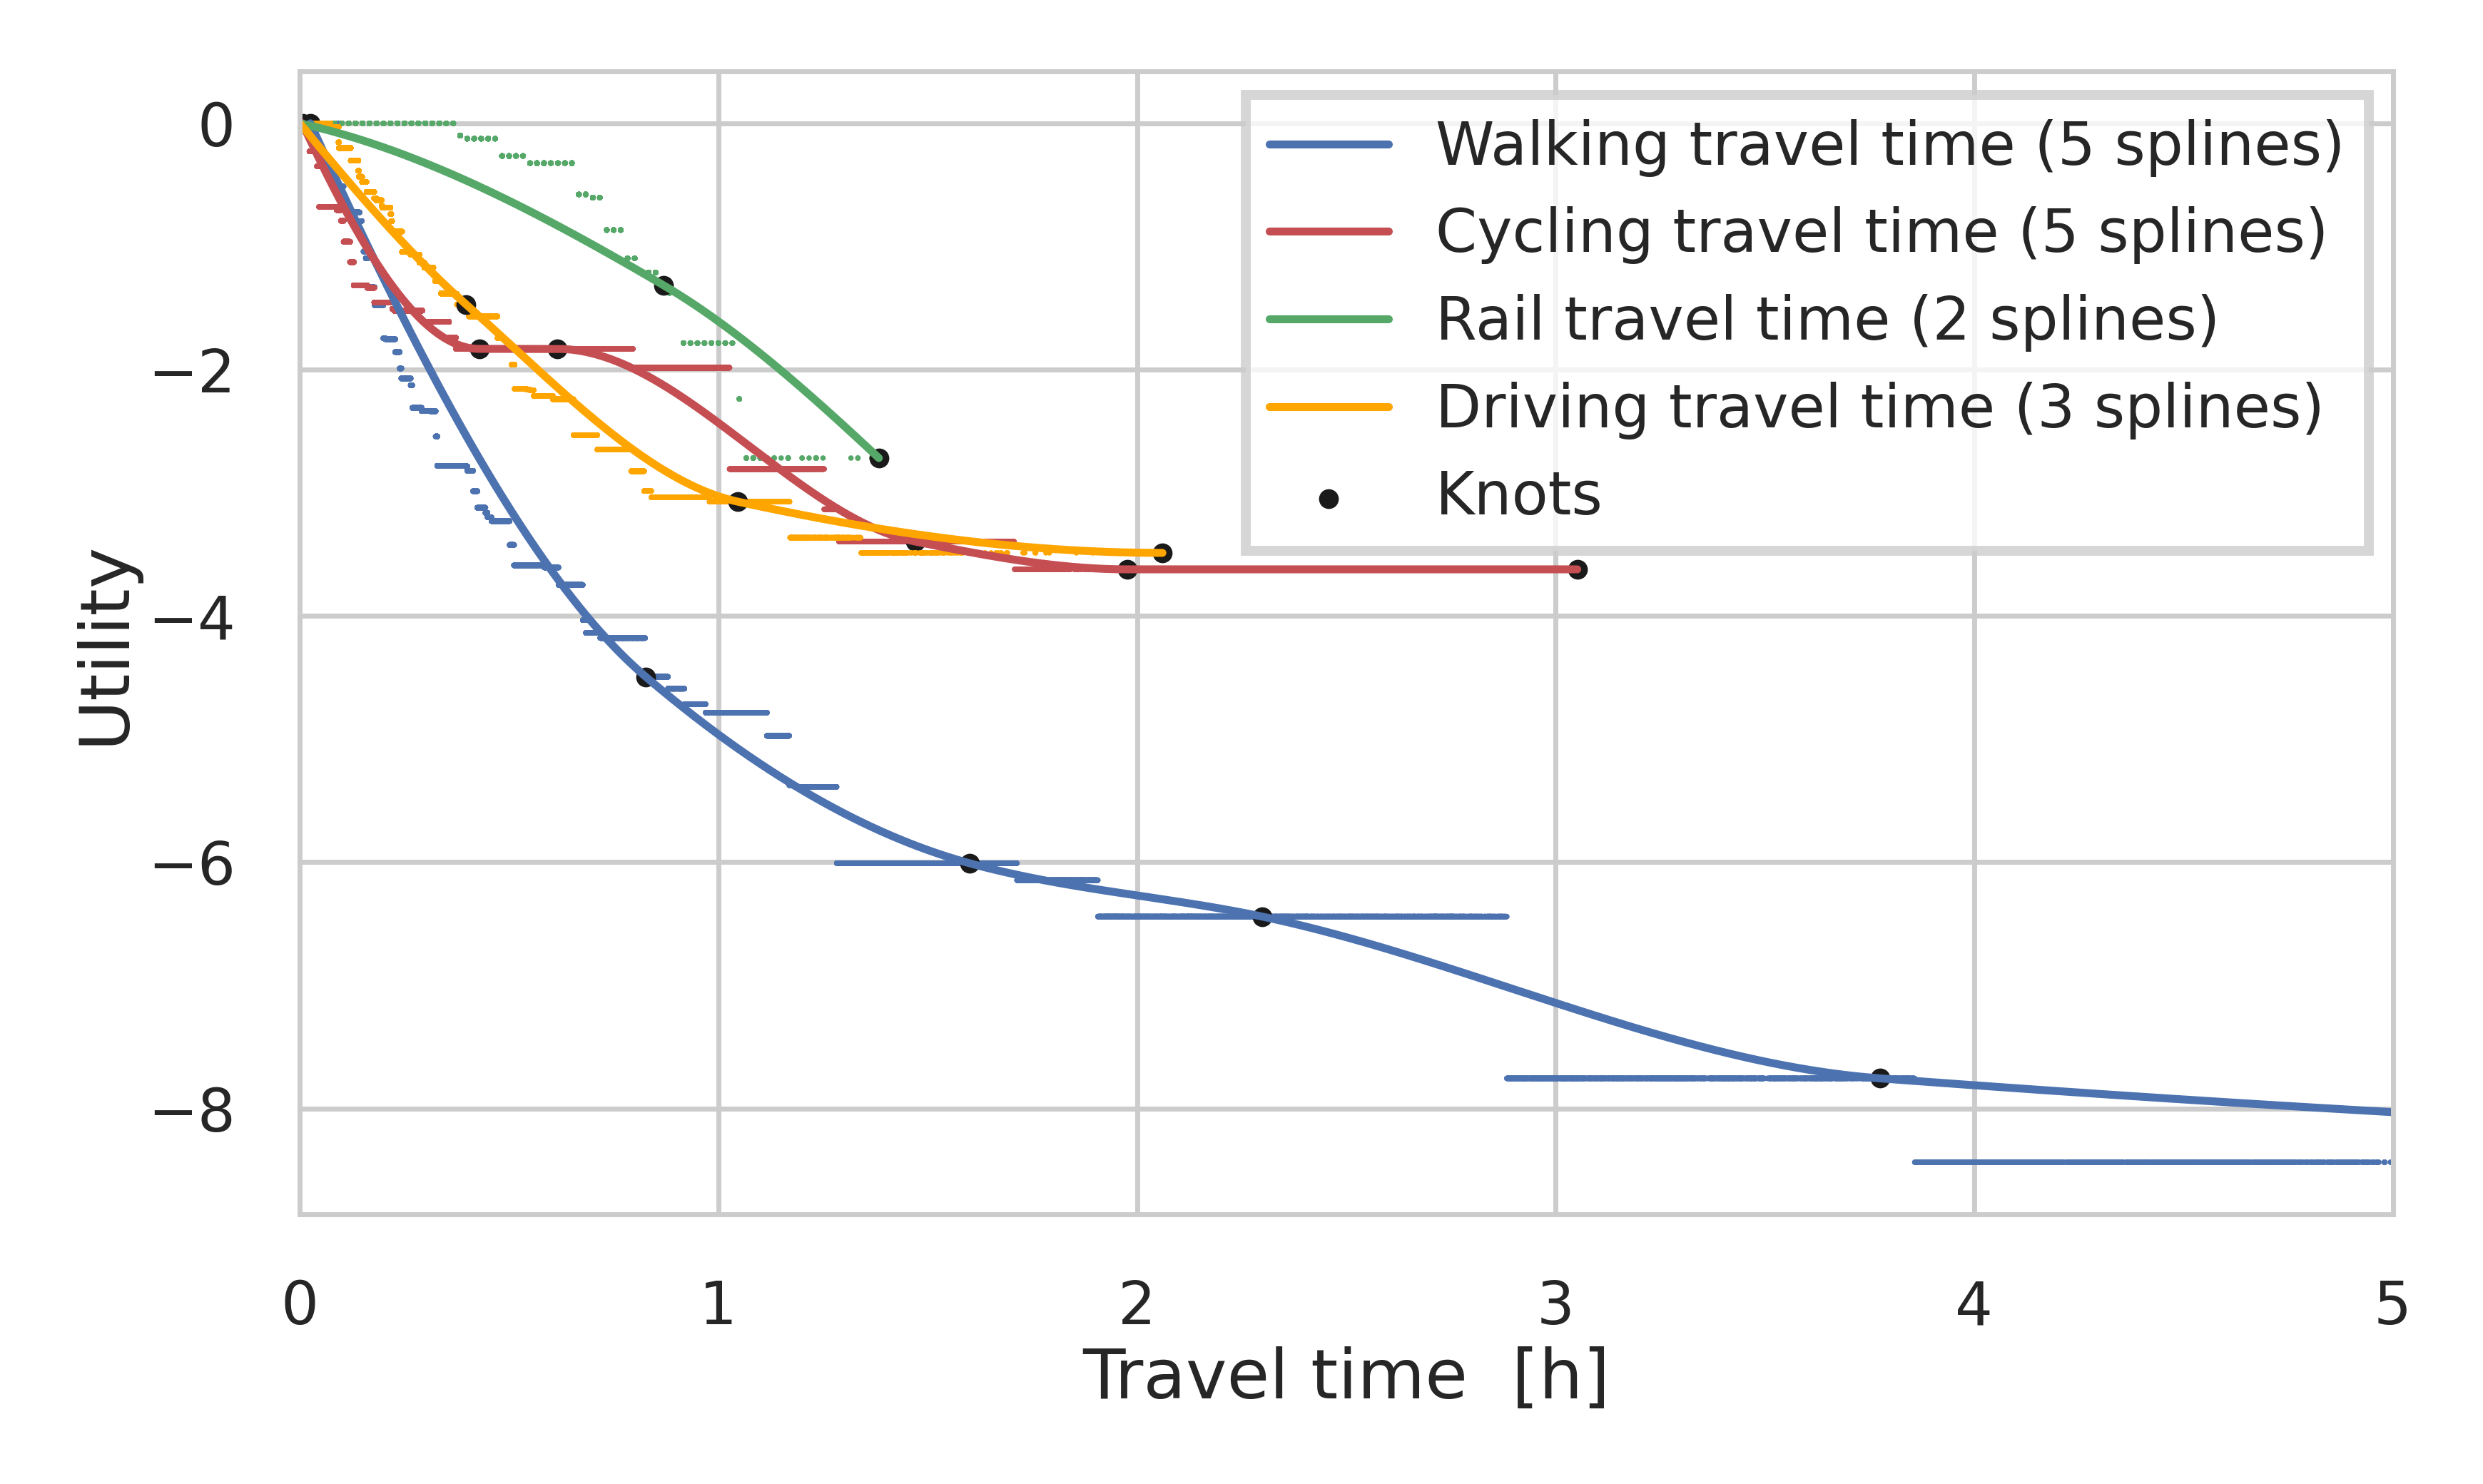

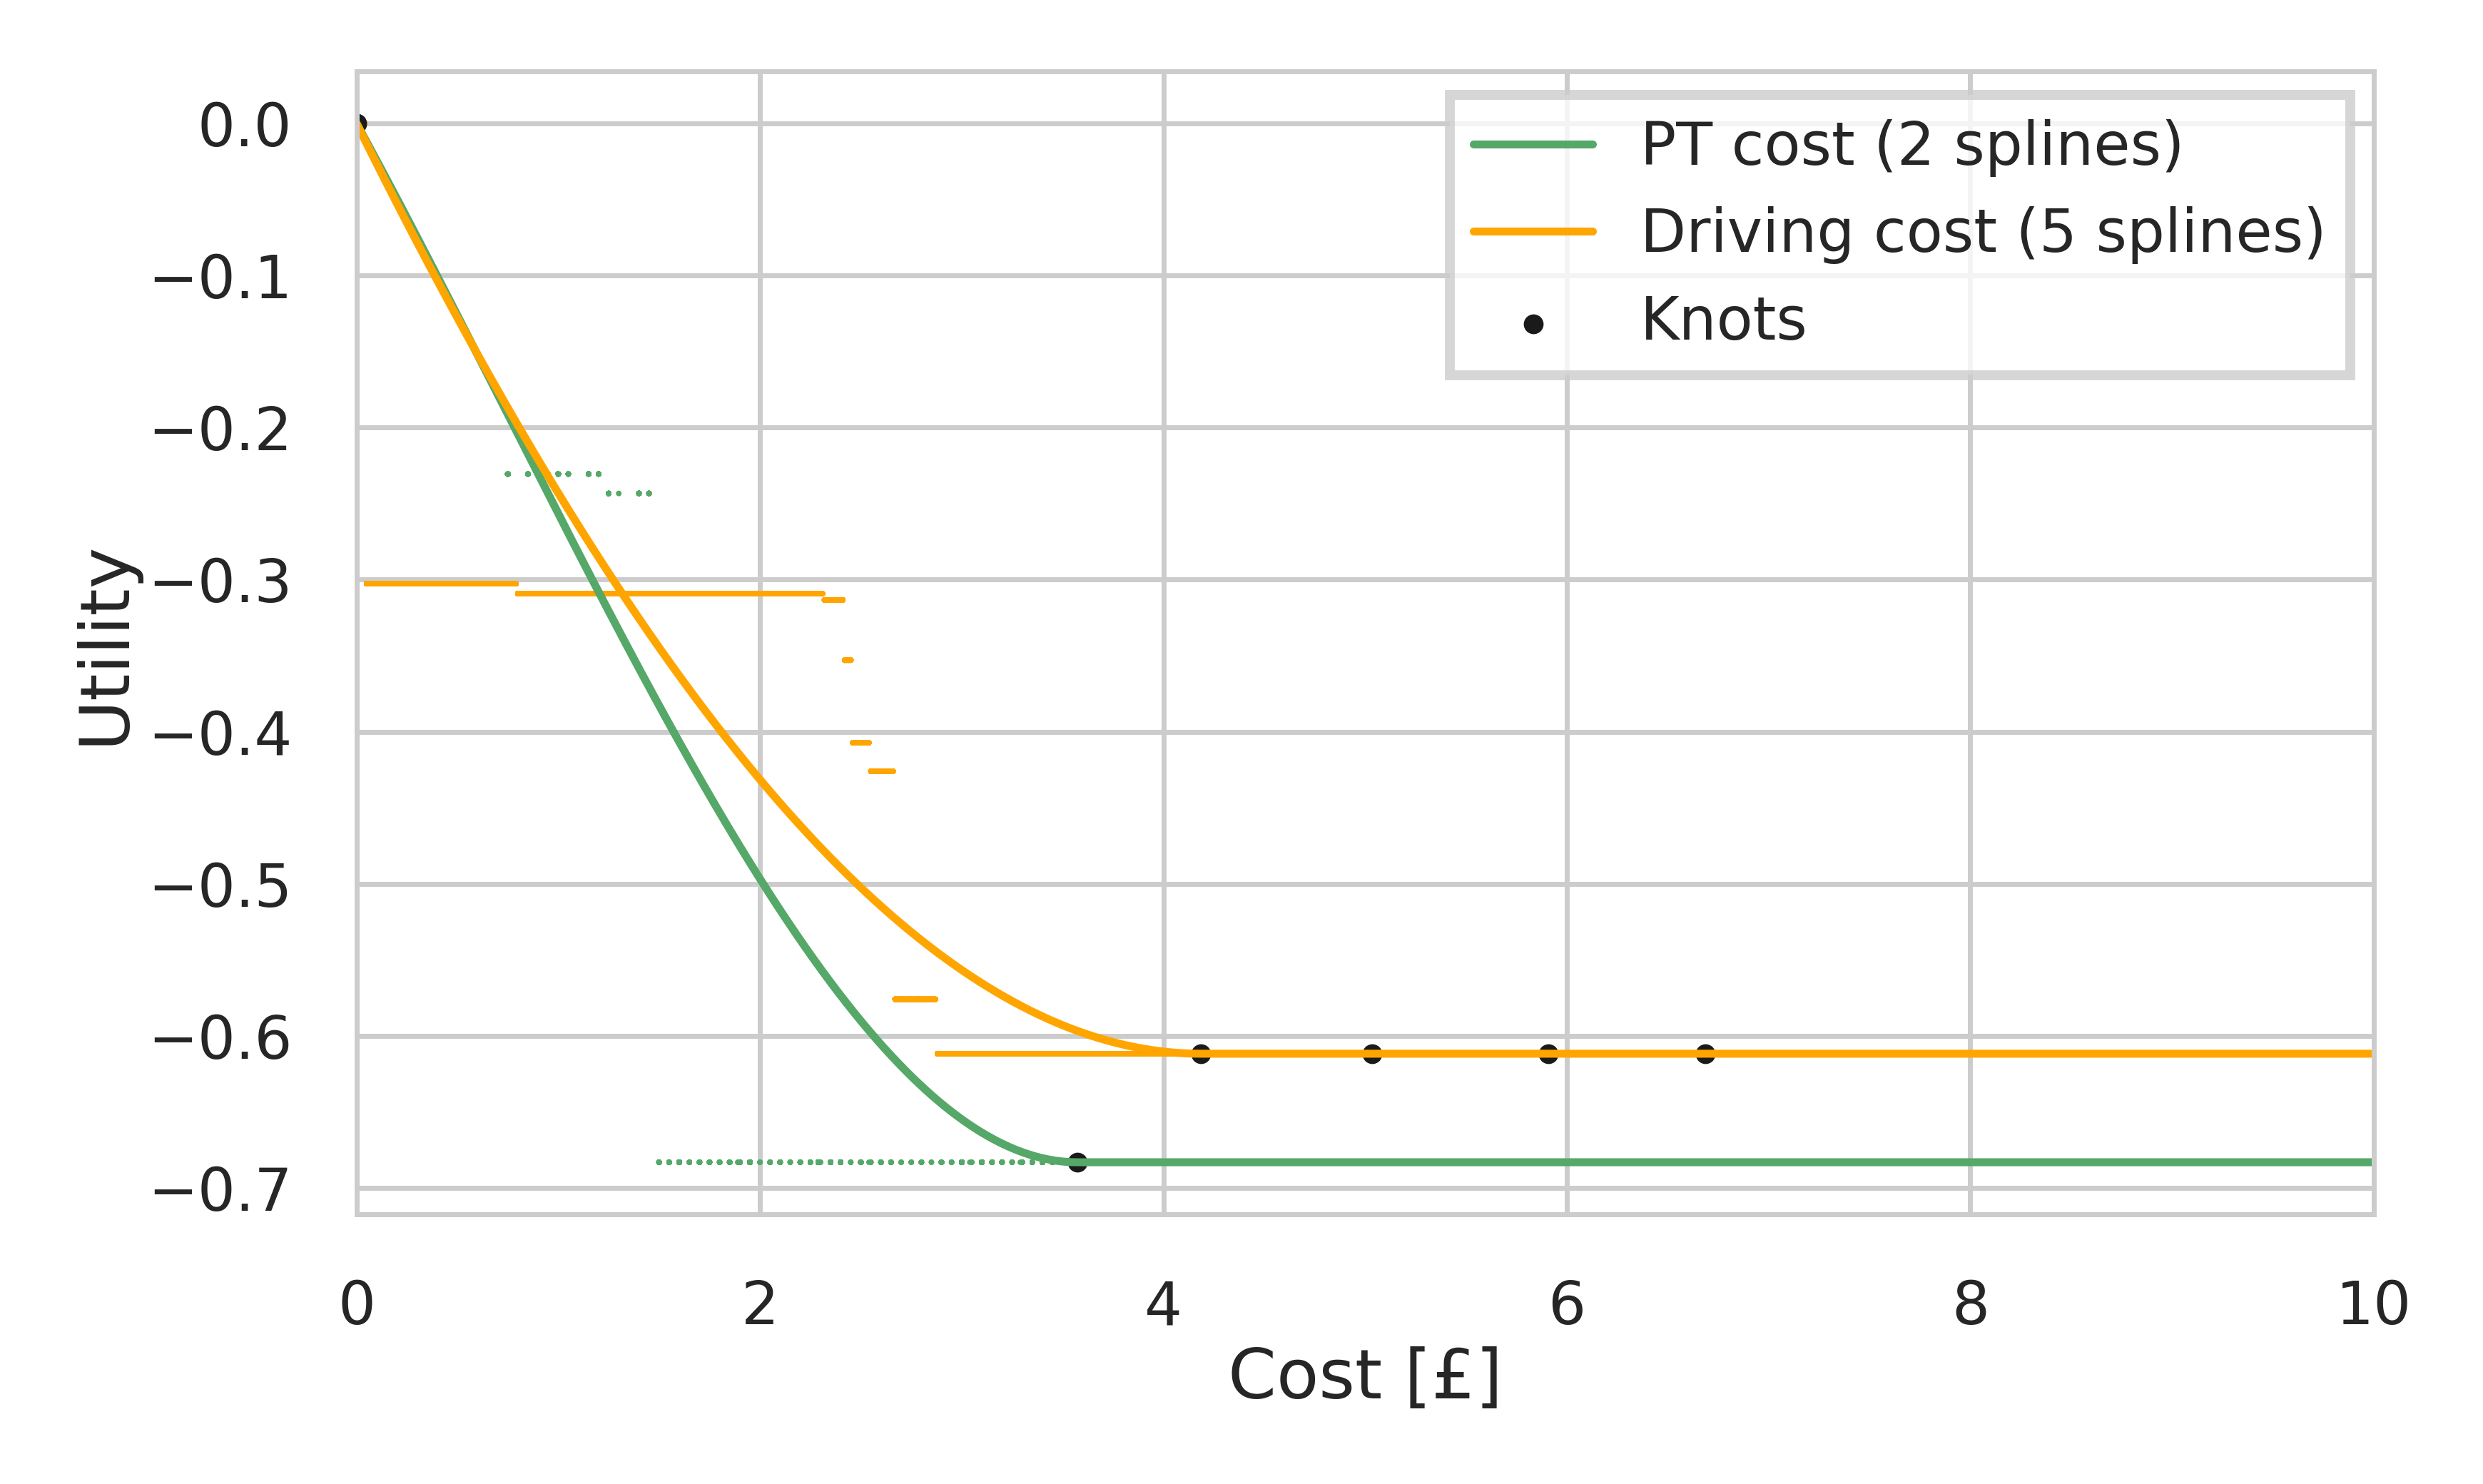

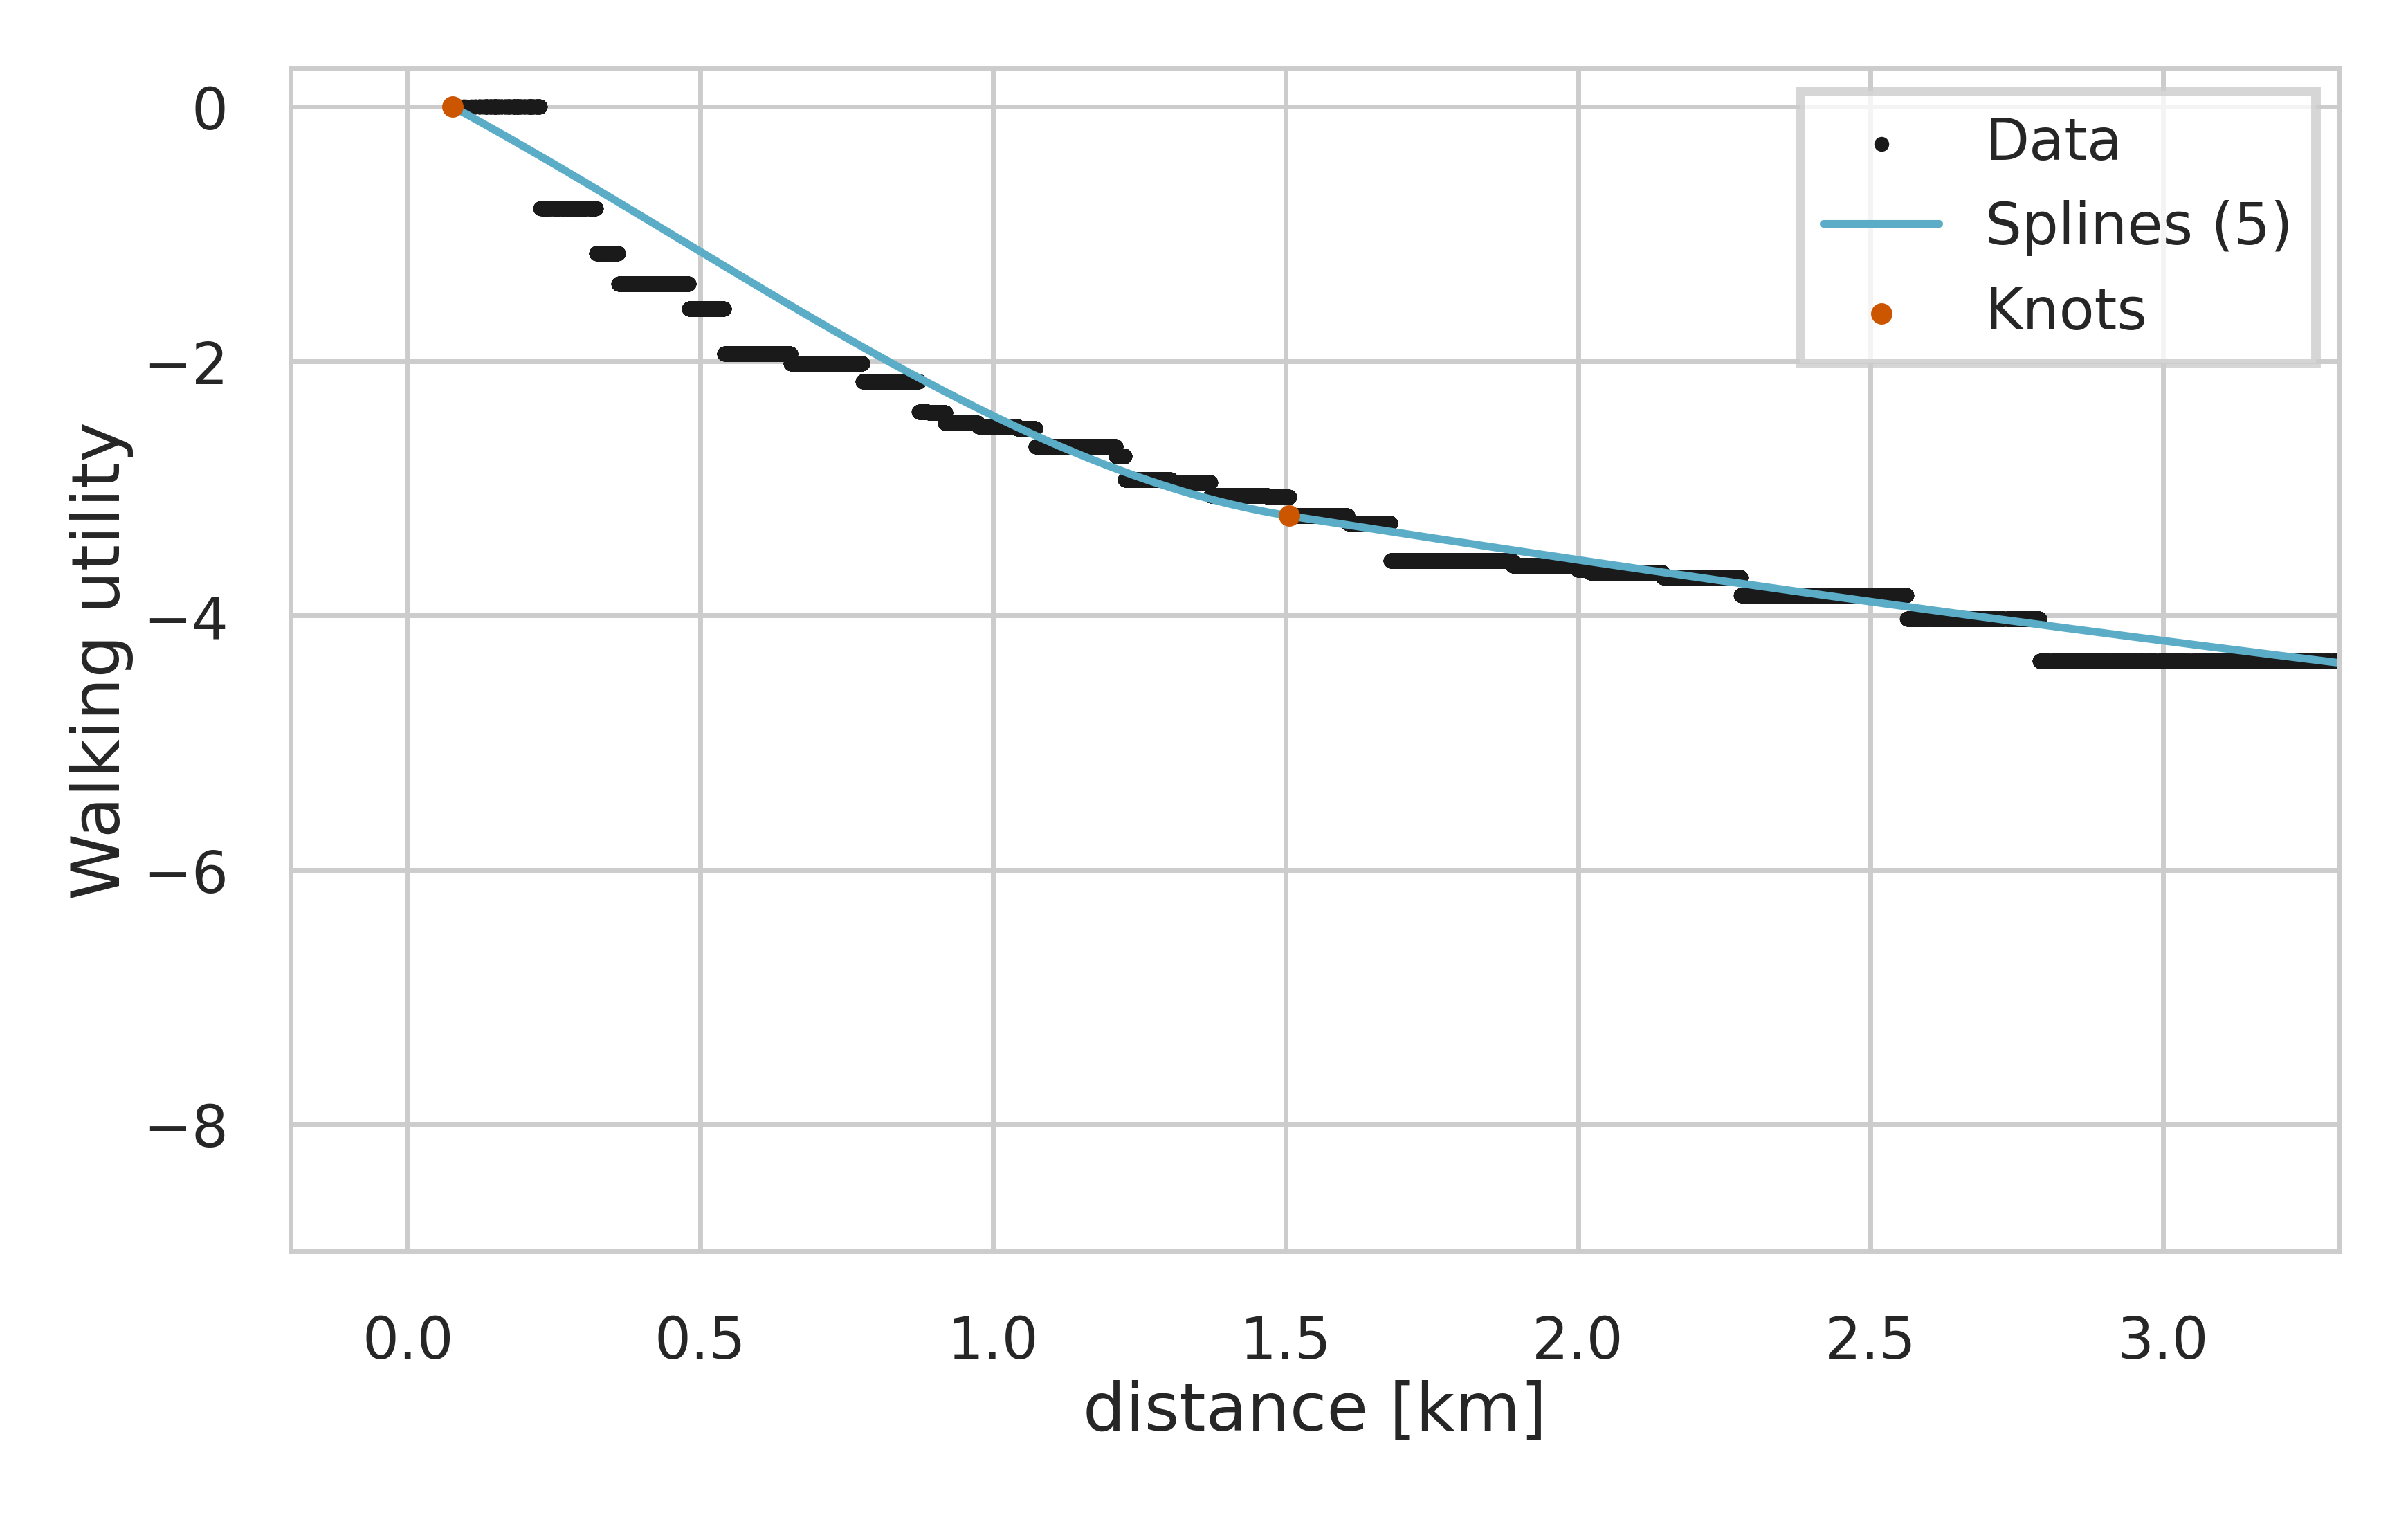

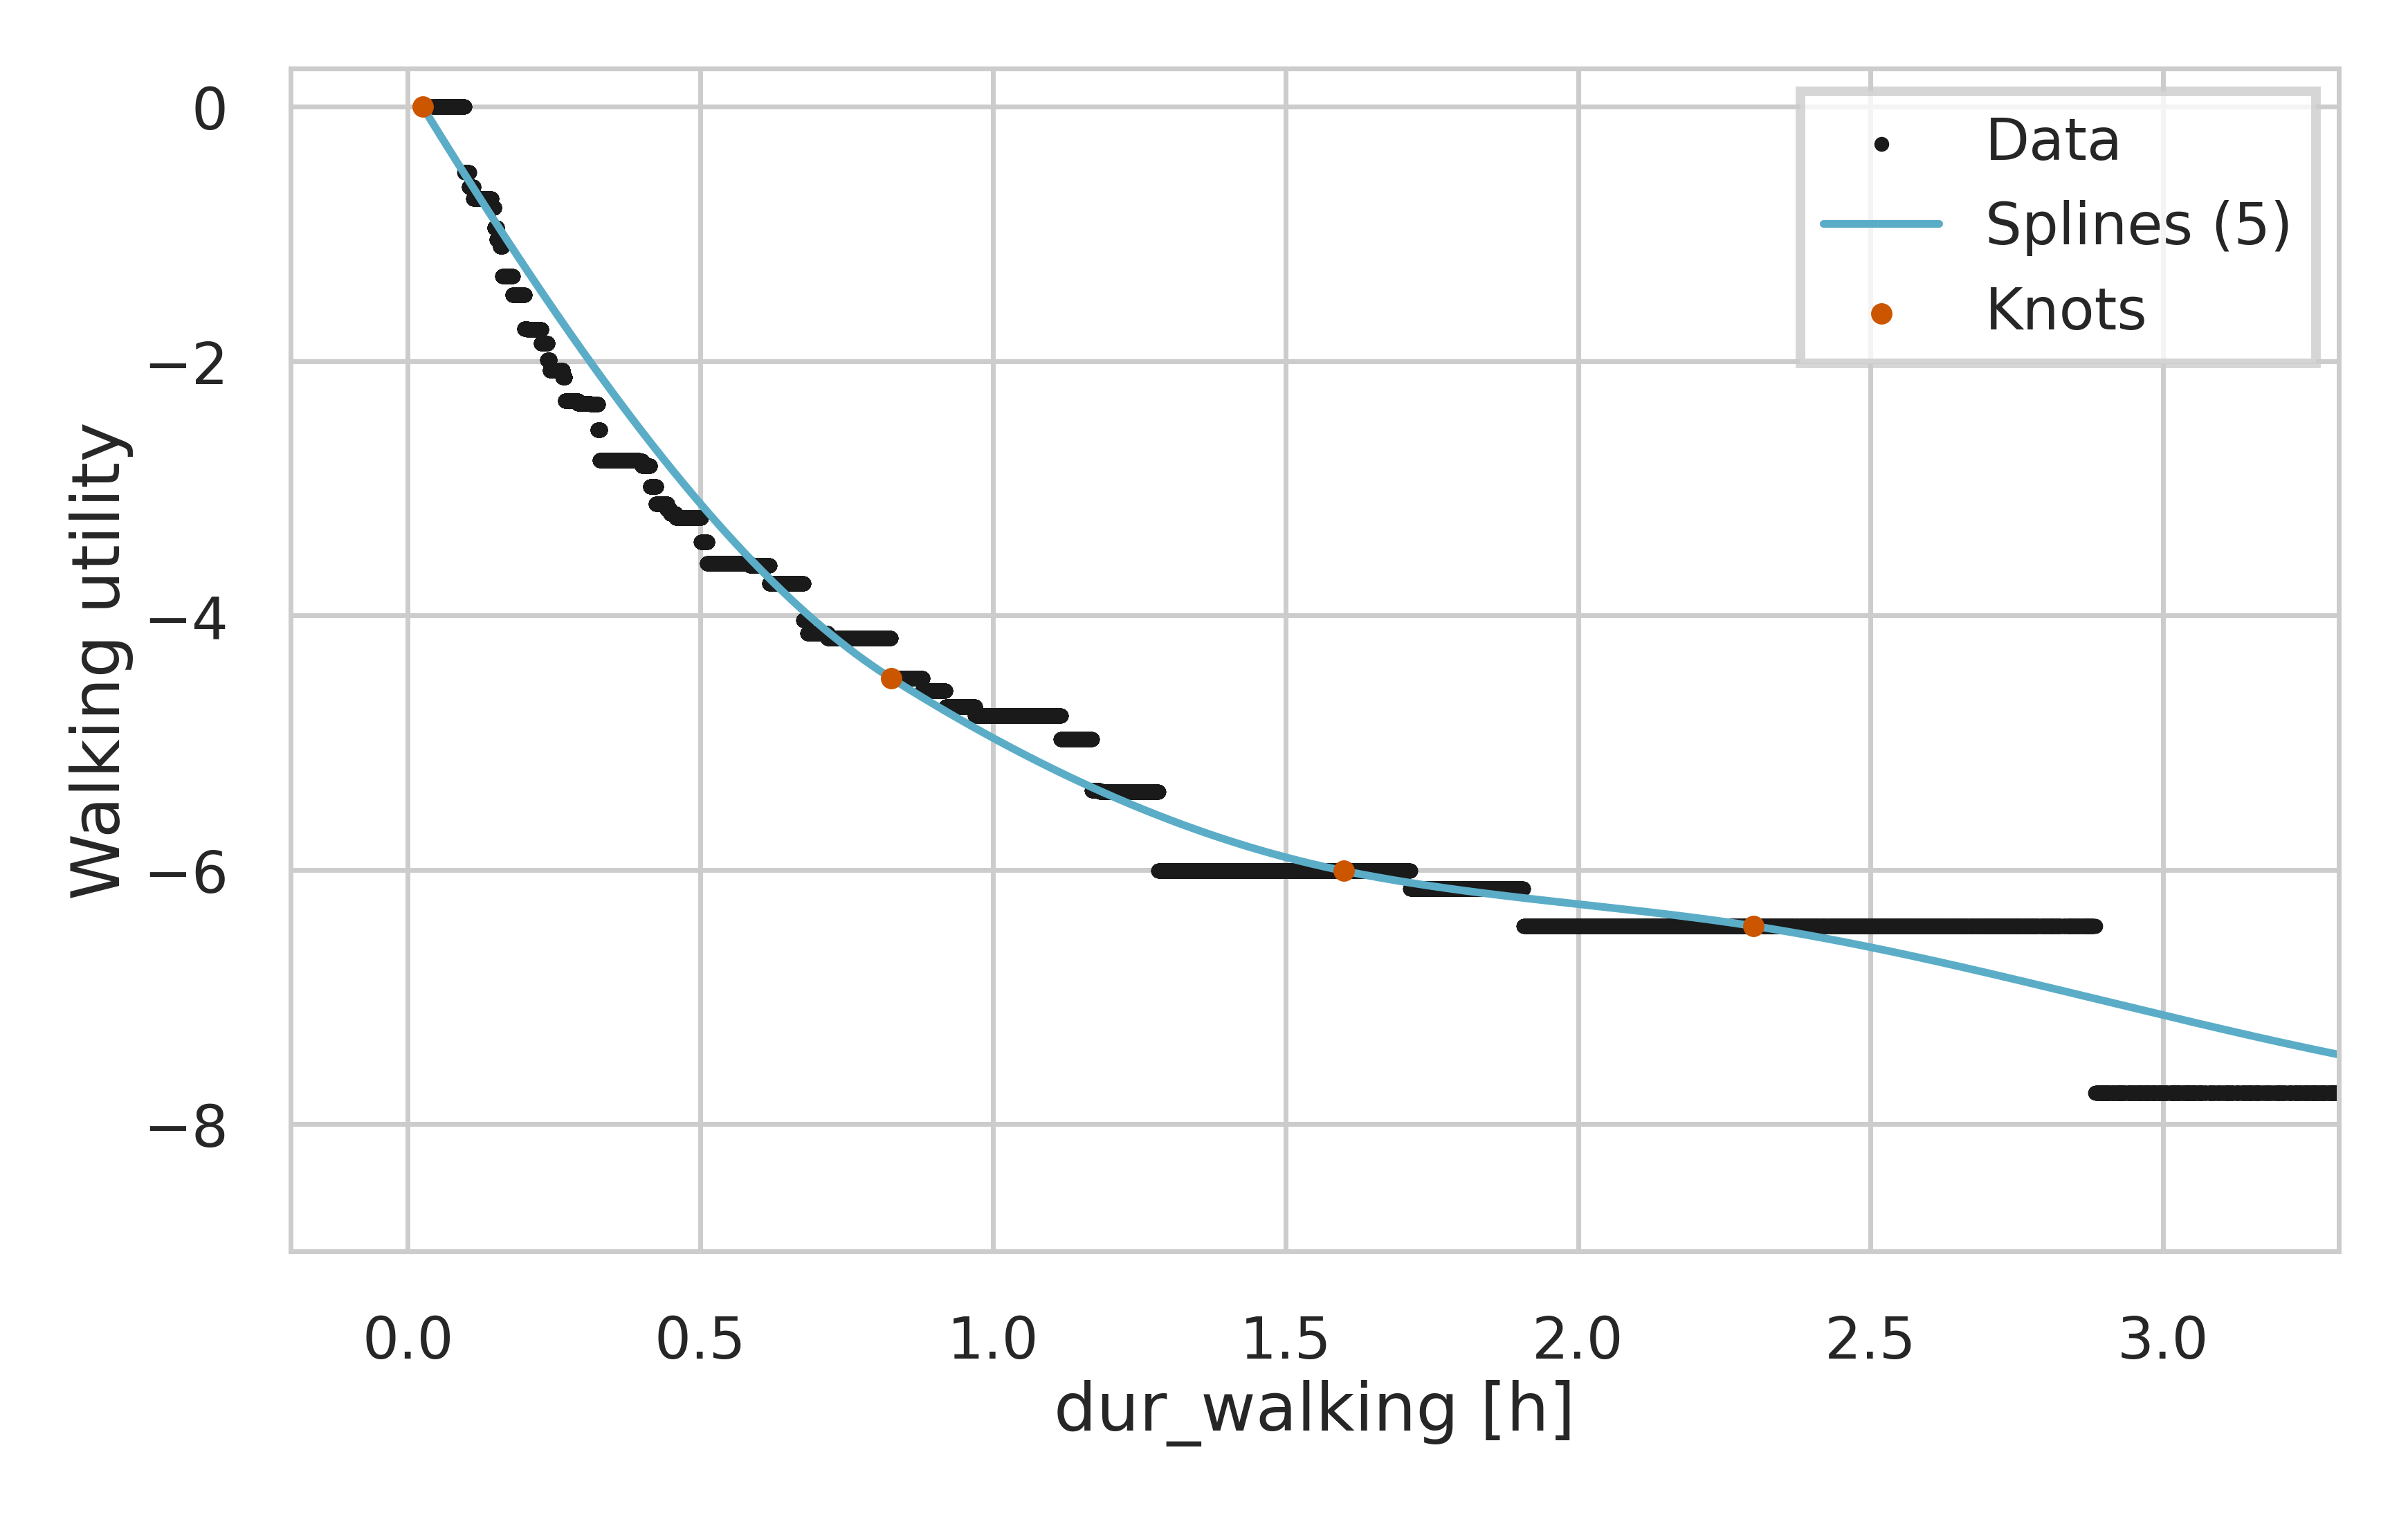

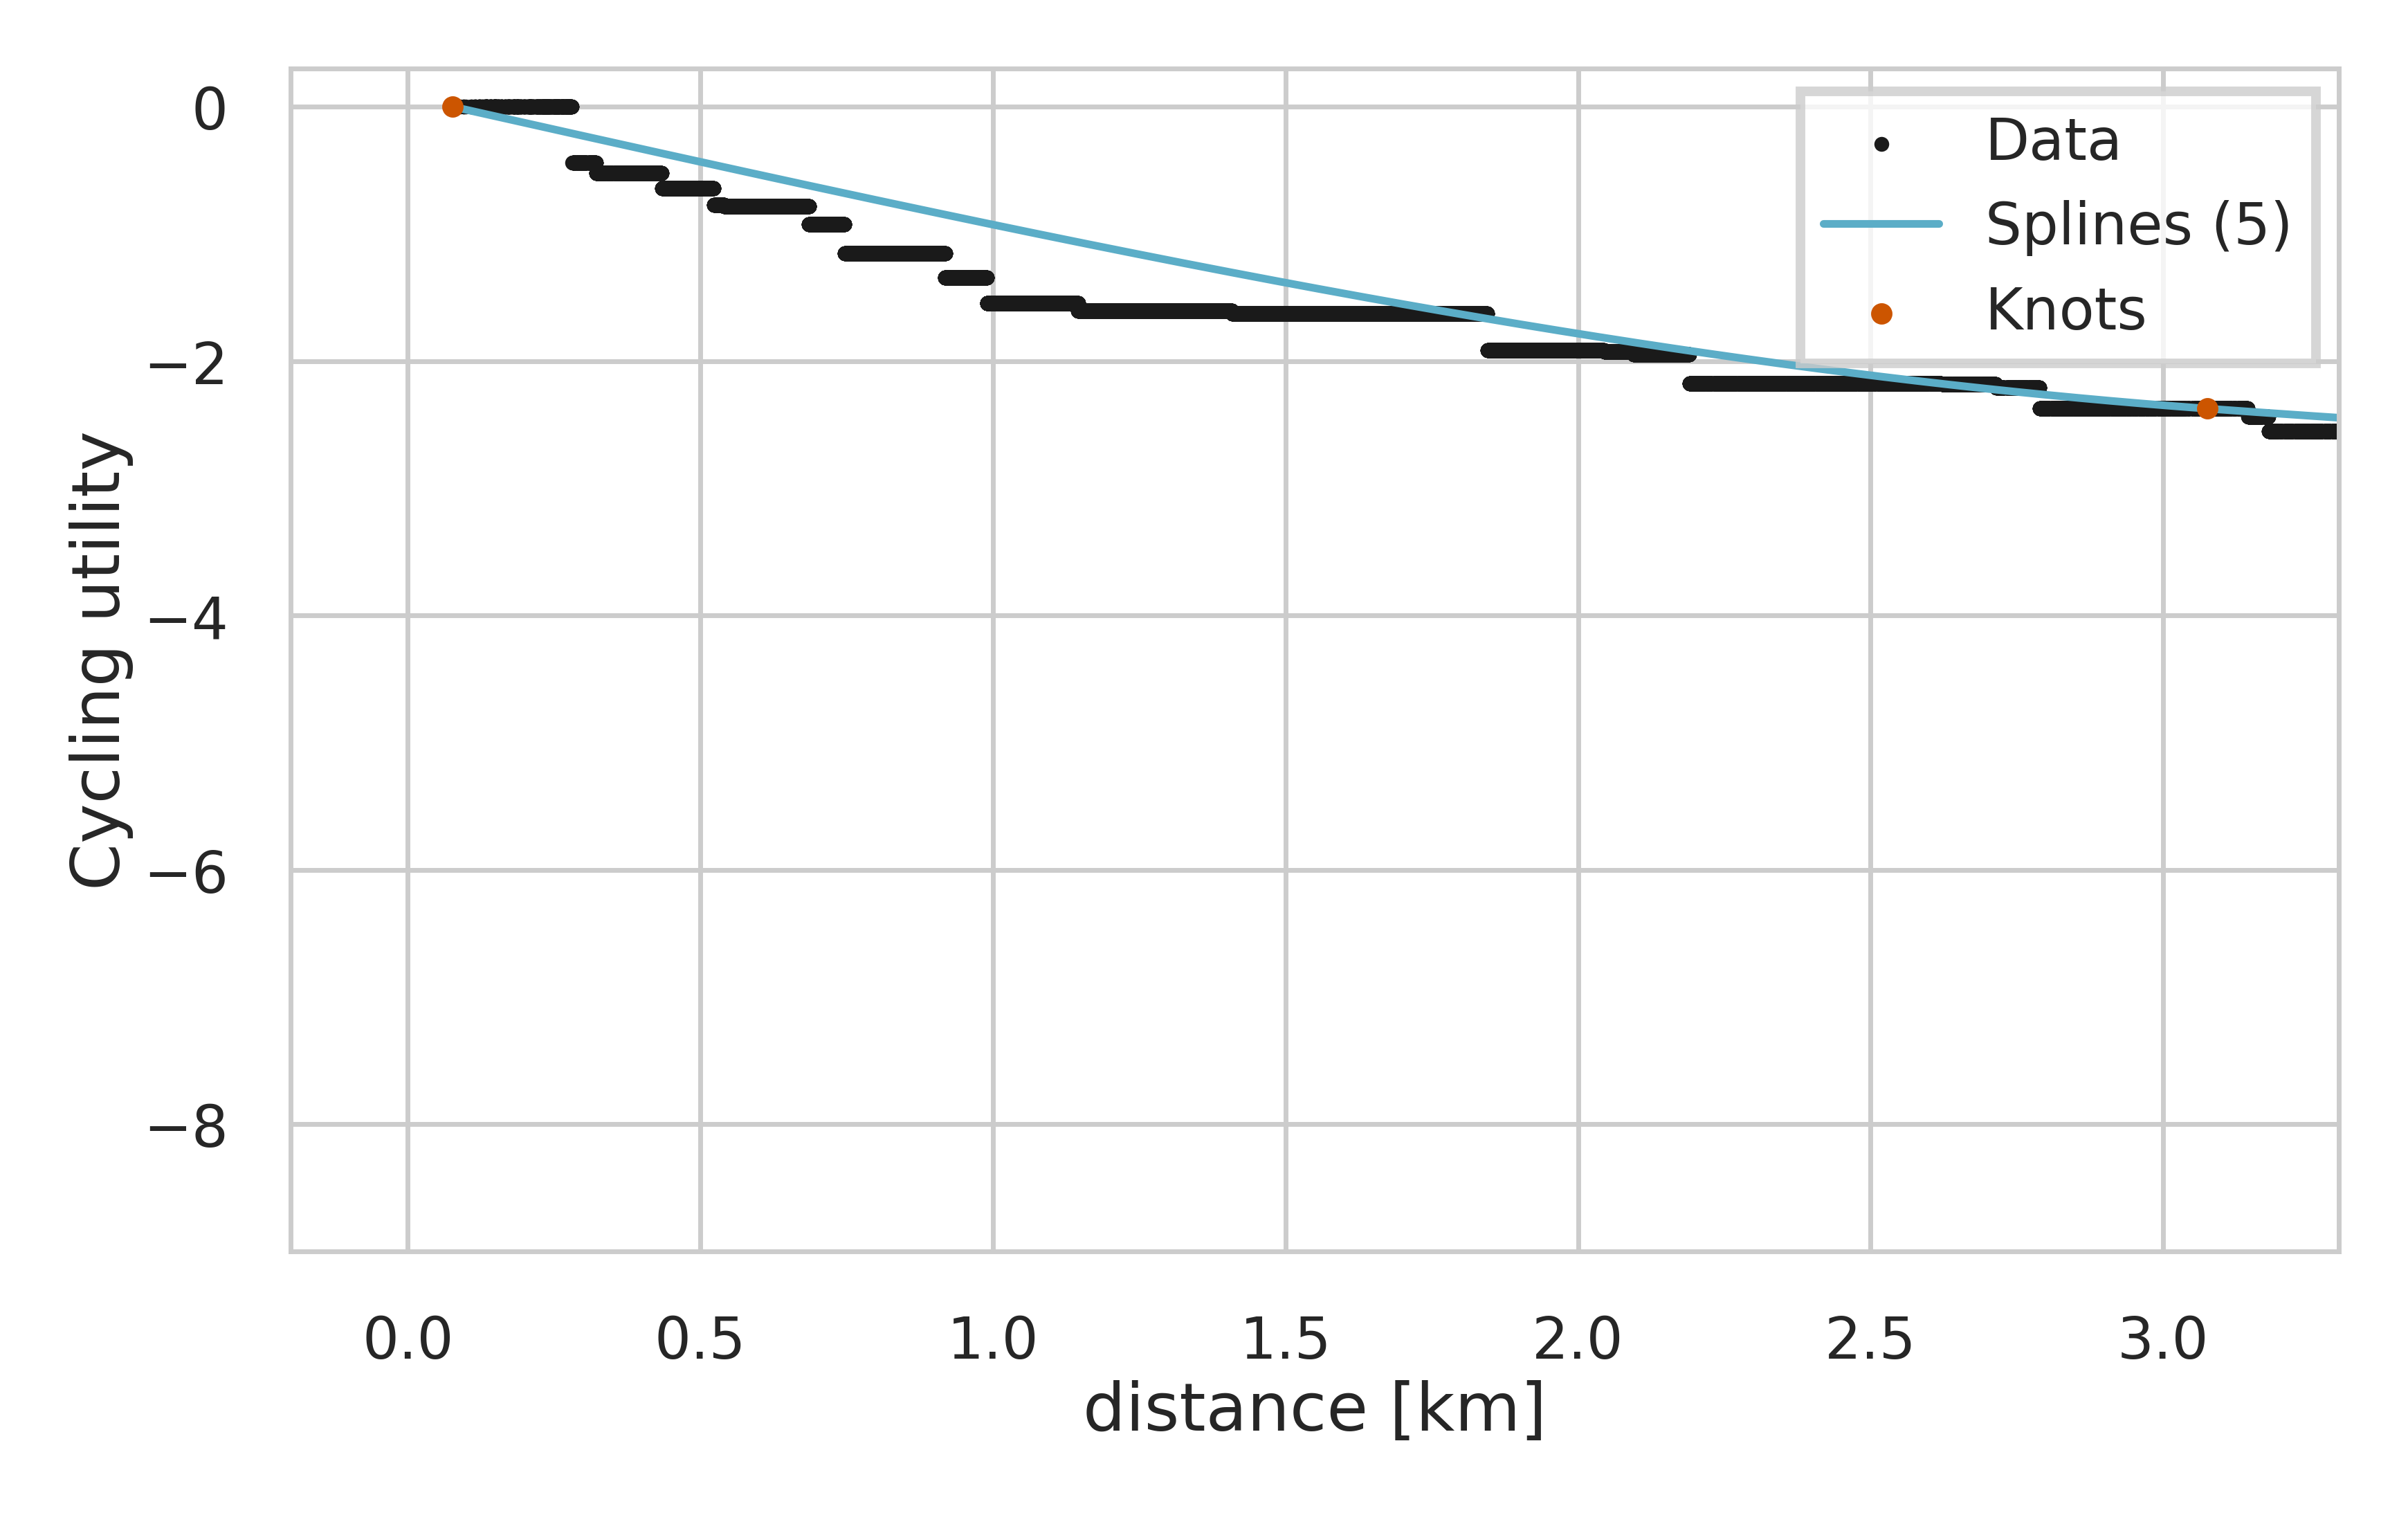

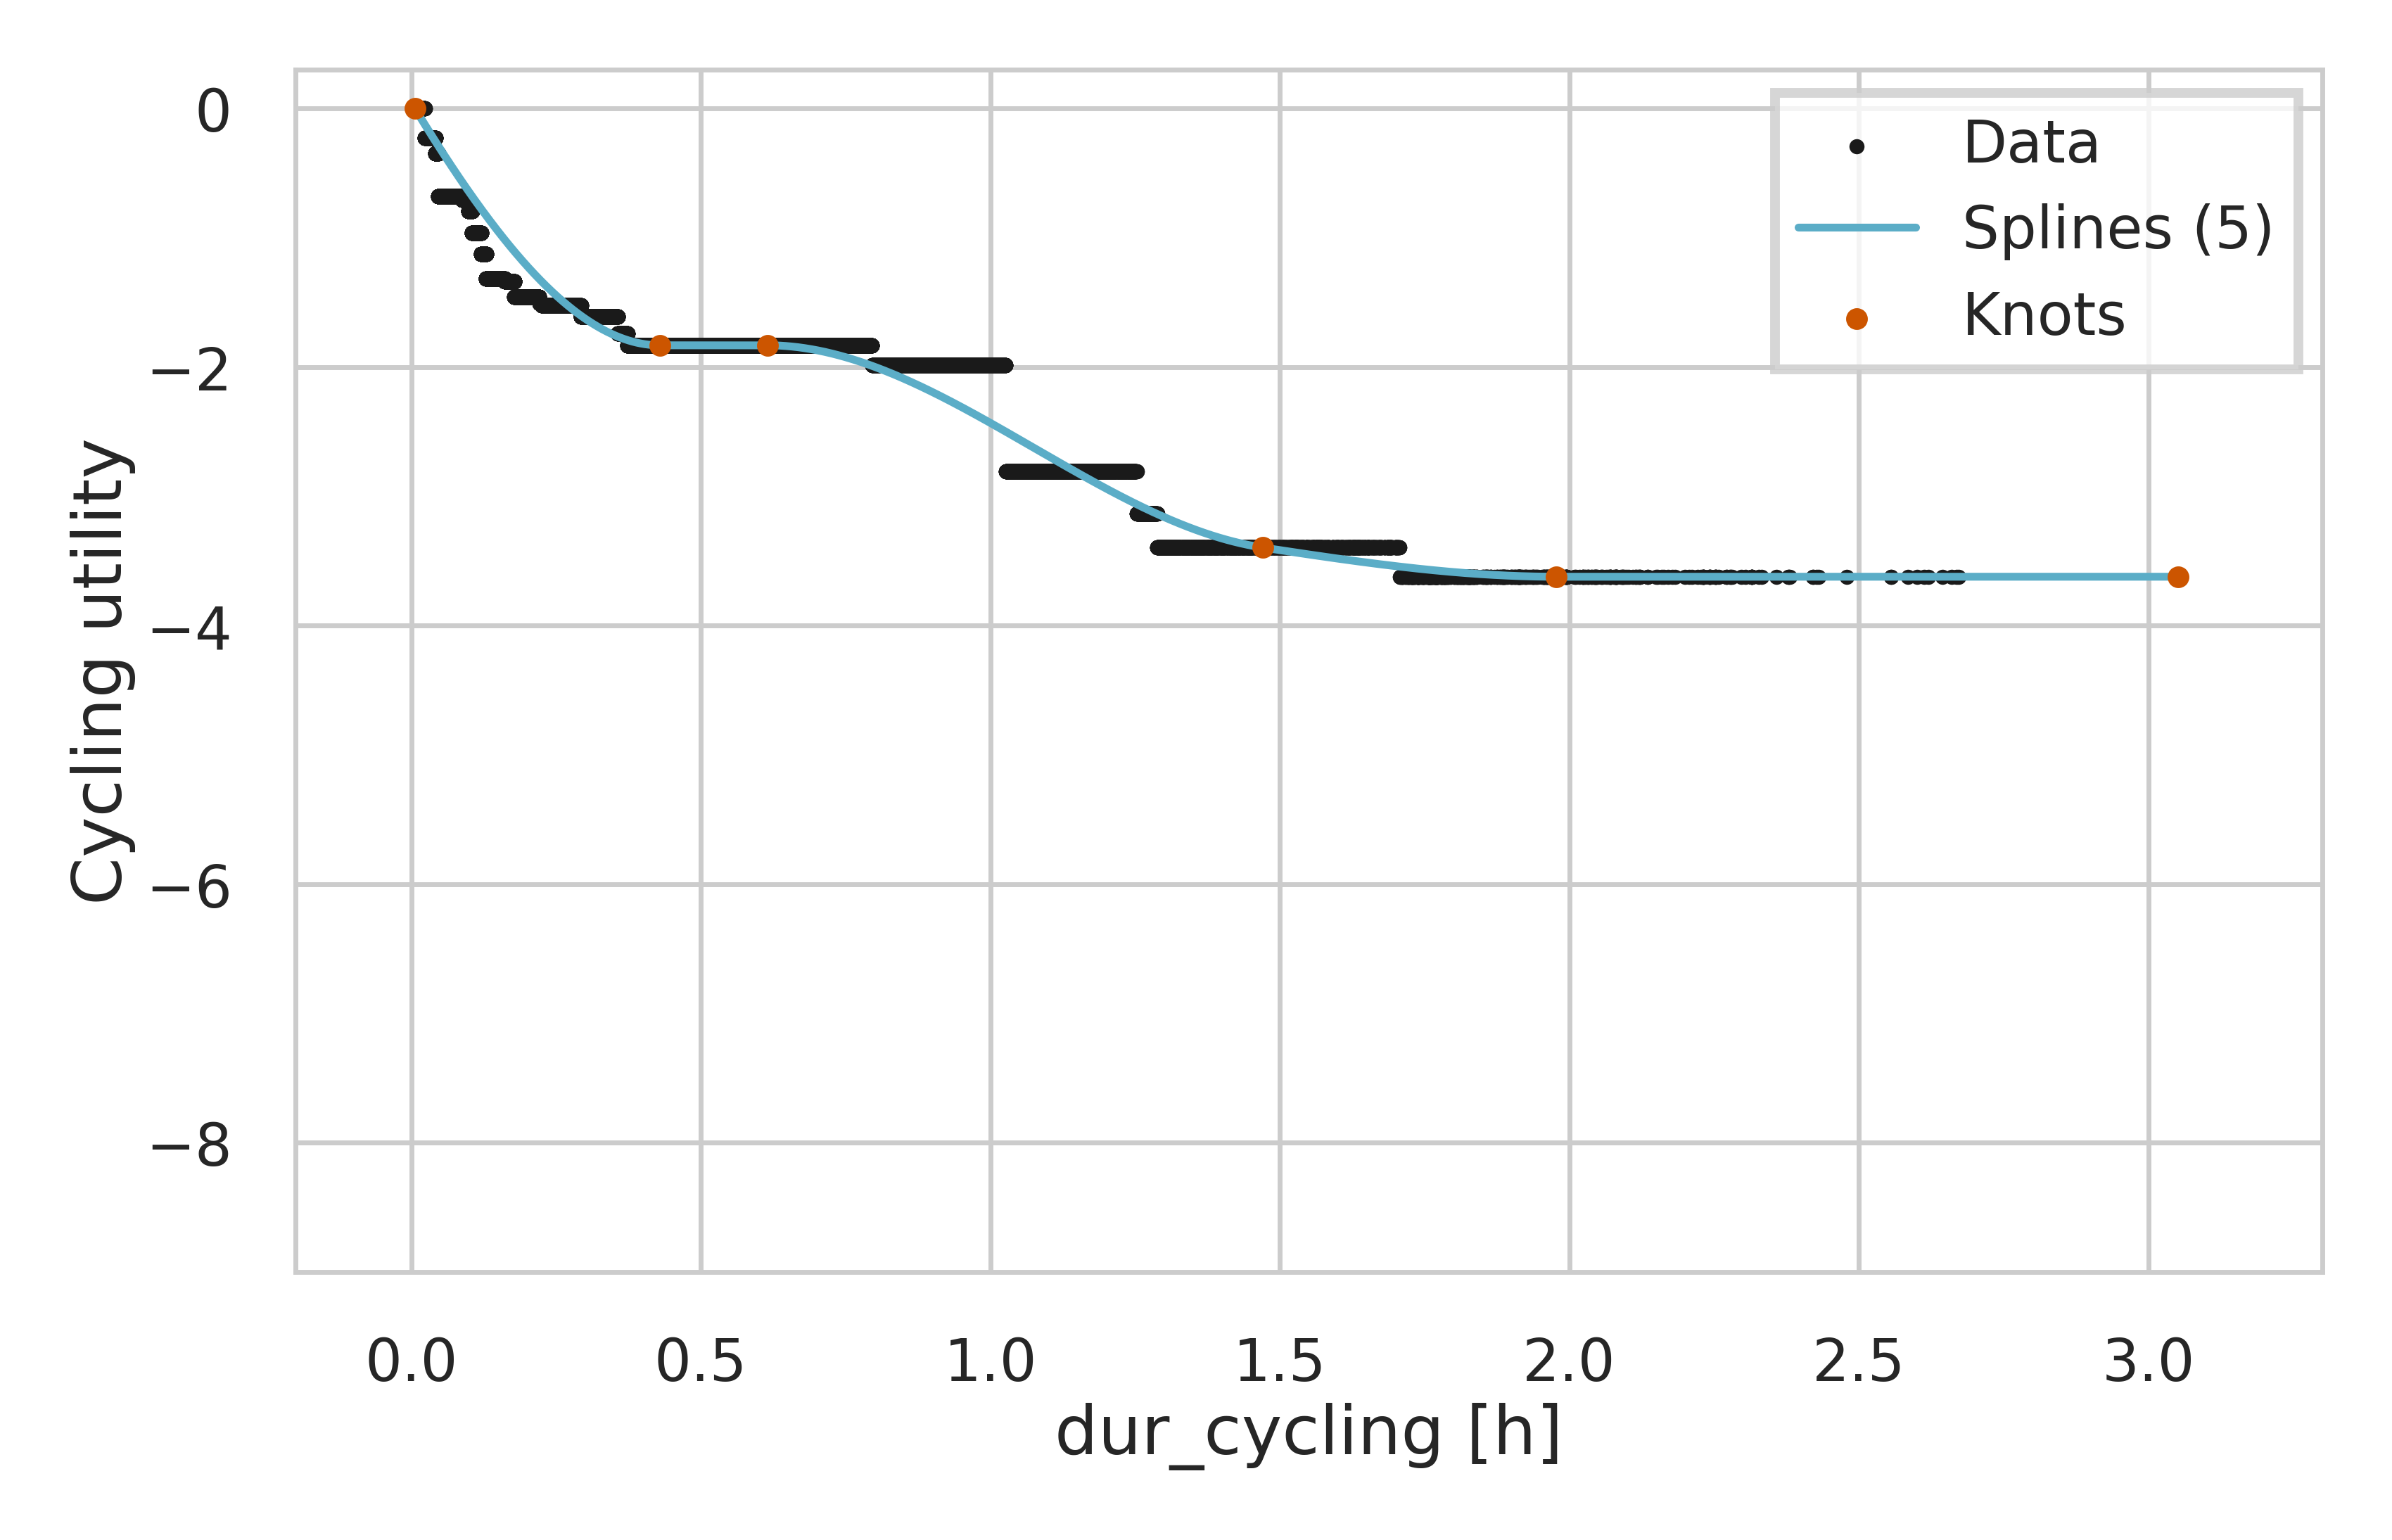

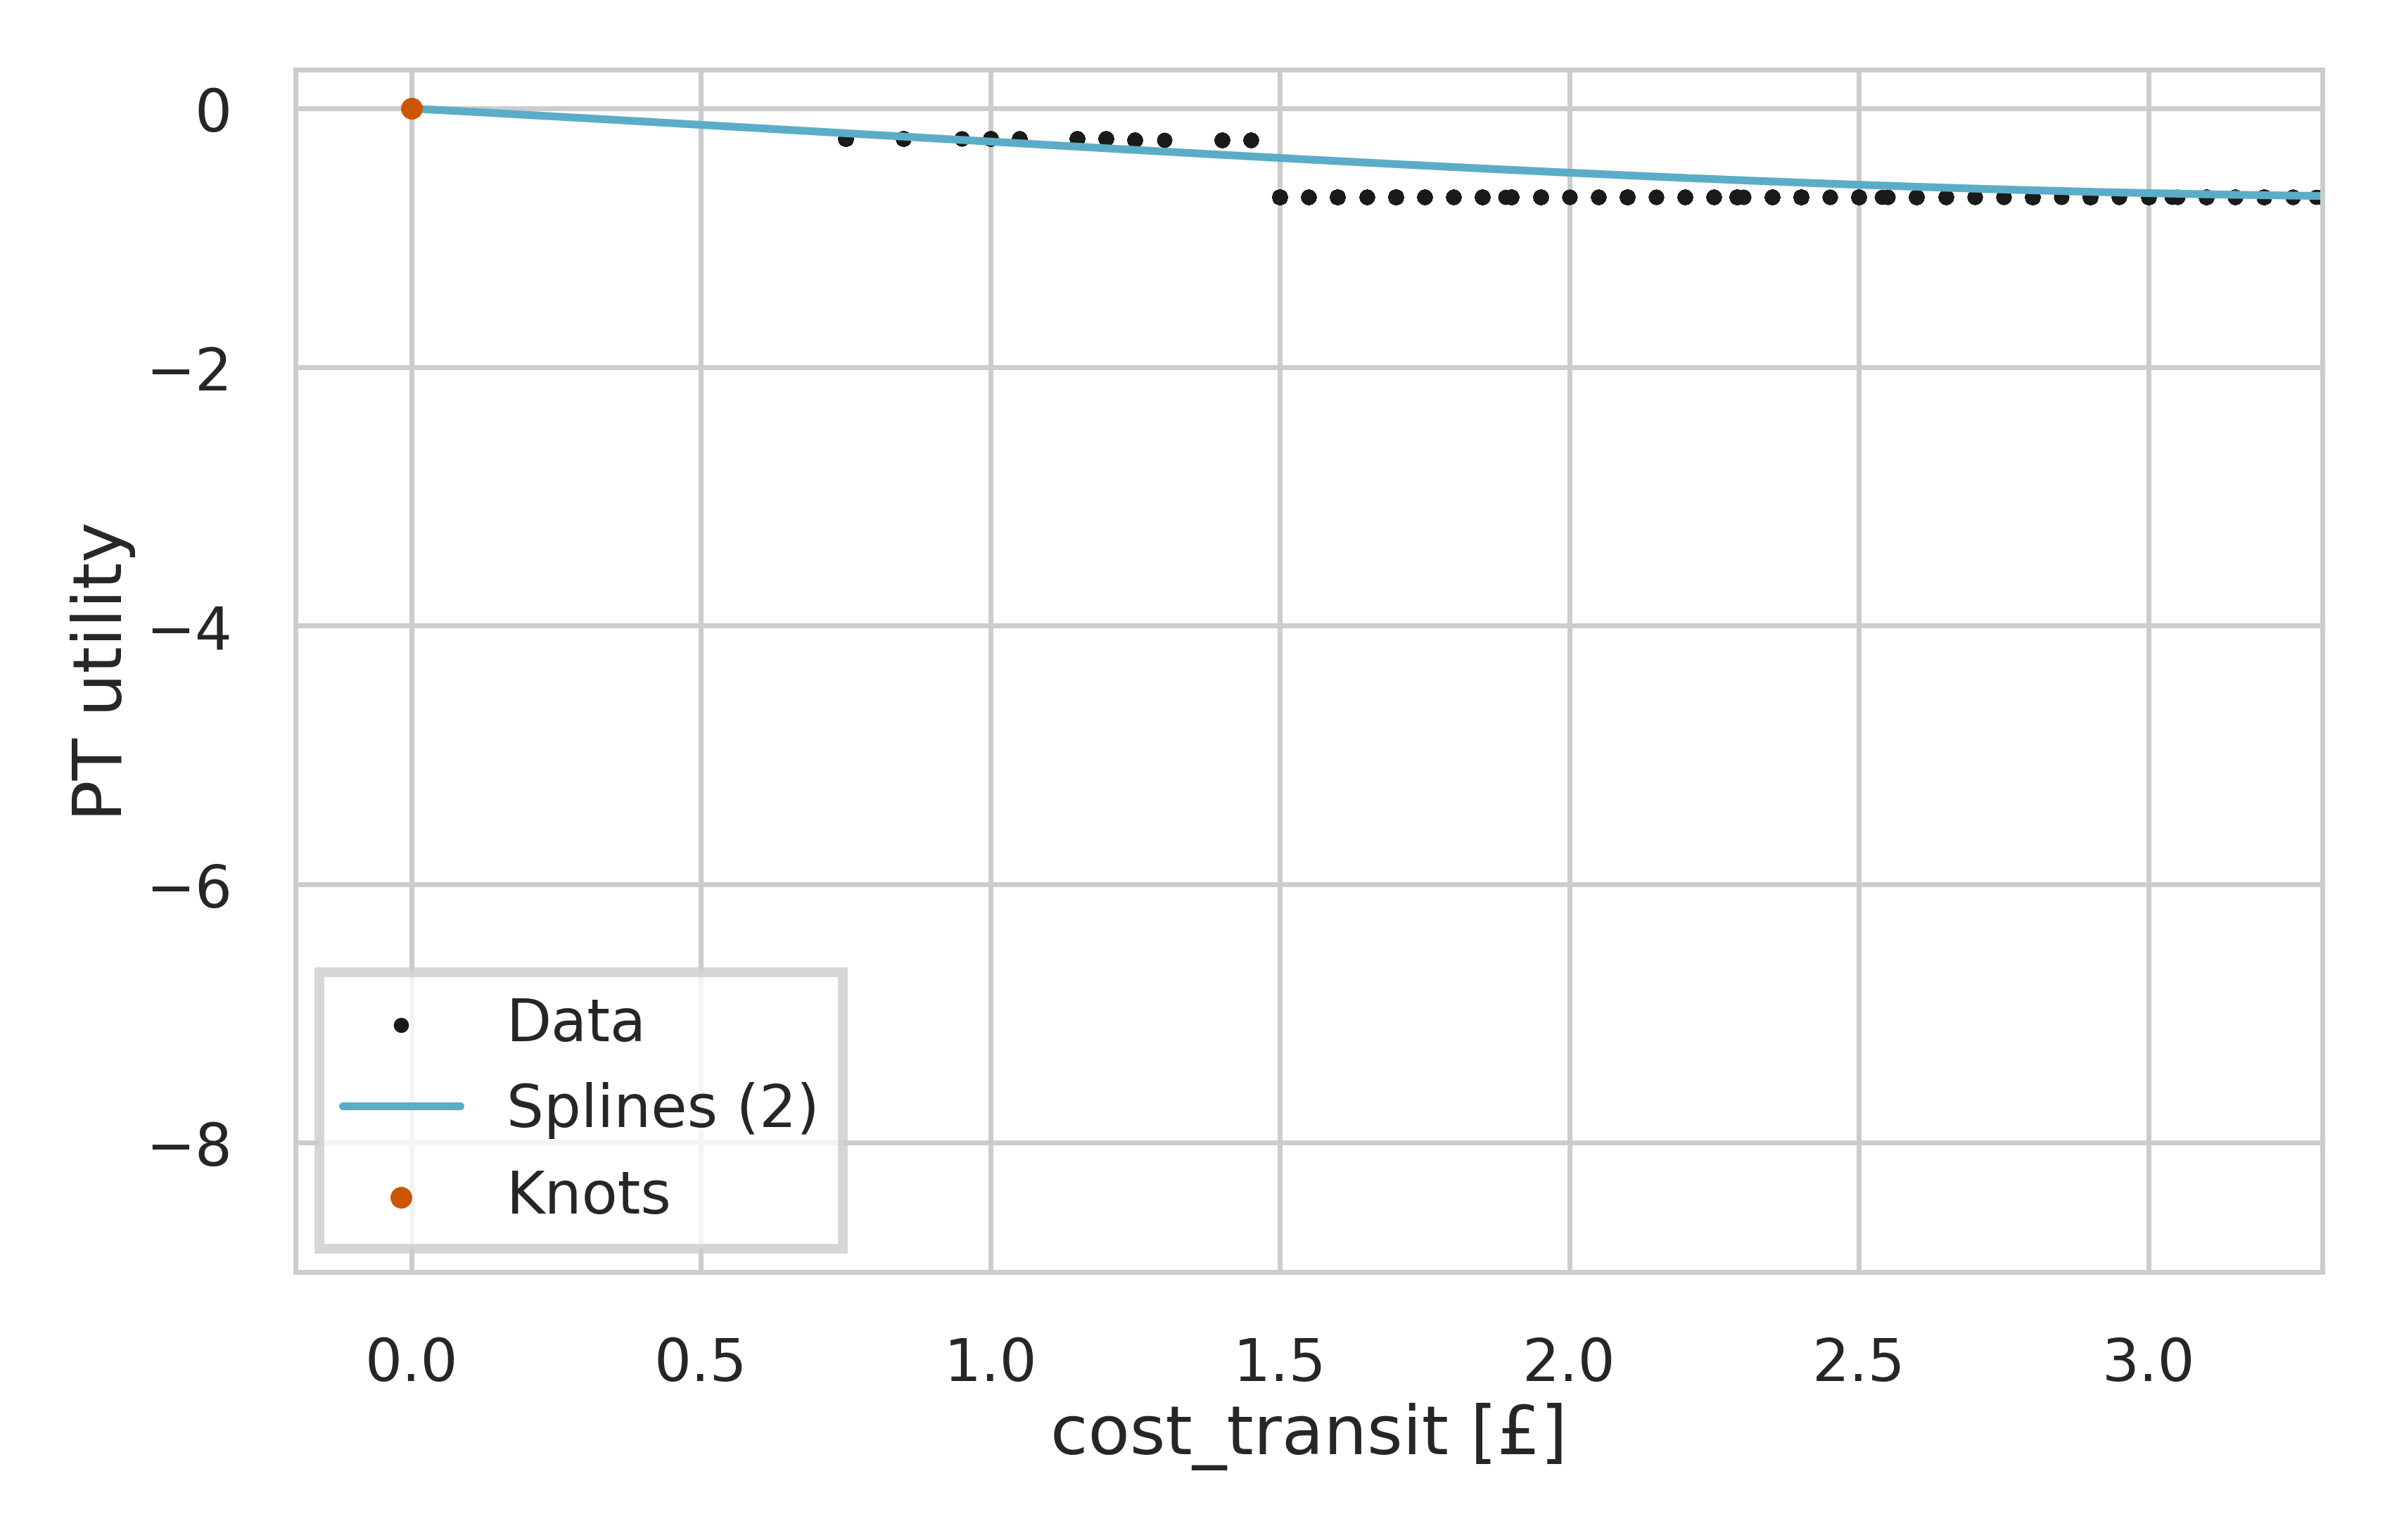

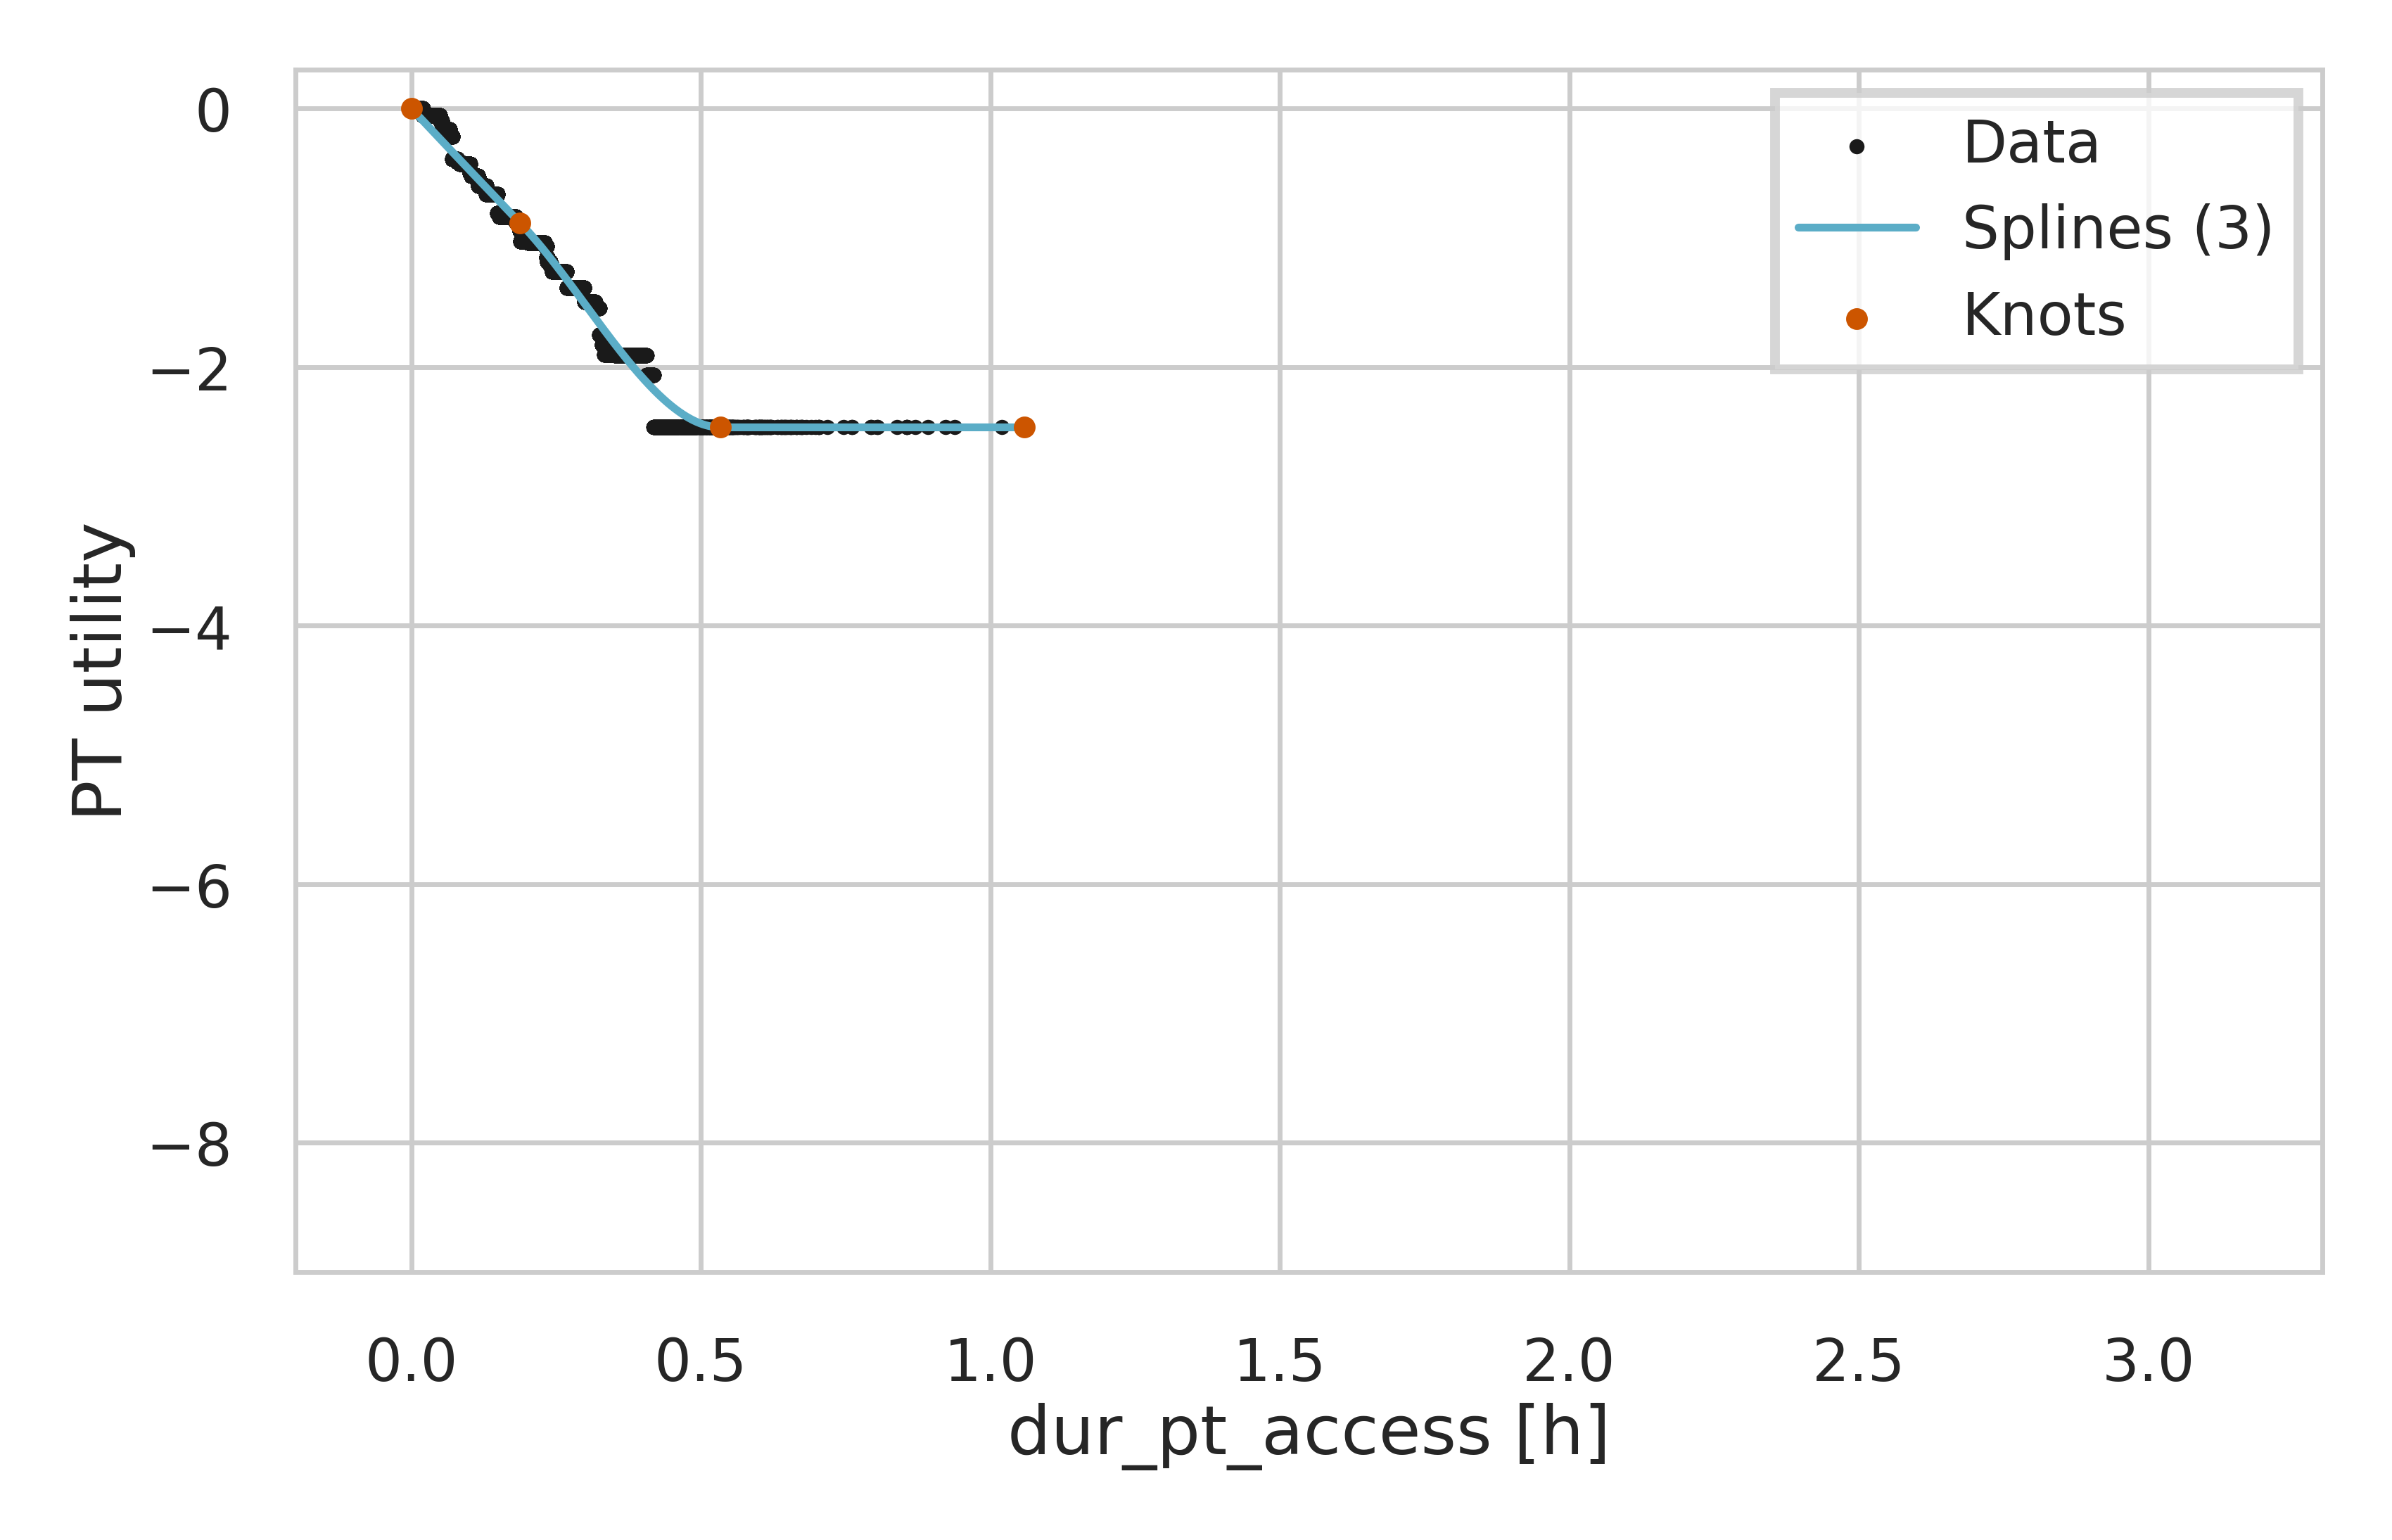

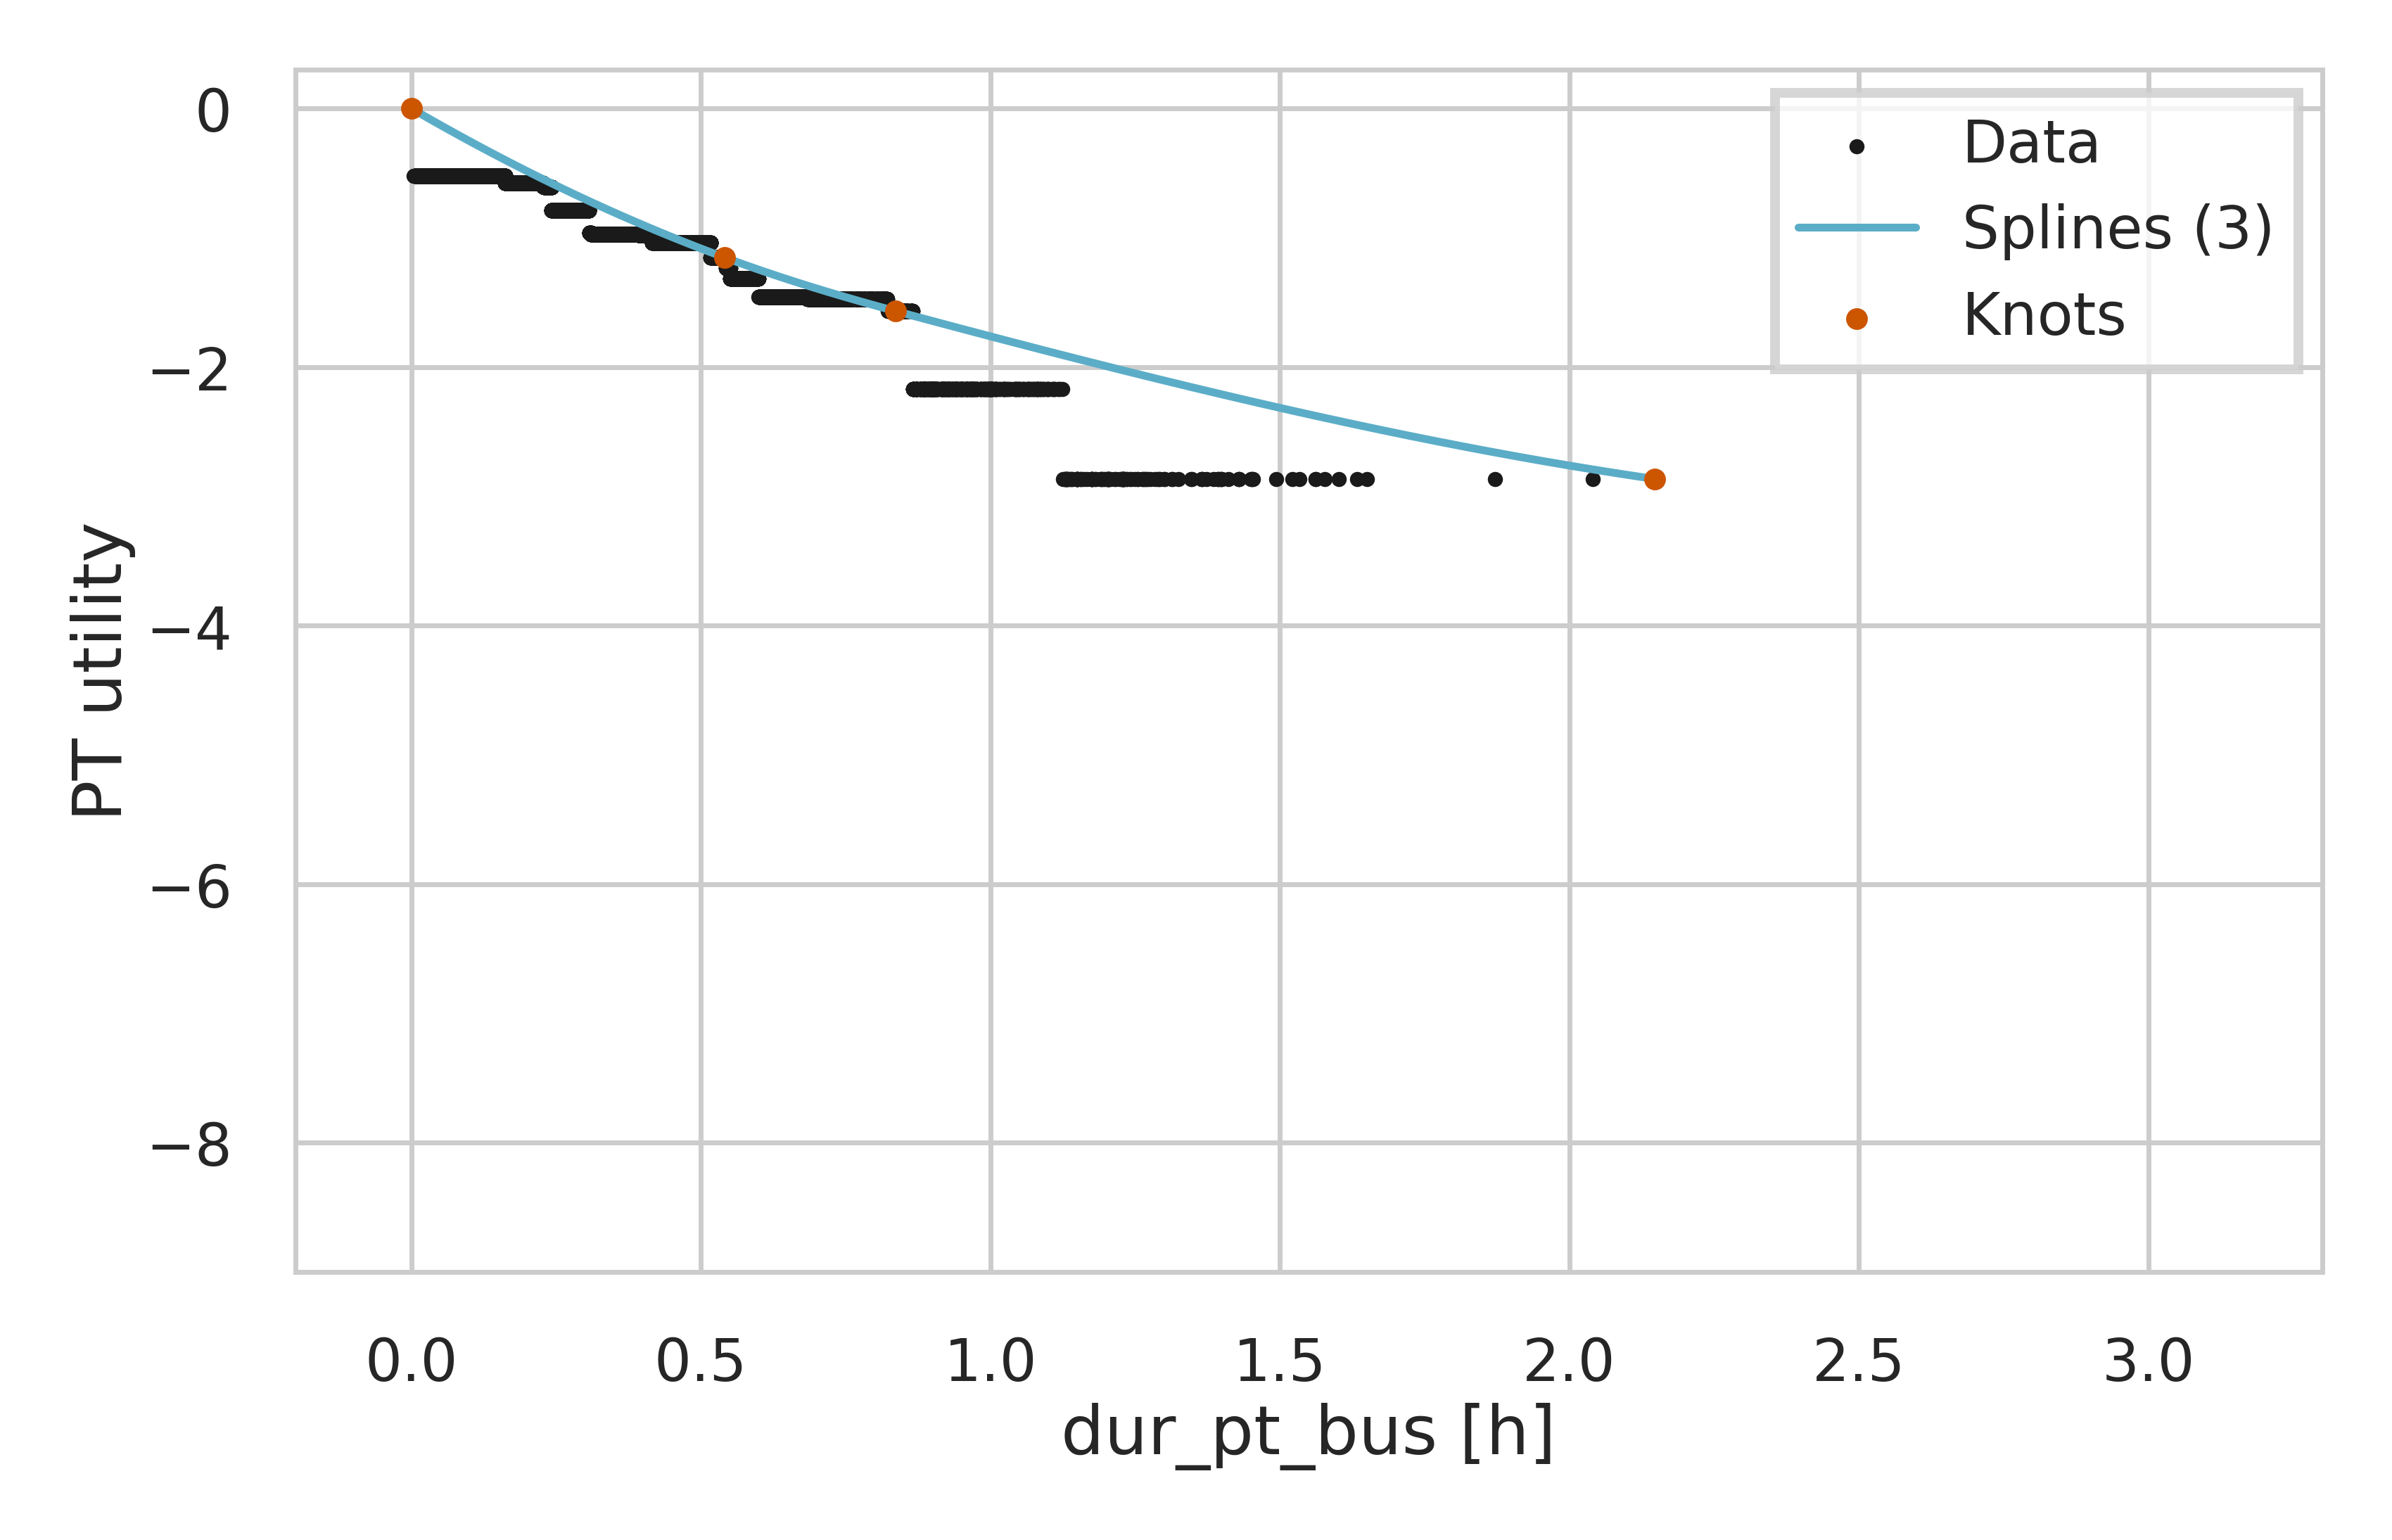

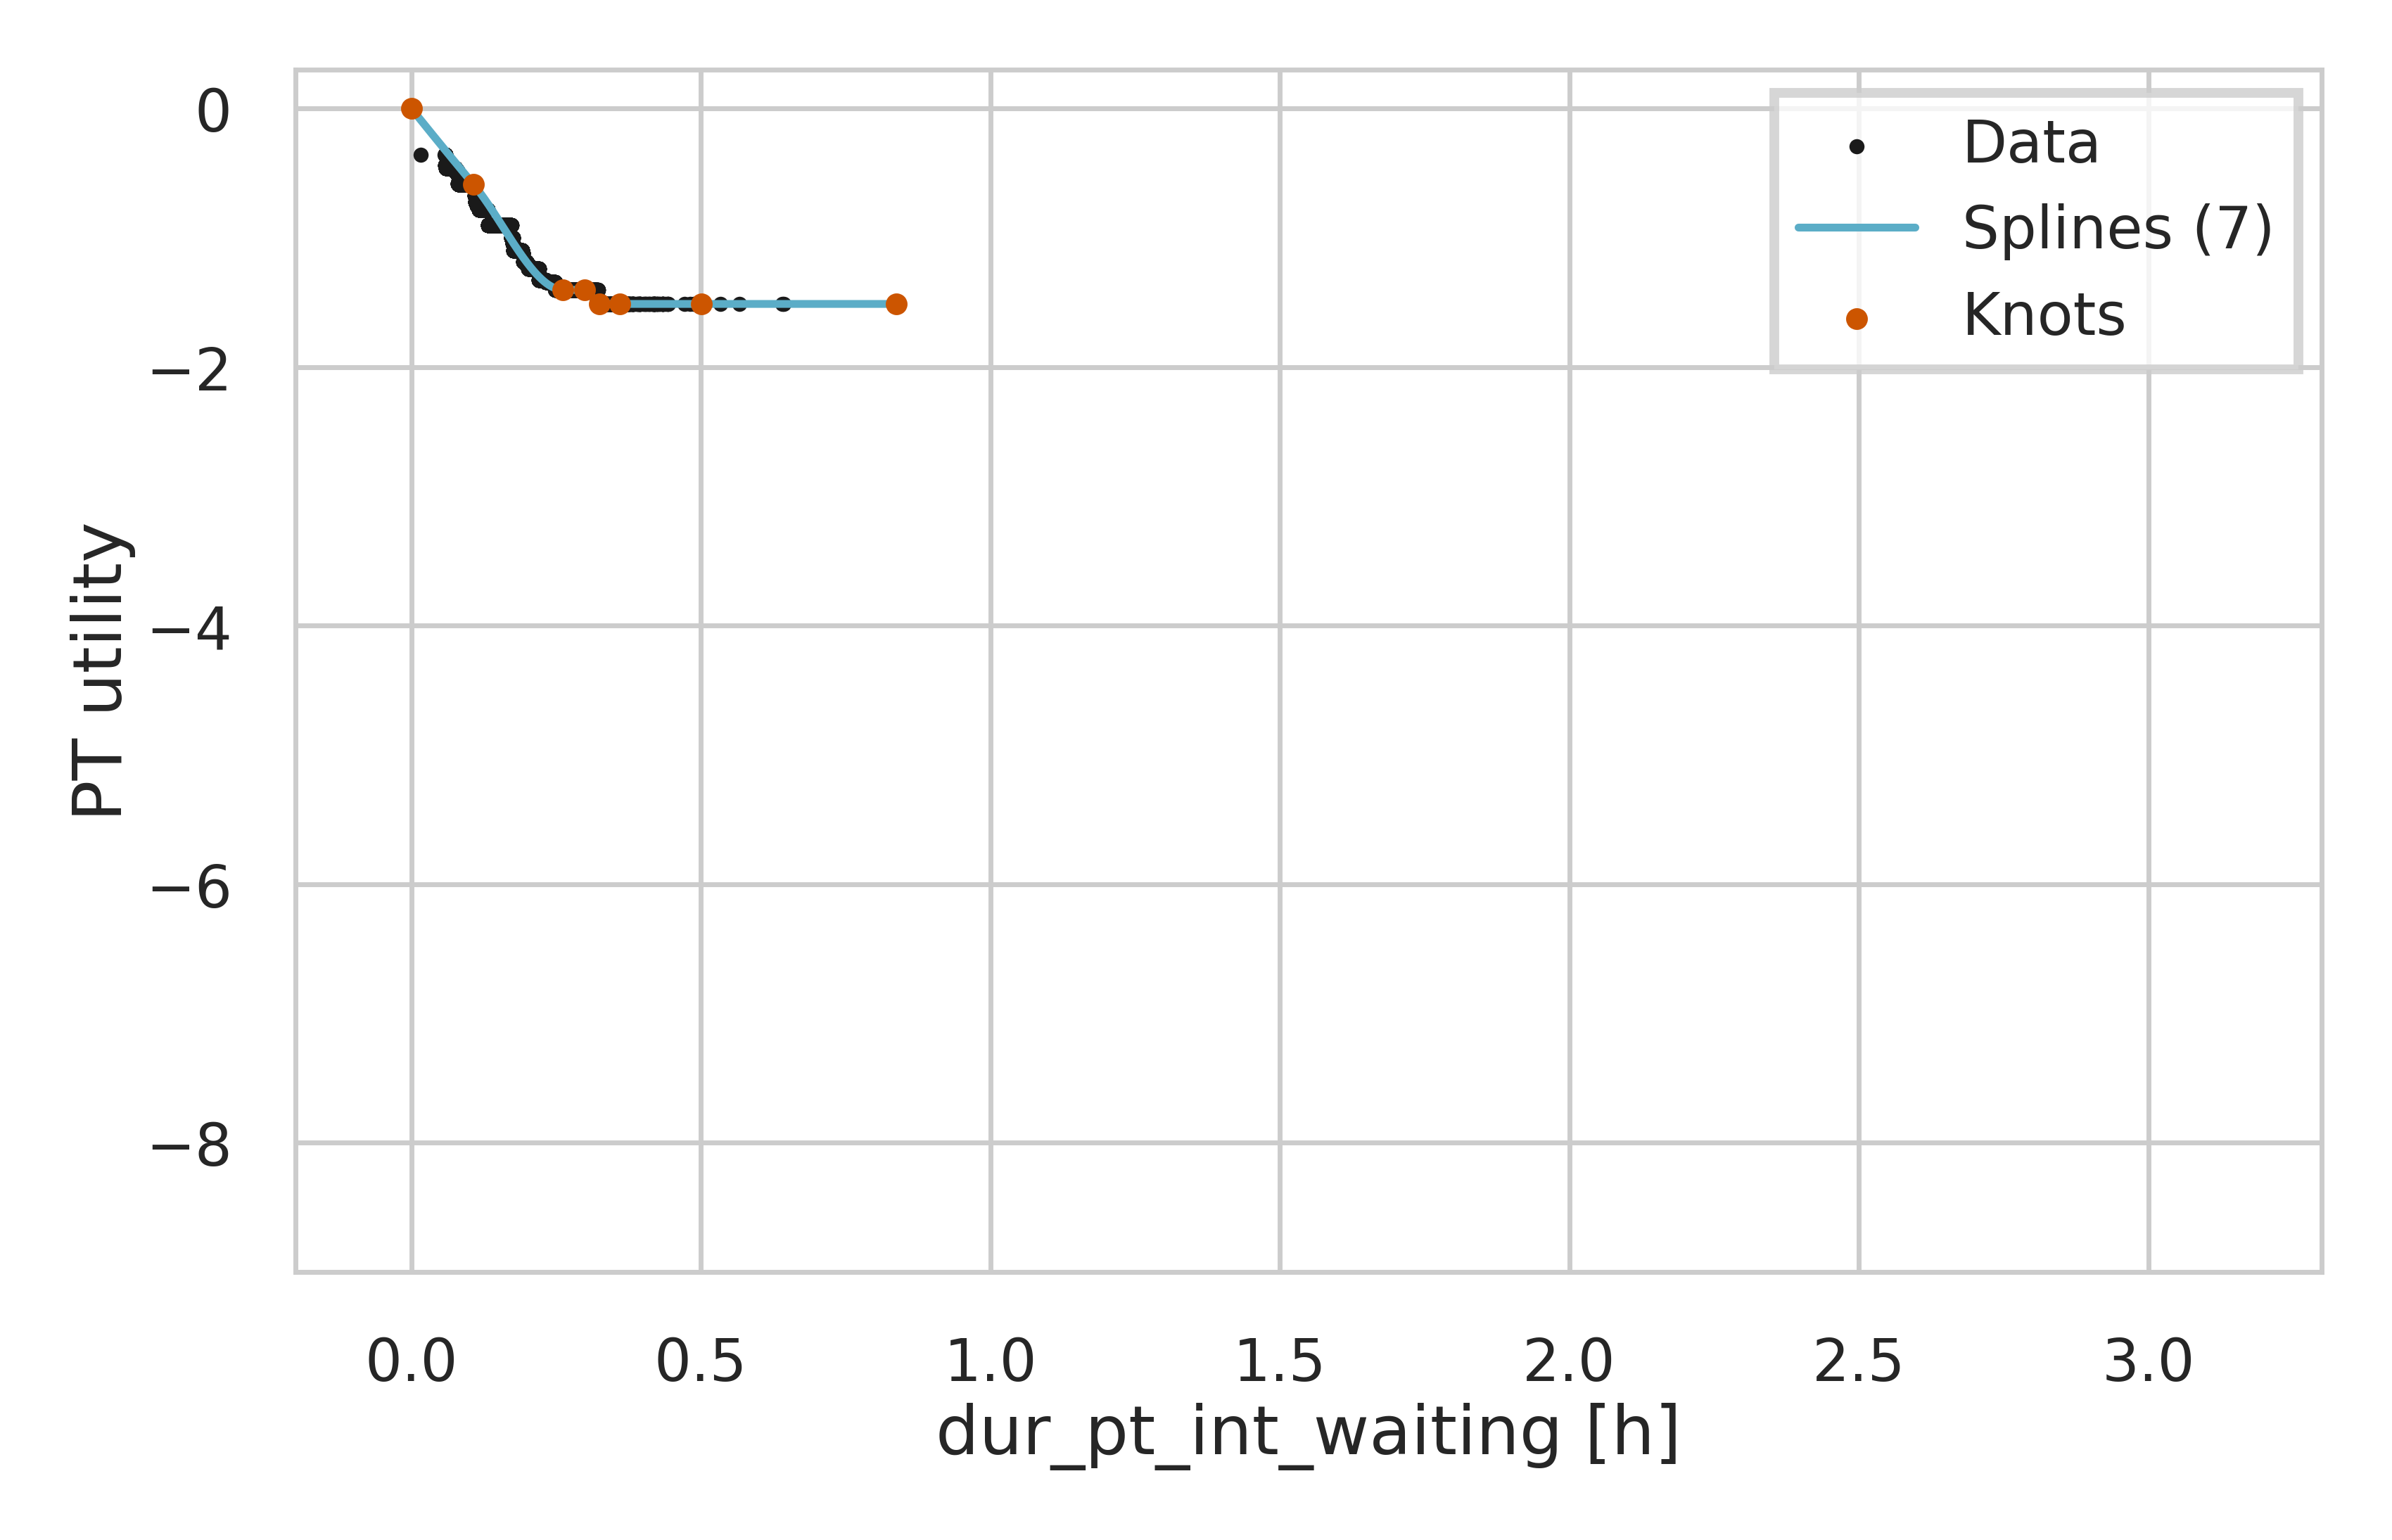

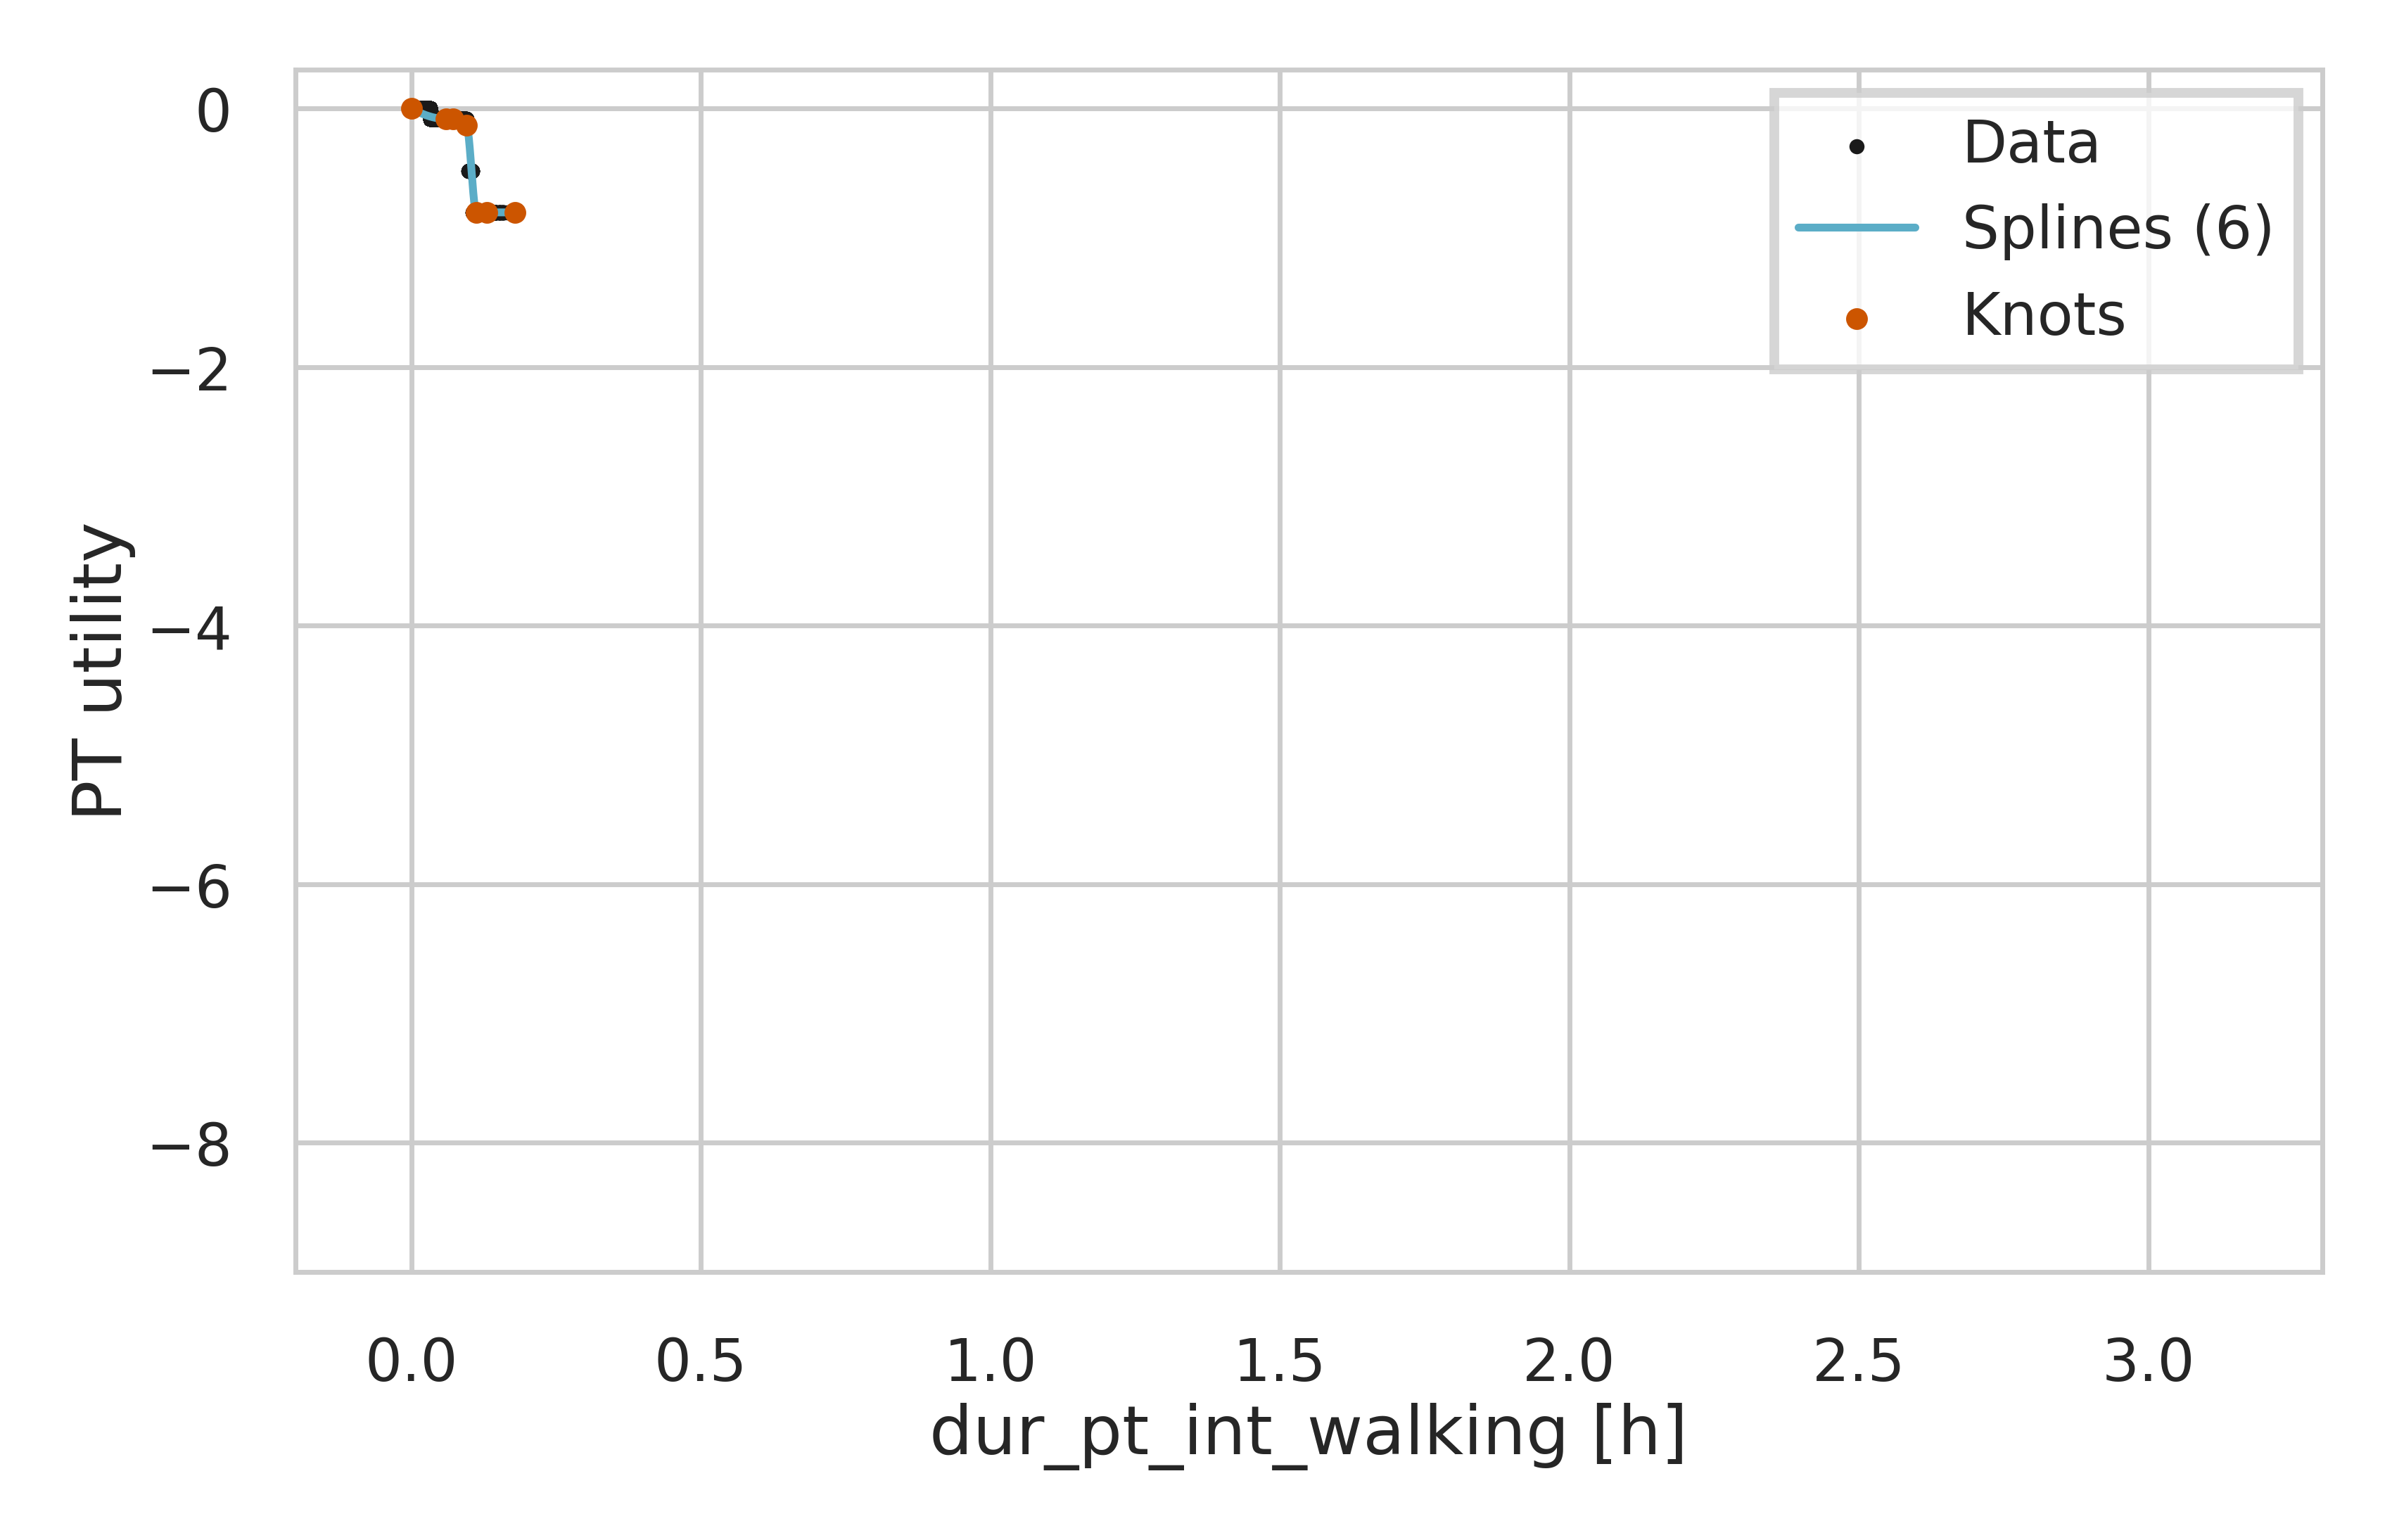

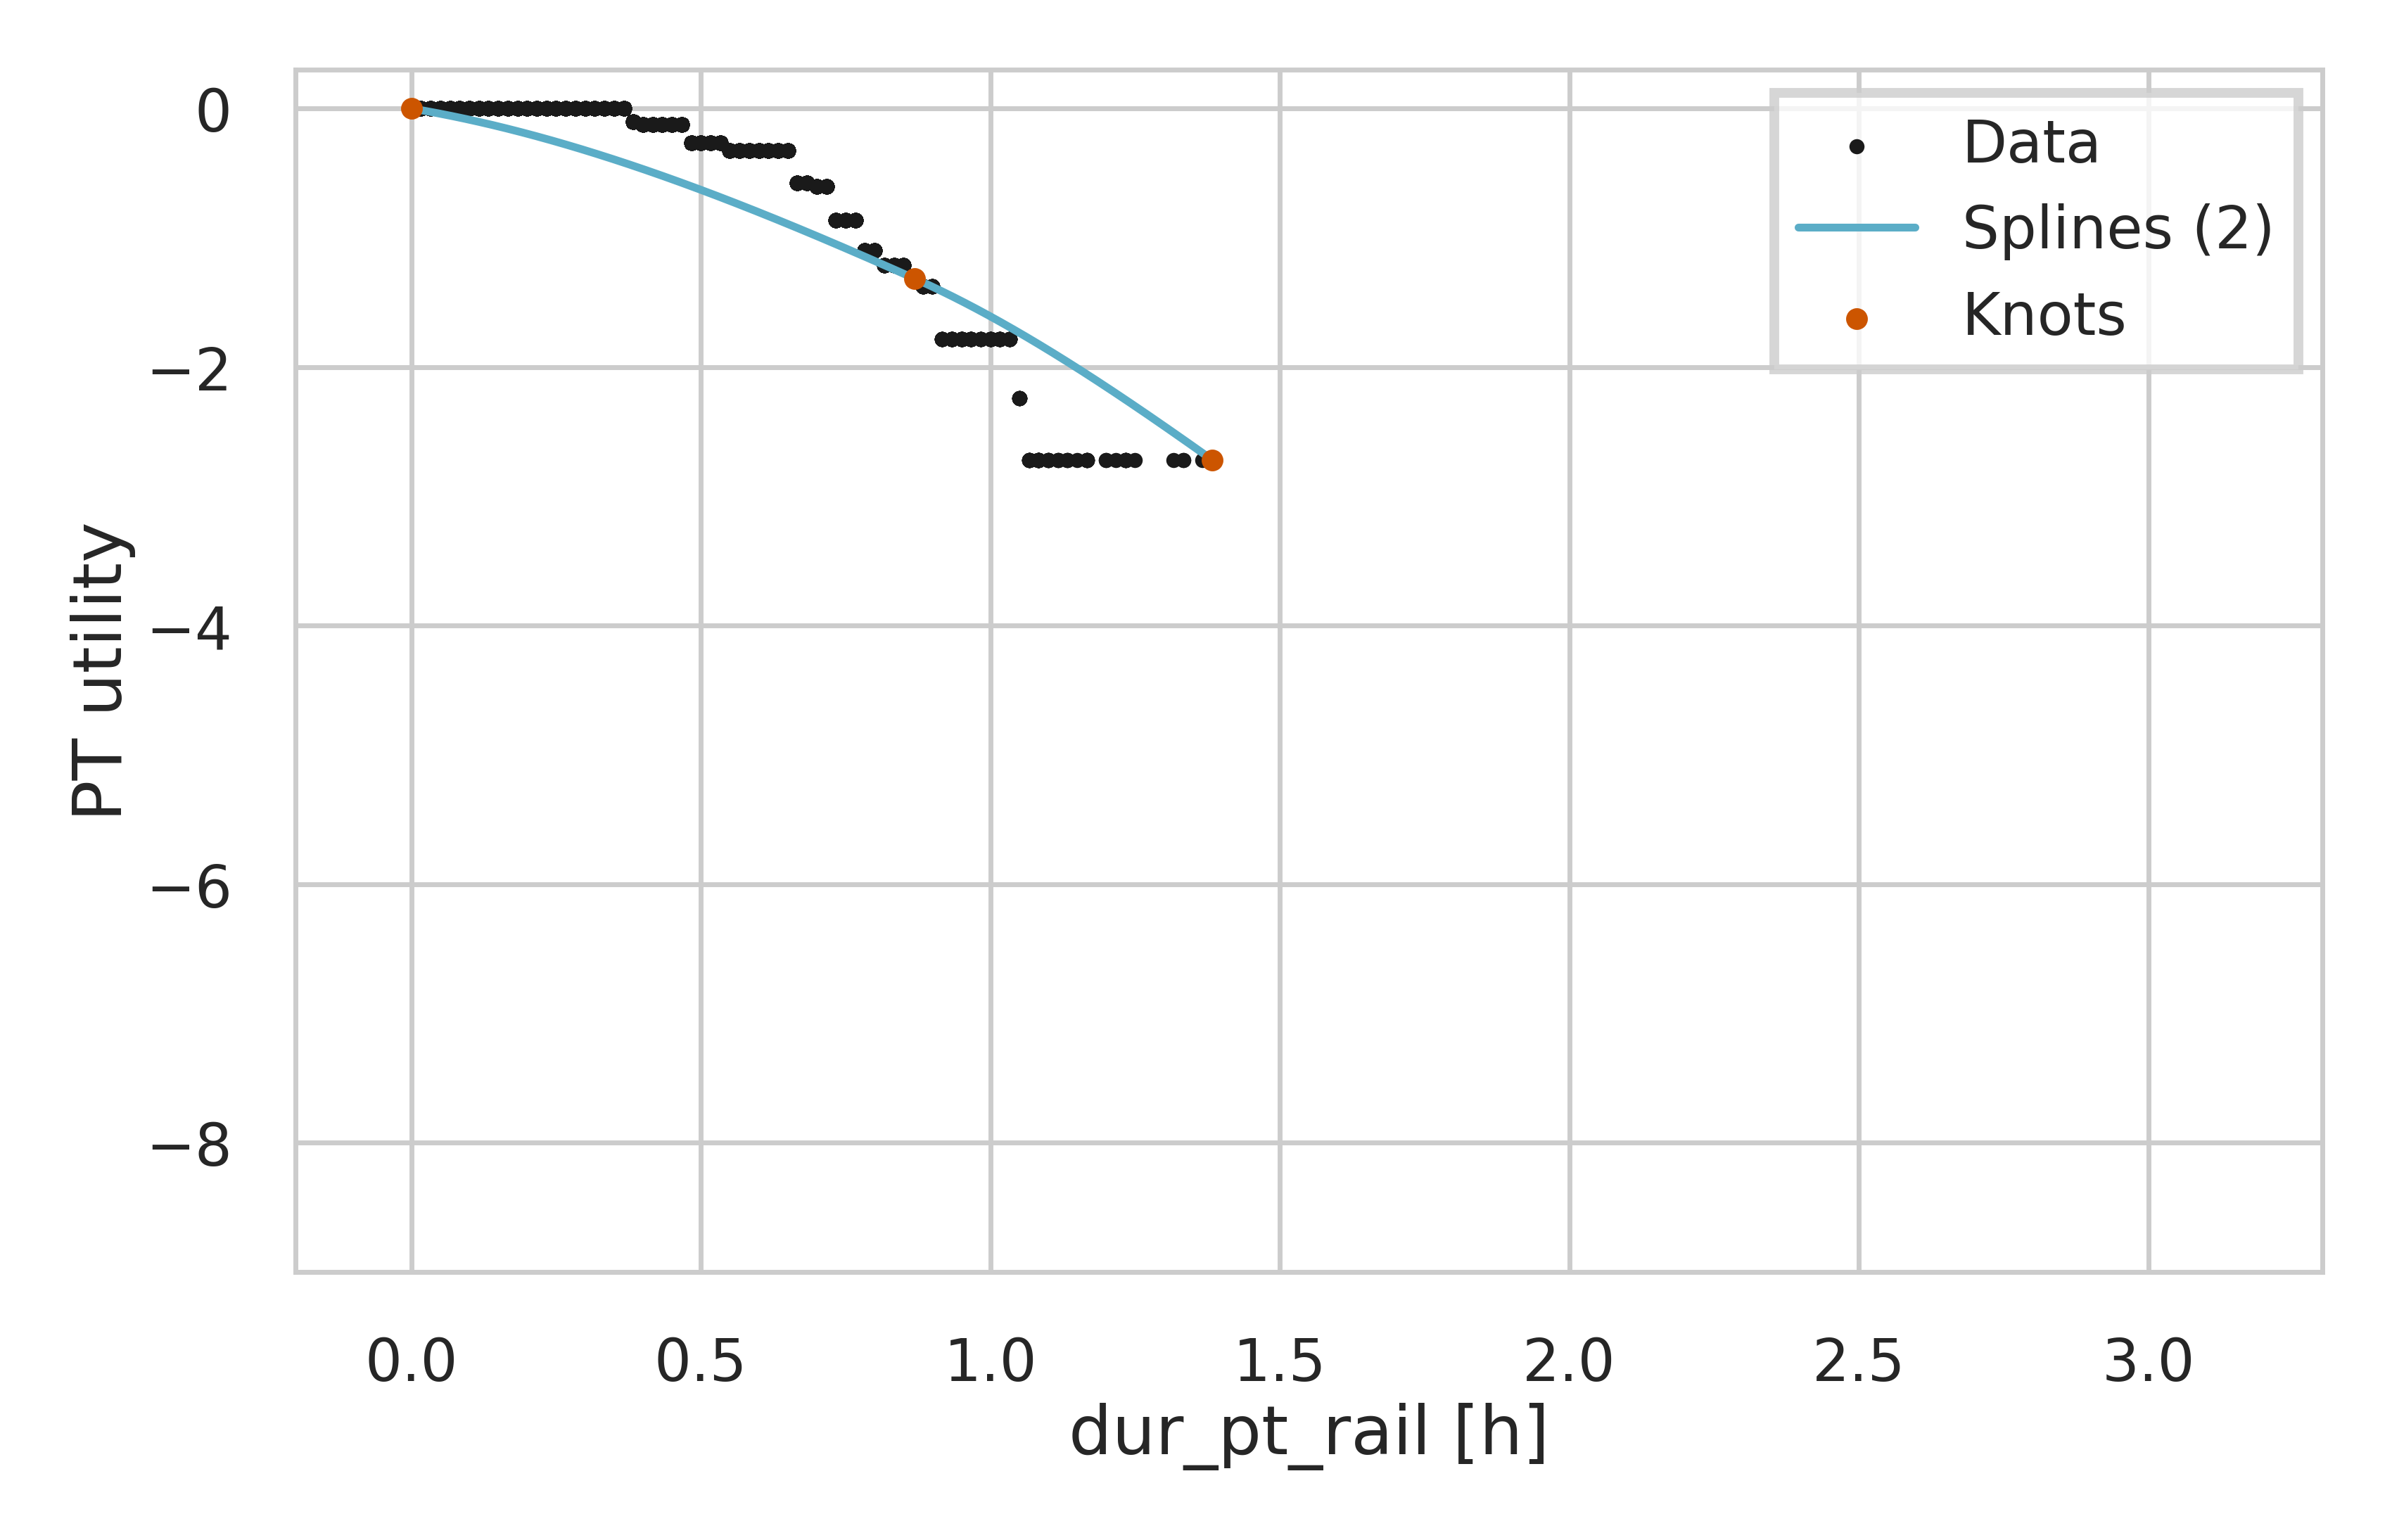

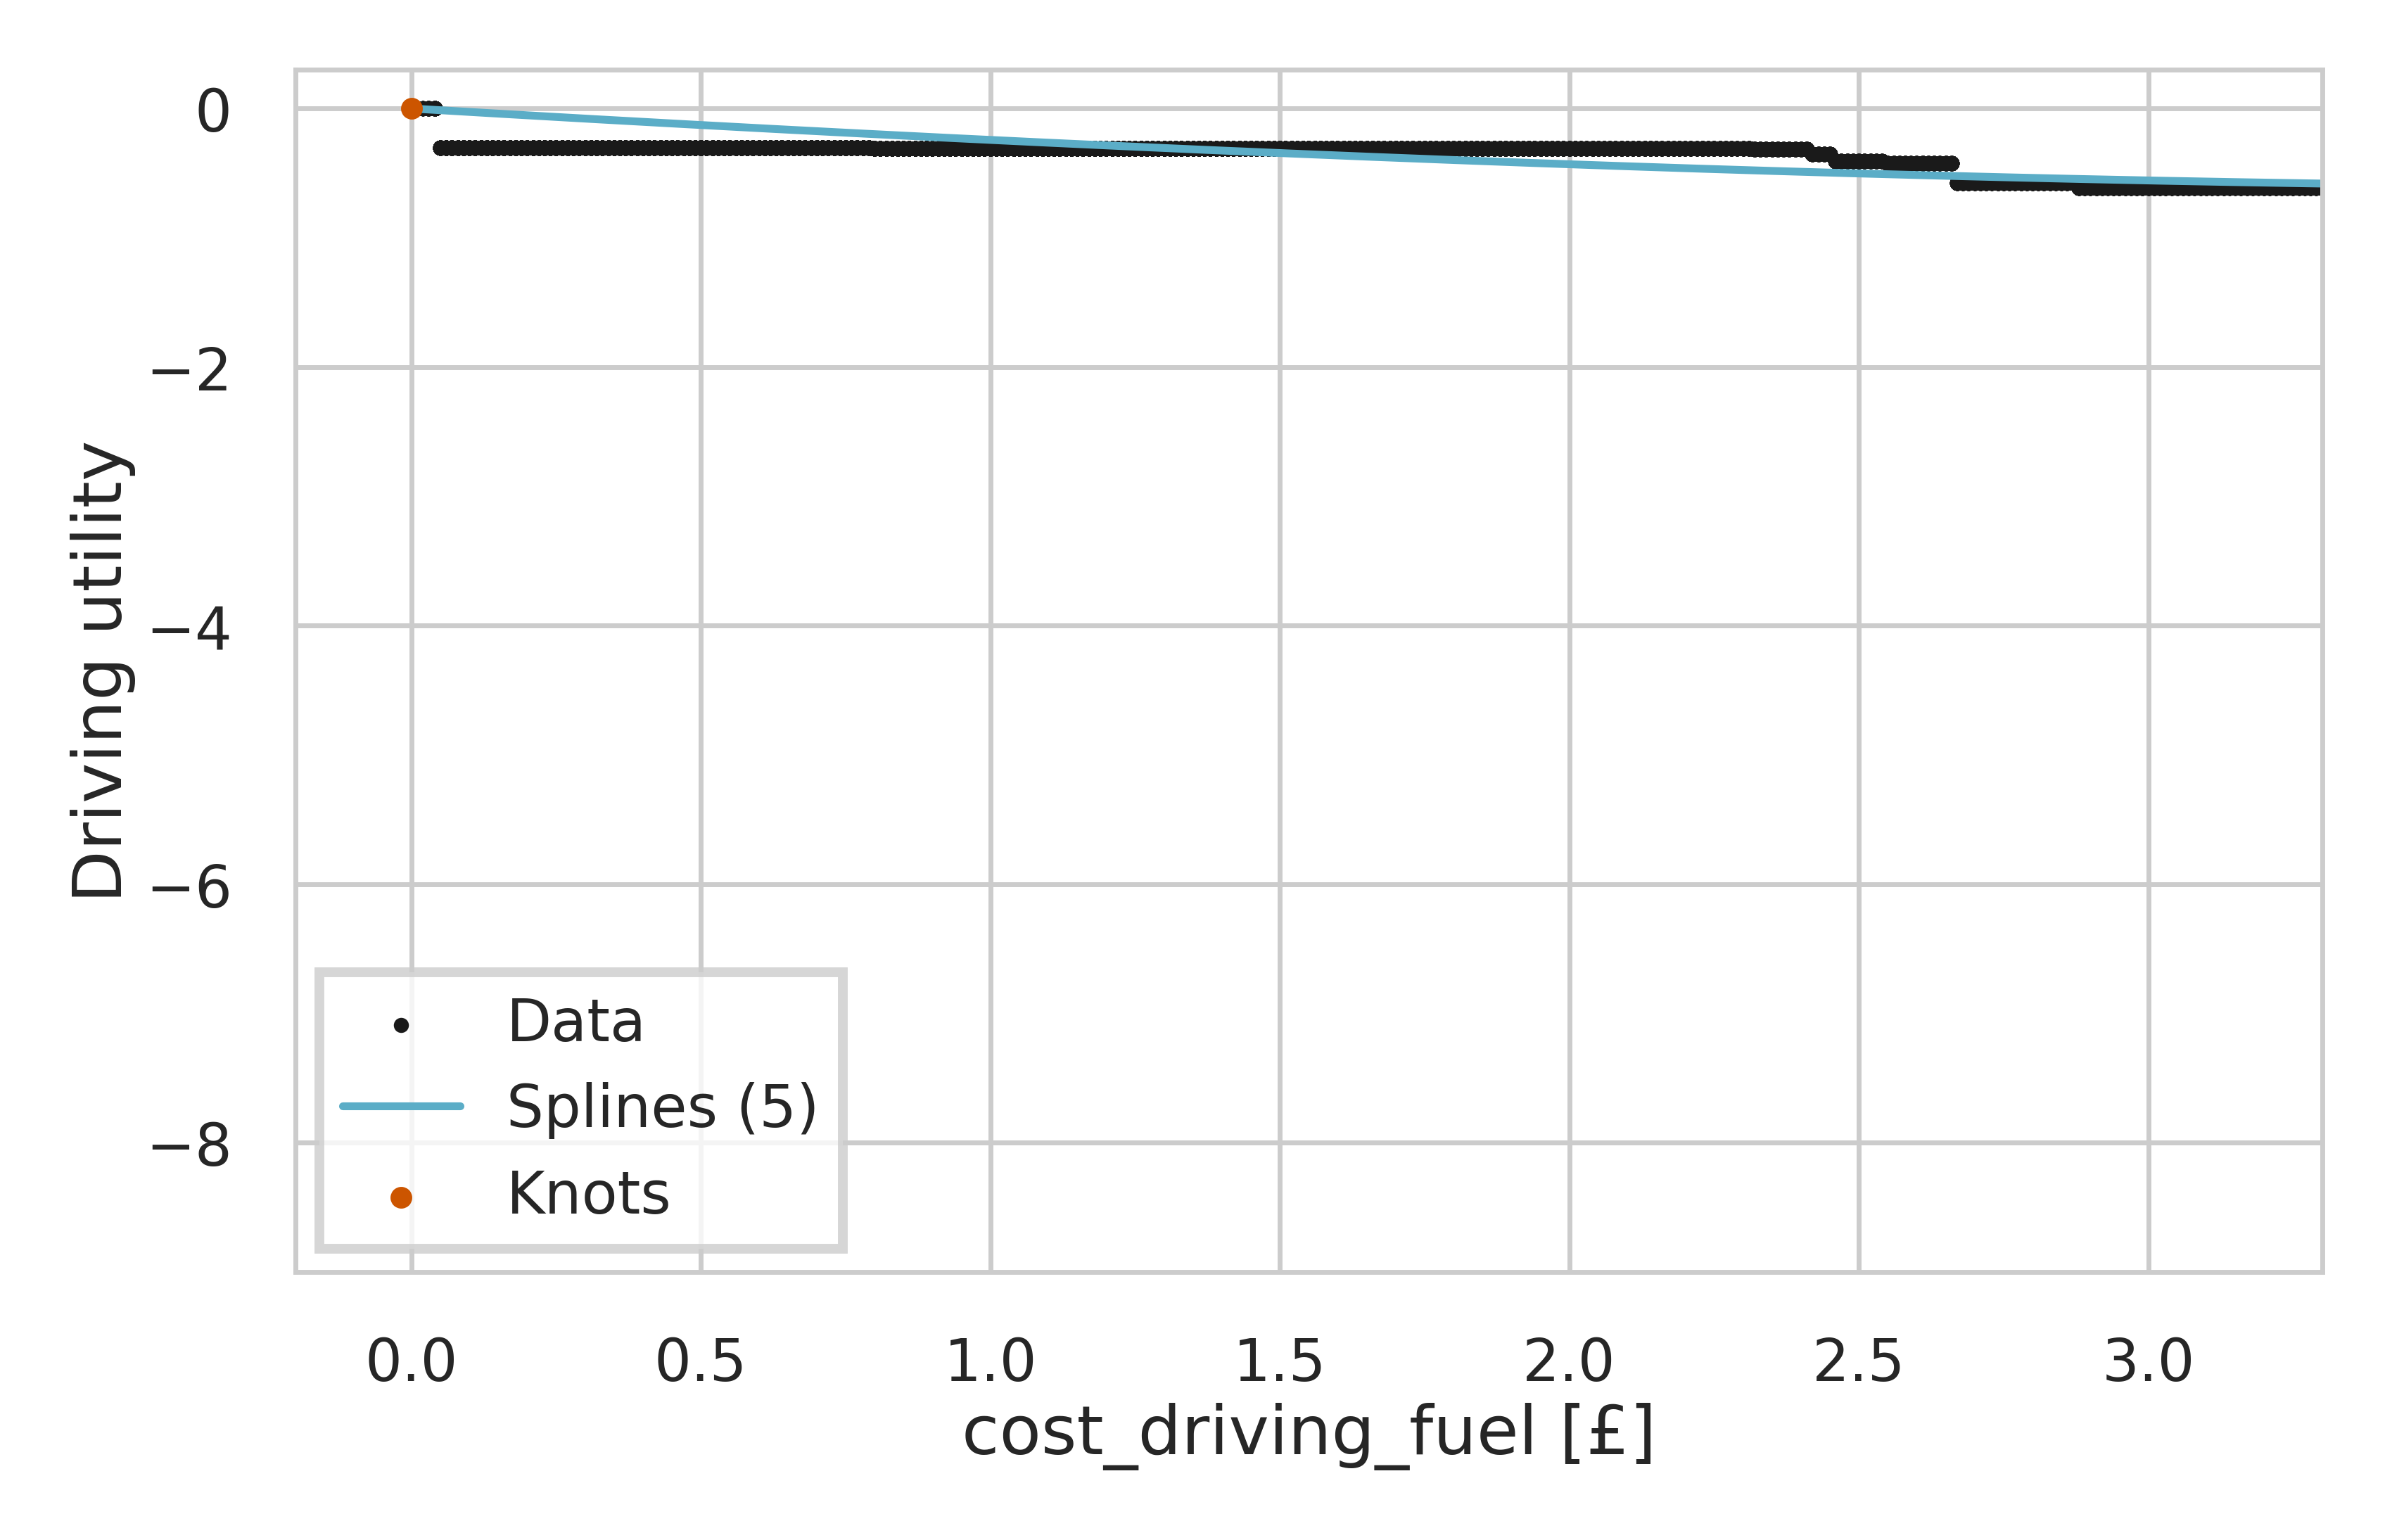

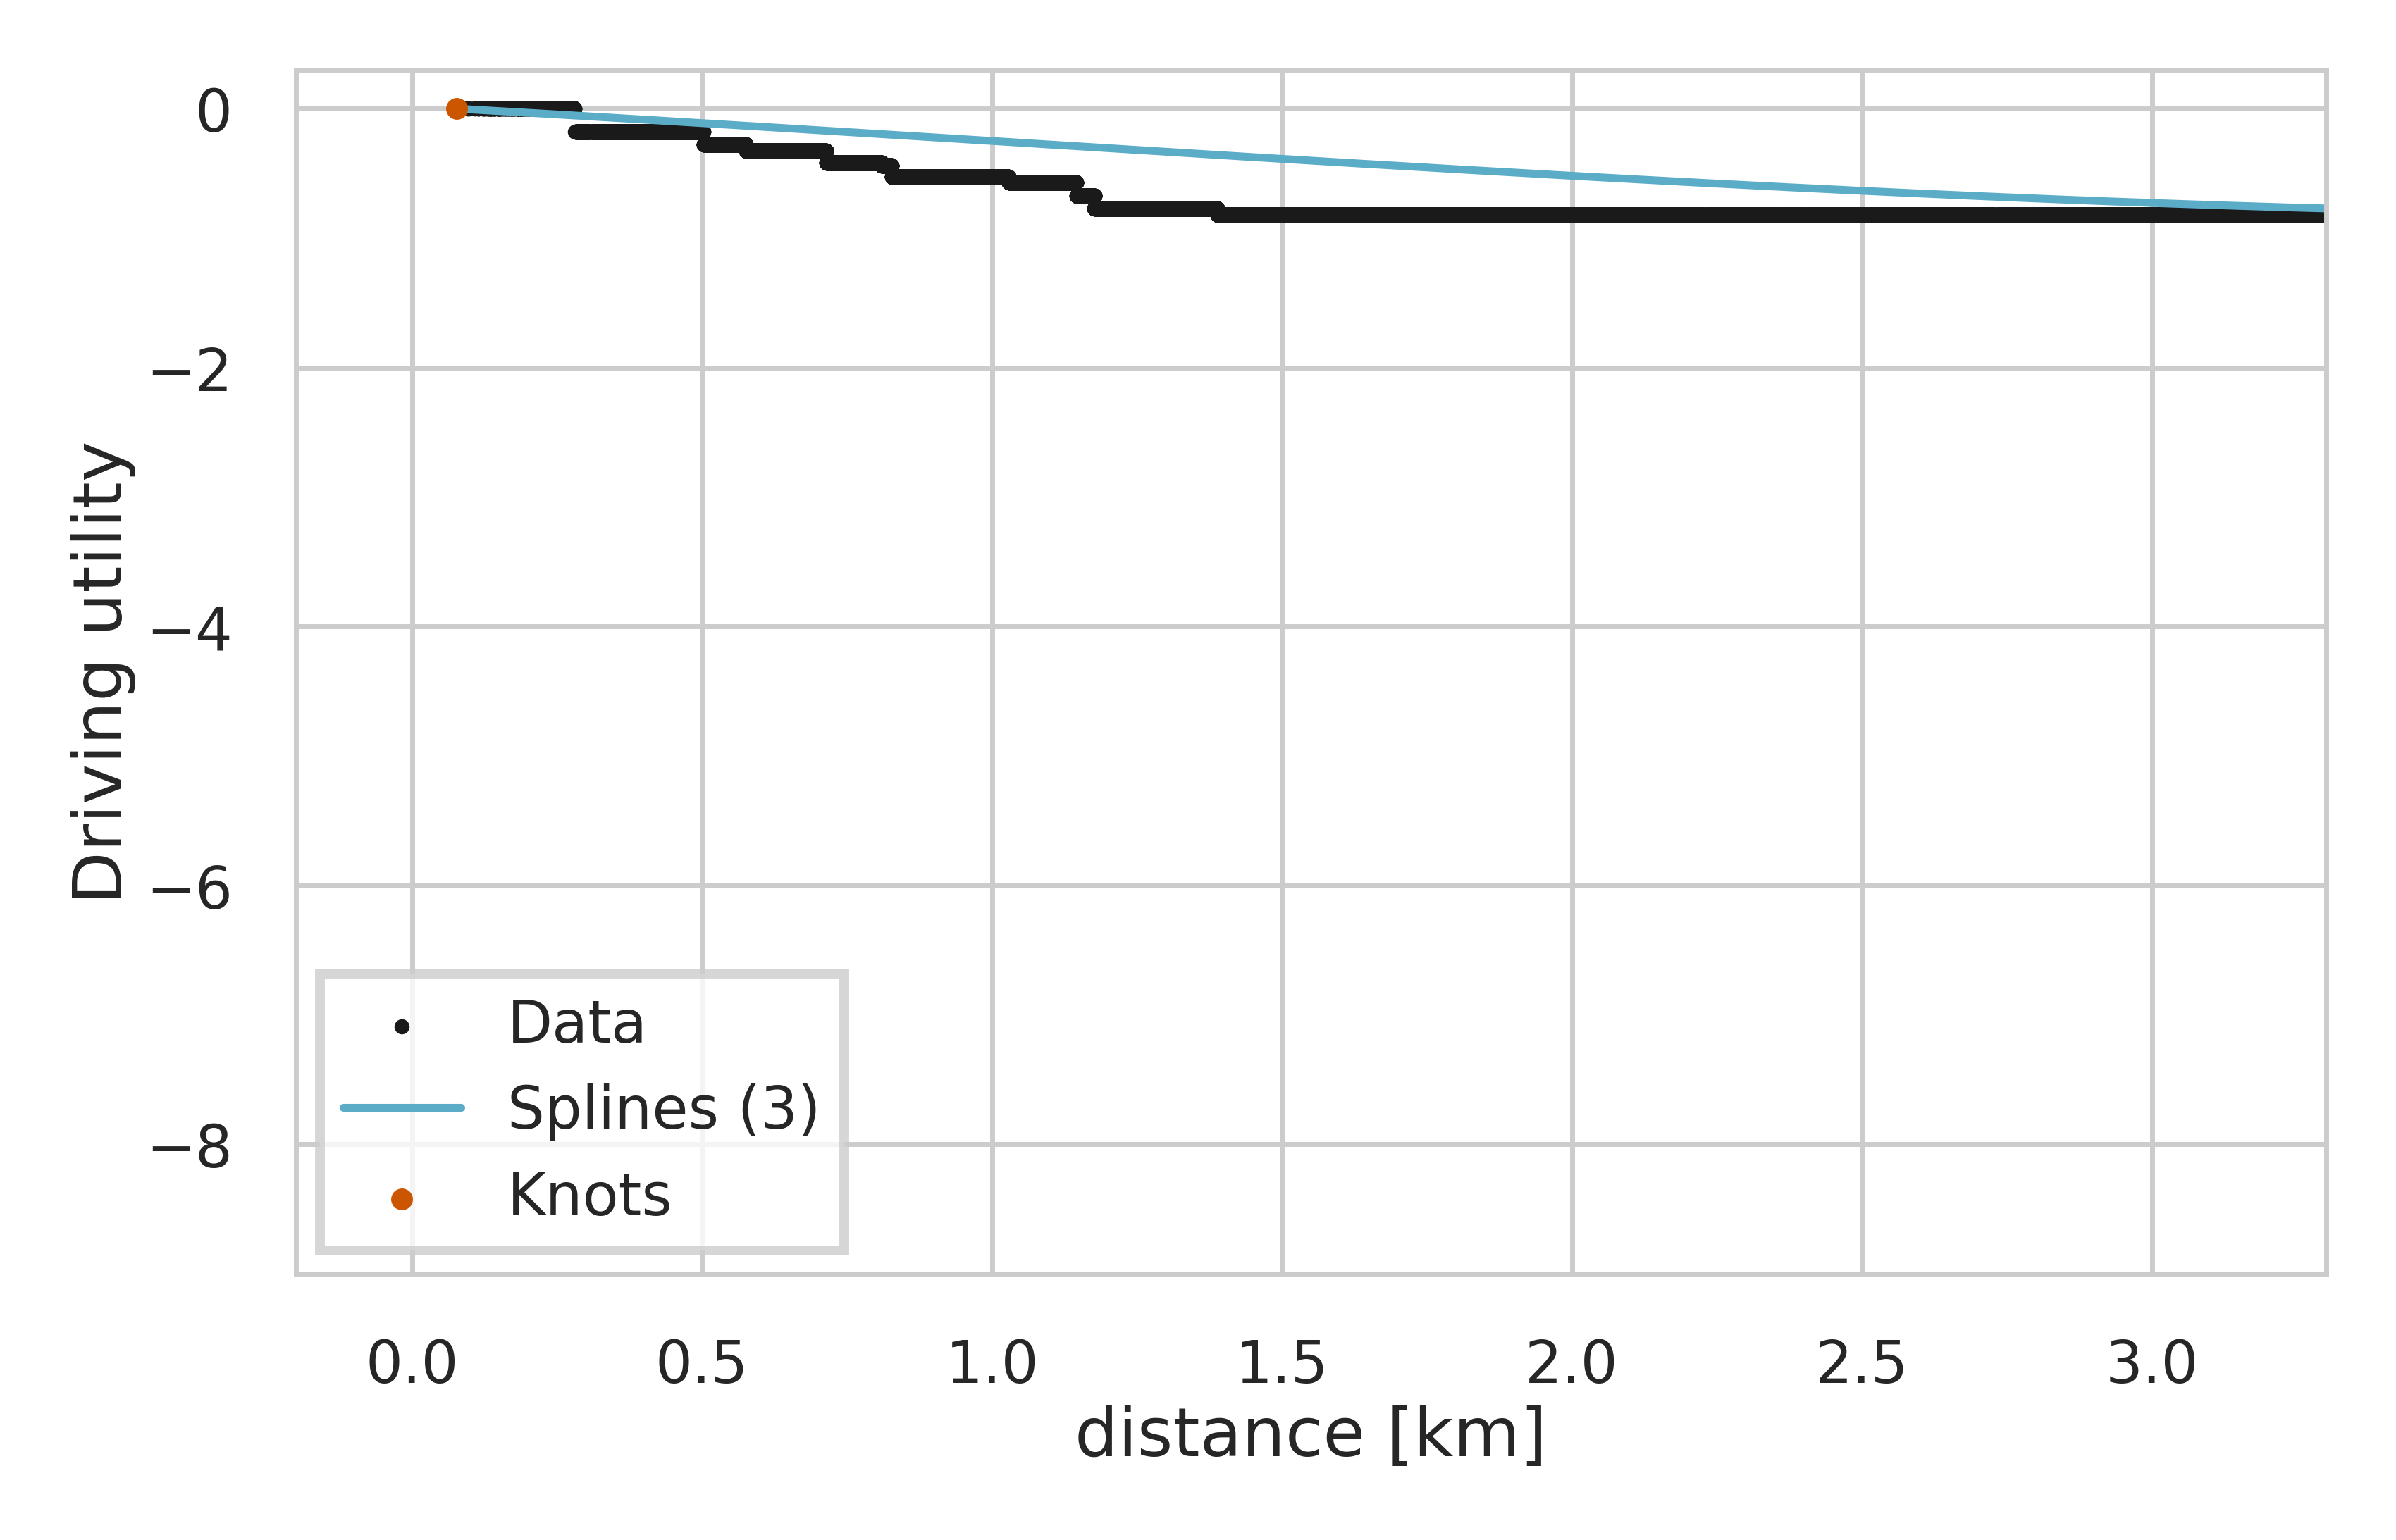

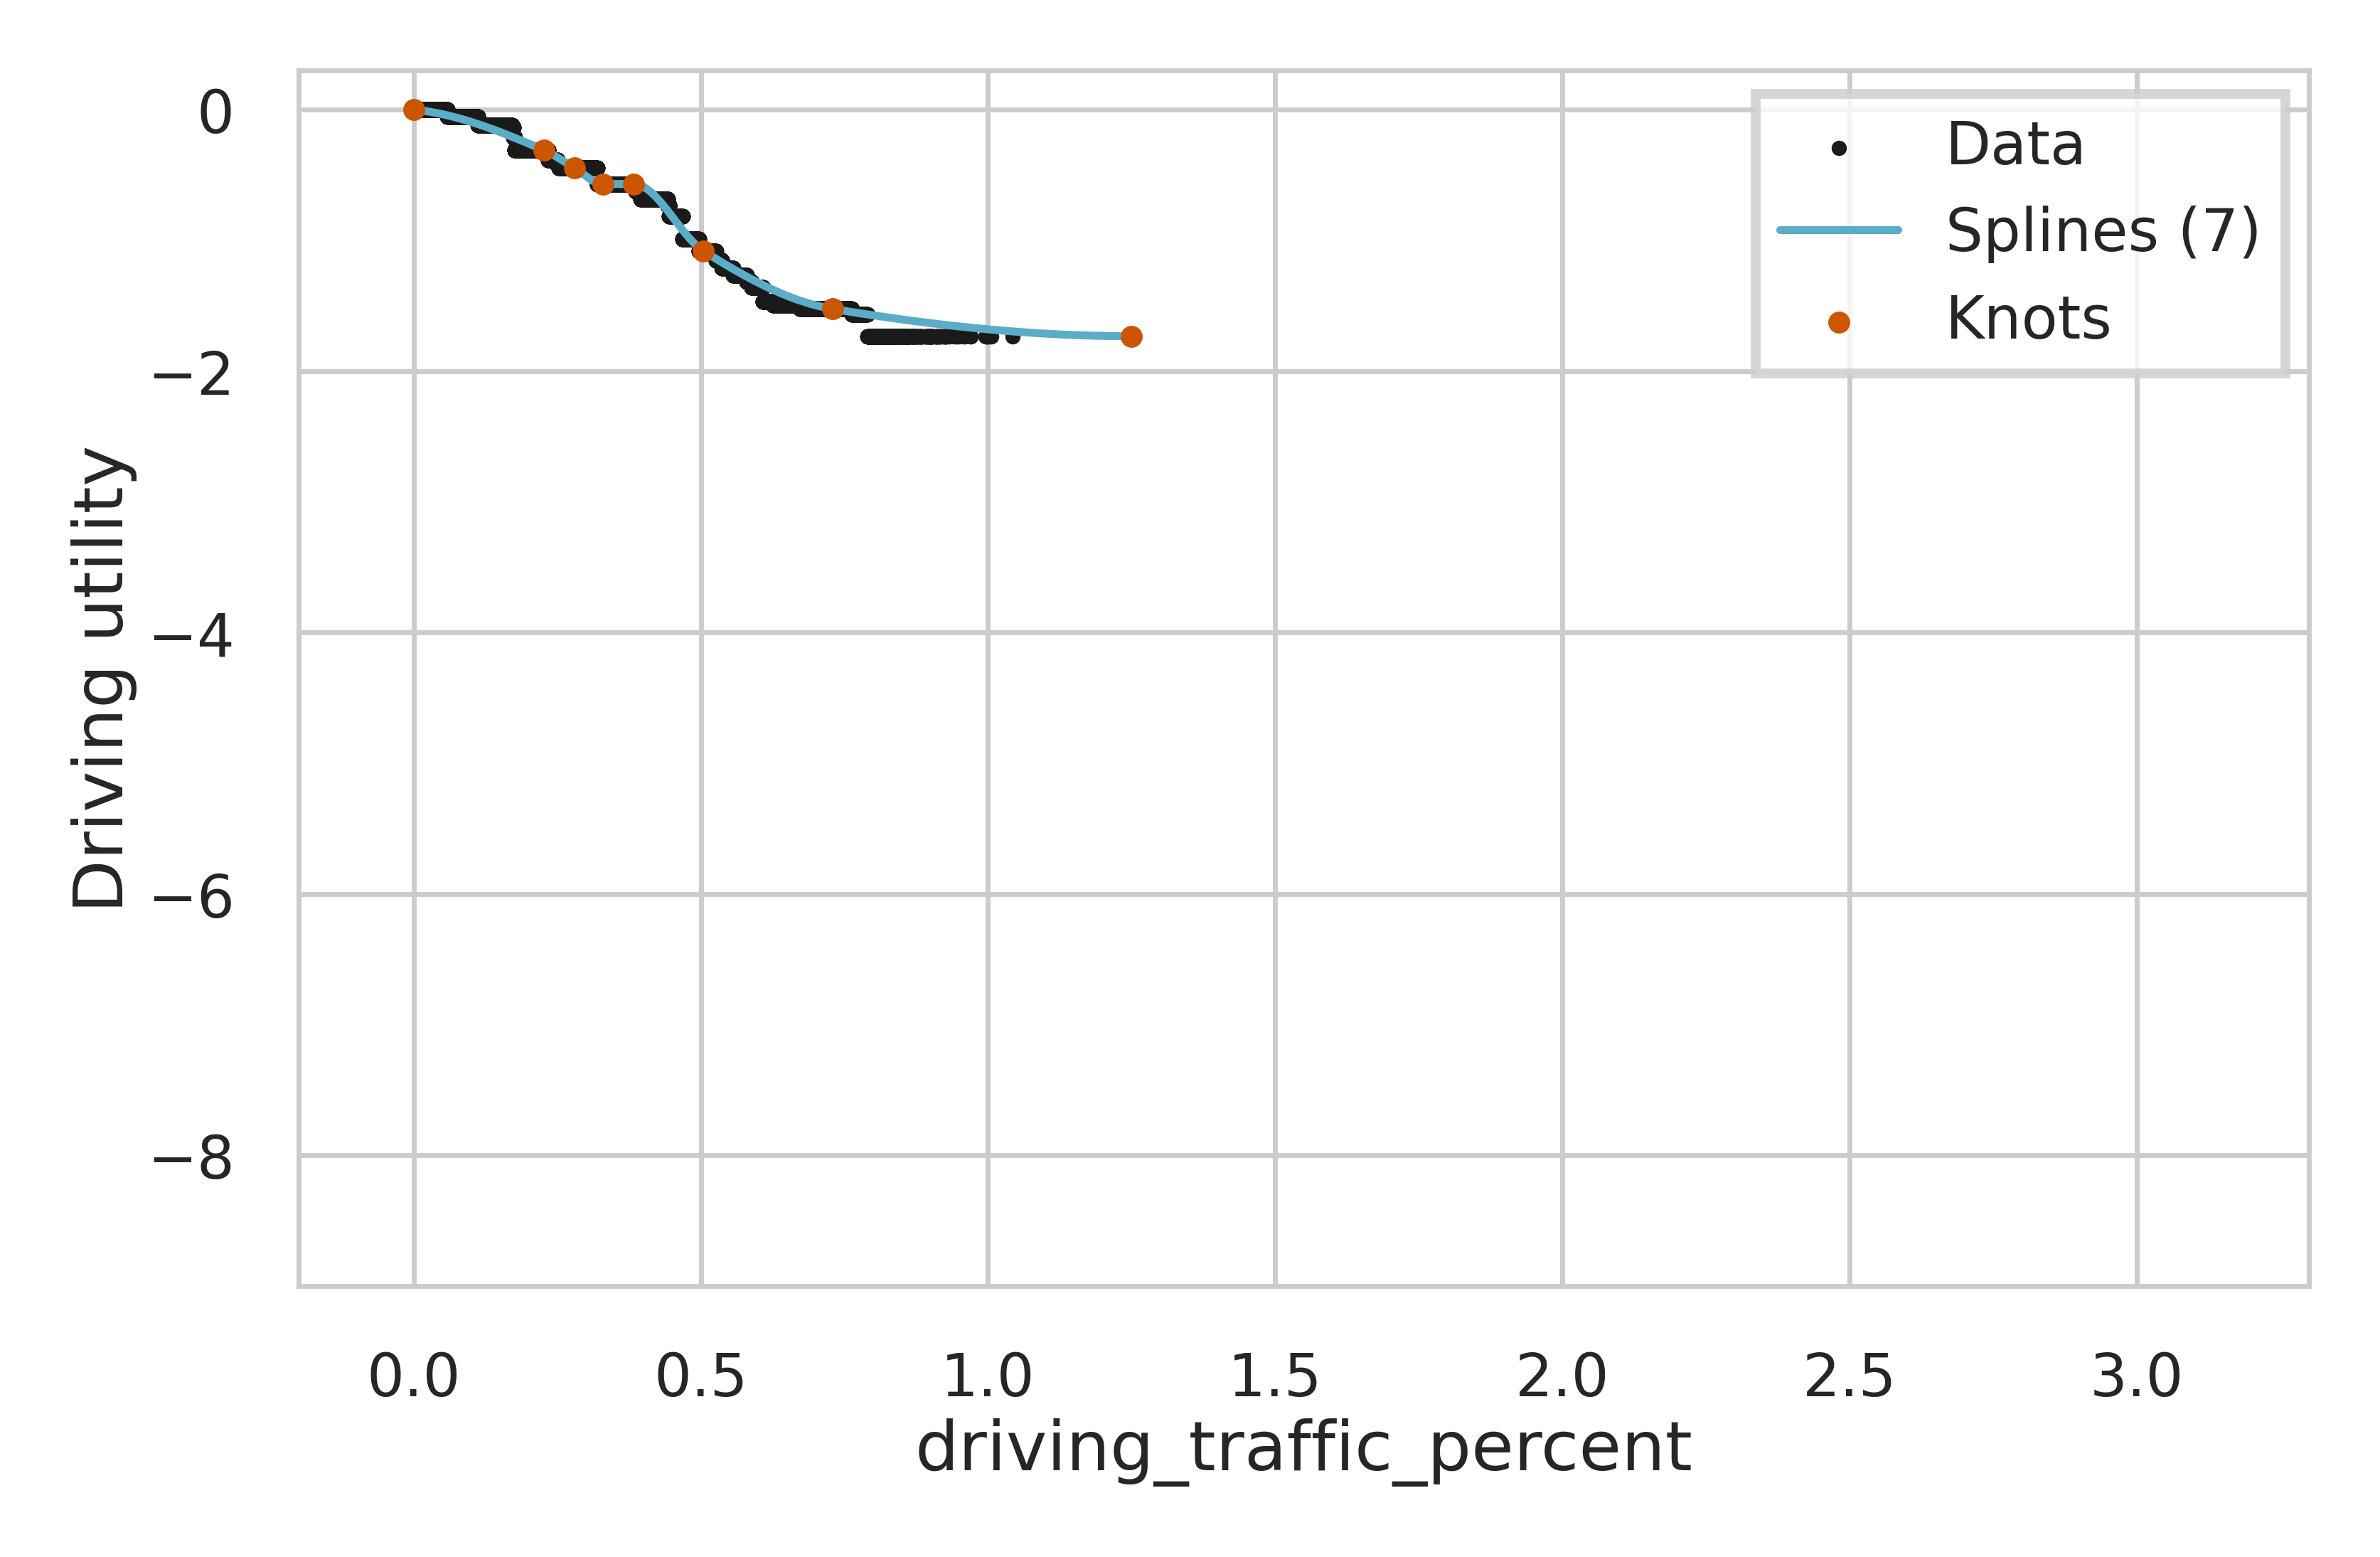

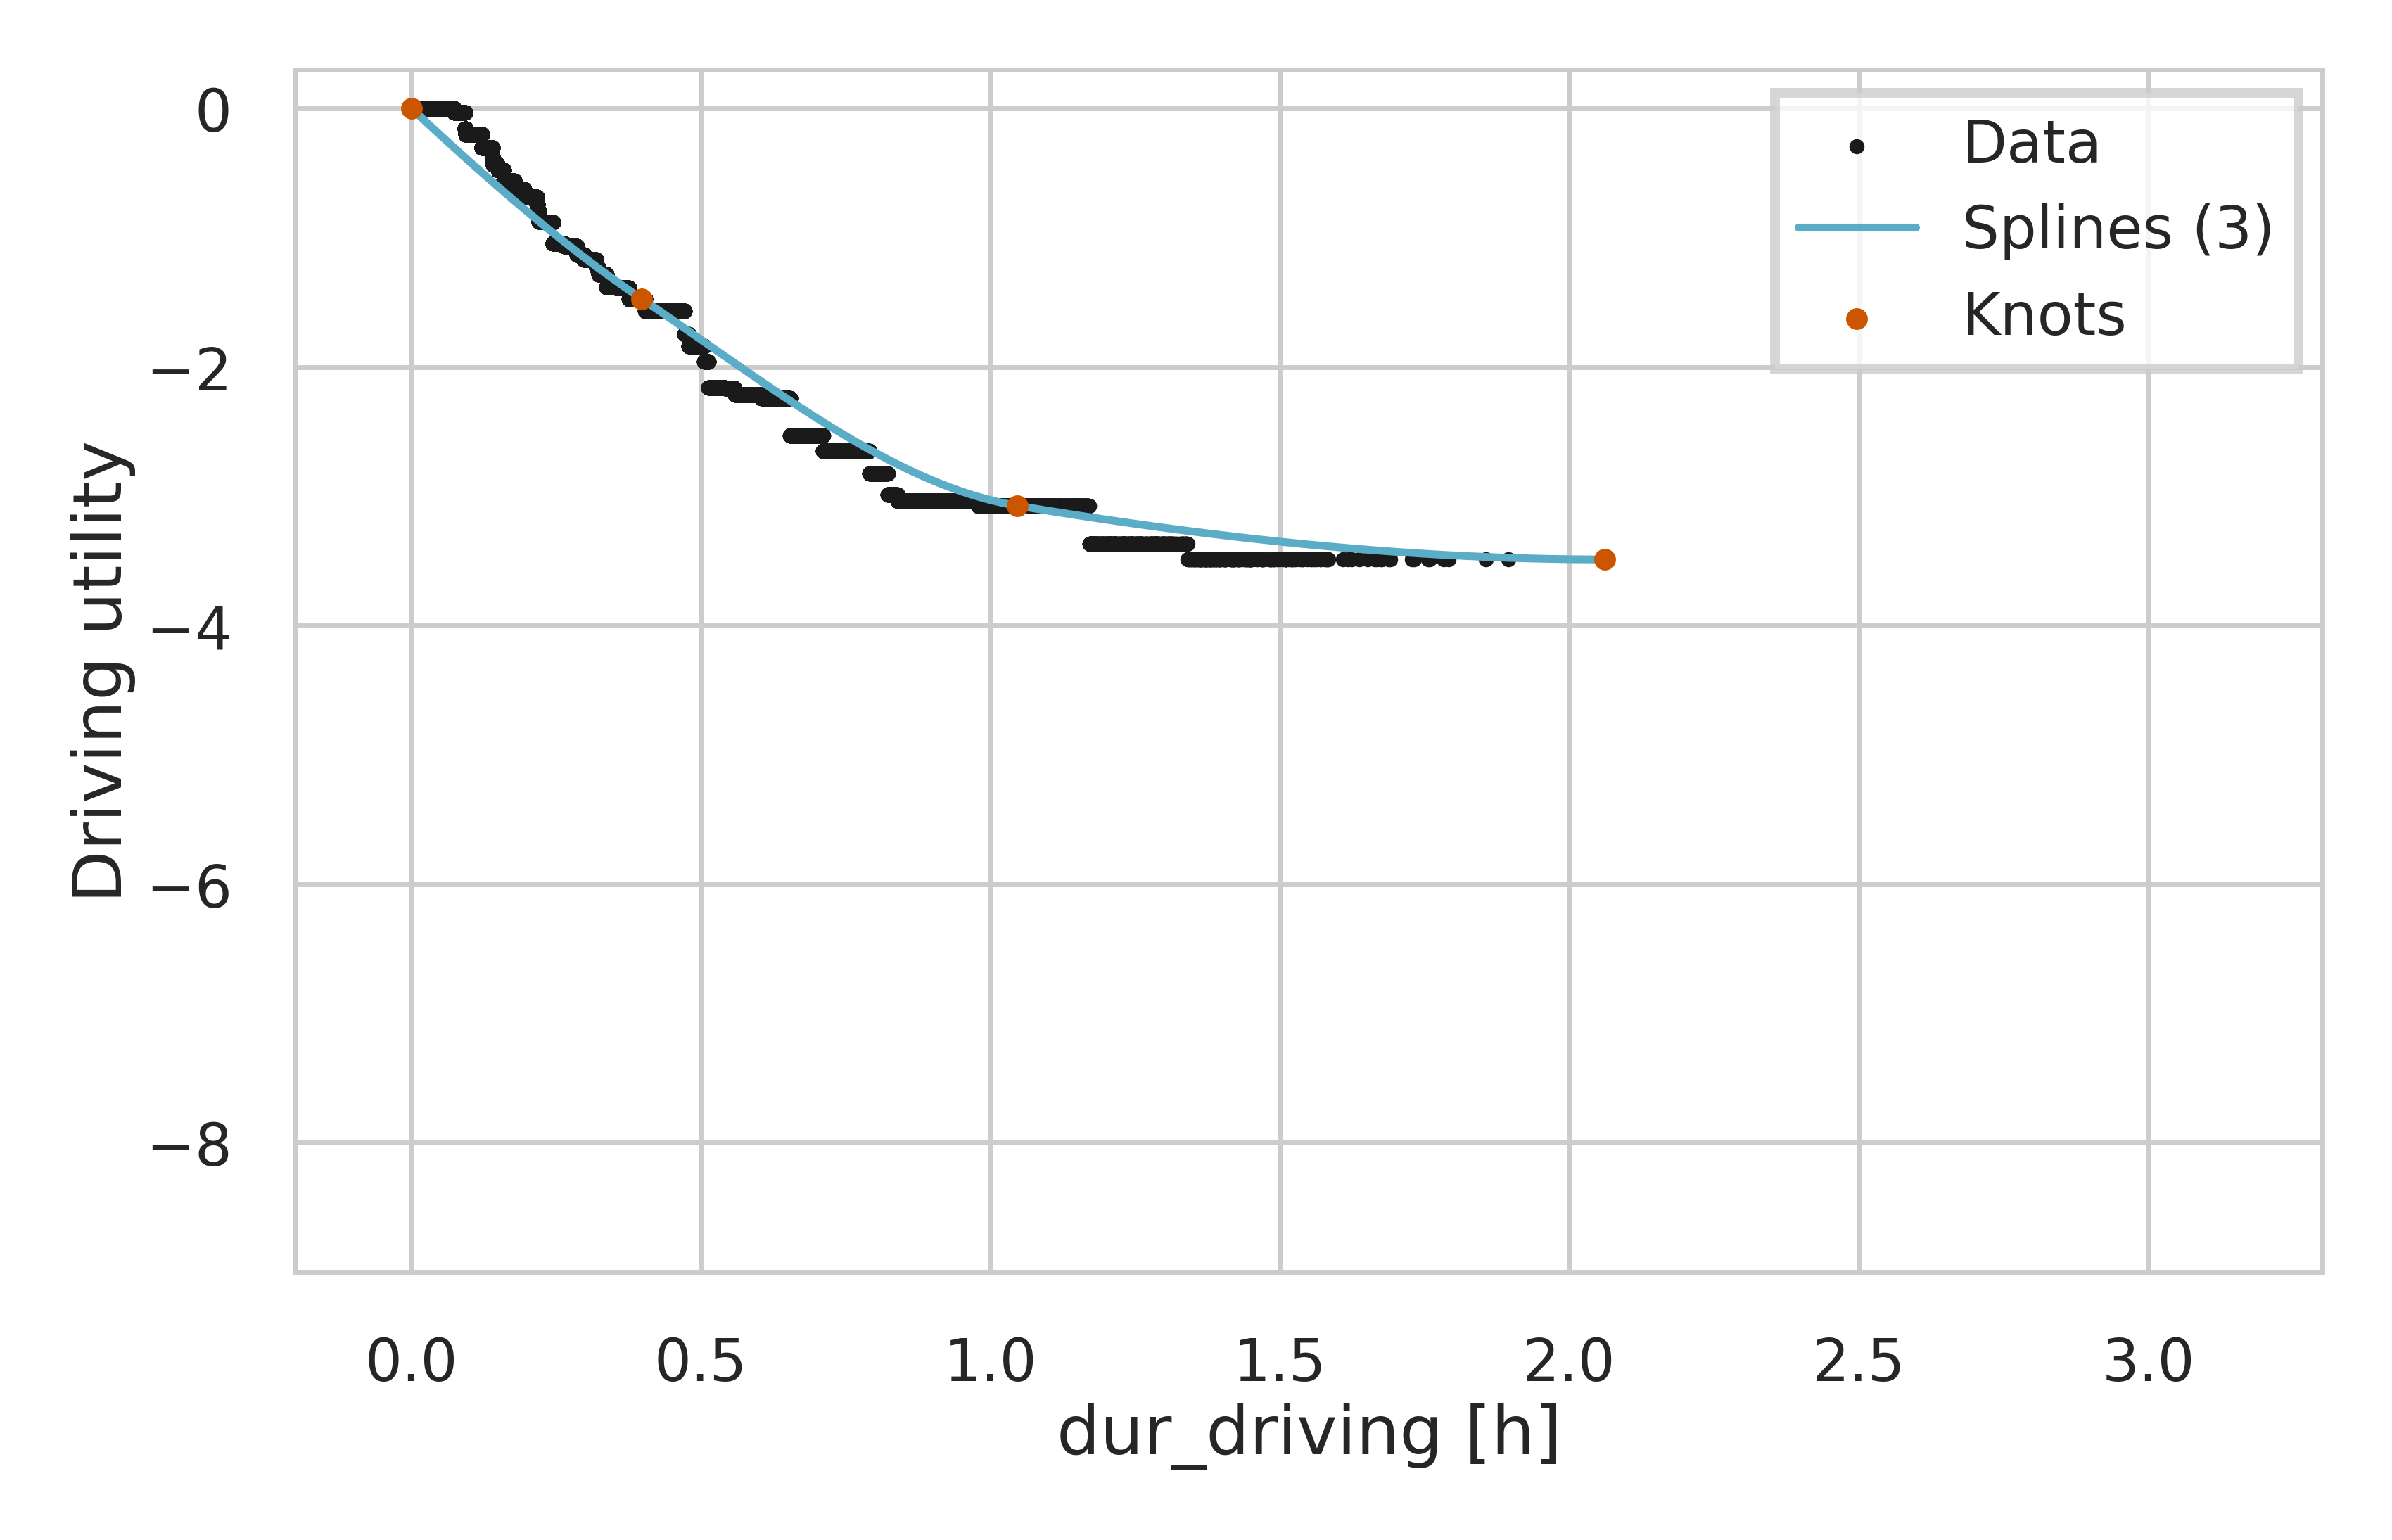

In [32]:
best_splines = spline_collection
utility_names = {'0':'Walking', '1':'Cycling', '2':'PT', '3':'Driving'}
plot_spline(LPMC_model_fully_trained,LPMC_train,best_splines, utility_names, x_knots_dict=x_knots_dict, lpmc_tt_cost=True)

## Plotting the value of time

Using the smoothed utility functions, we can compute the value of time for the population, and per attributes. The results vary slightly from the paper du to the differences in the optimisation process.

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/utility_plotting.py:1466: UserWarning: linewidths is ignored by contourf
  c_plot = axes.contourf(


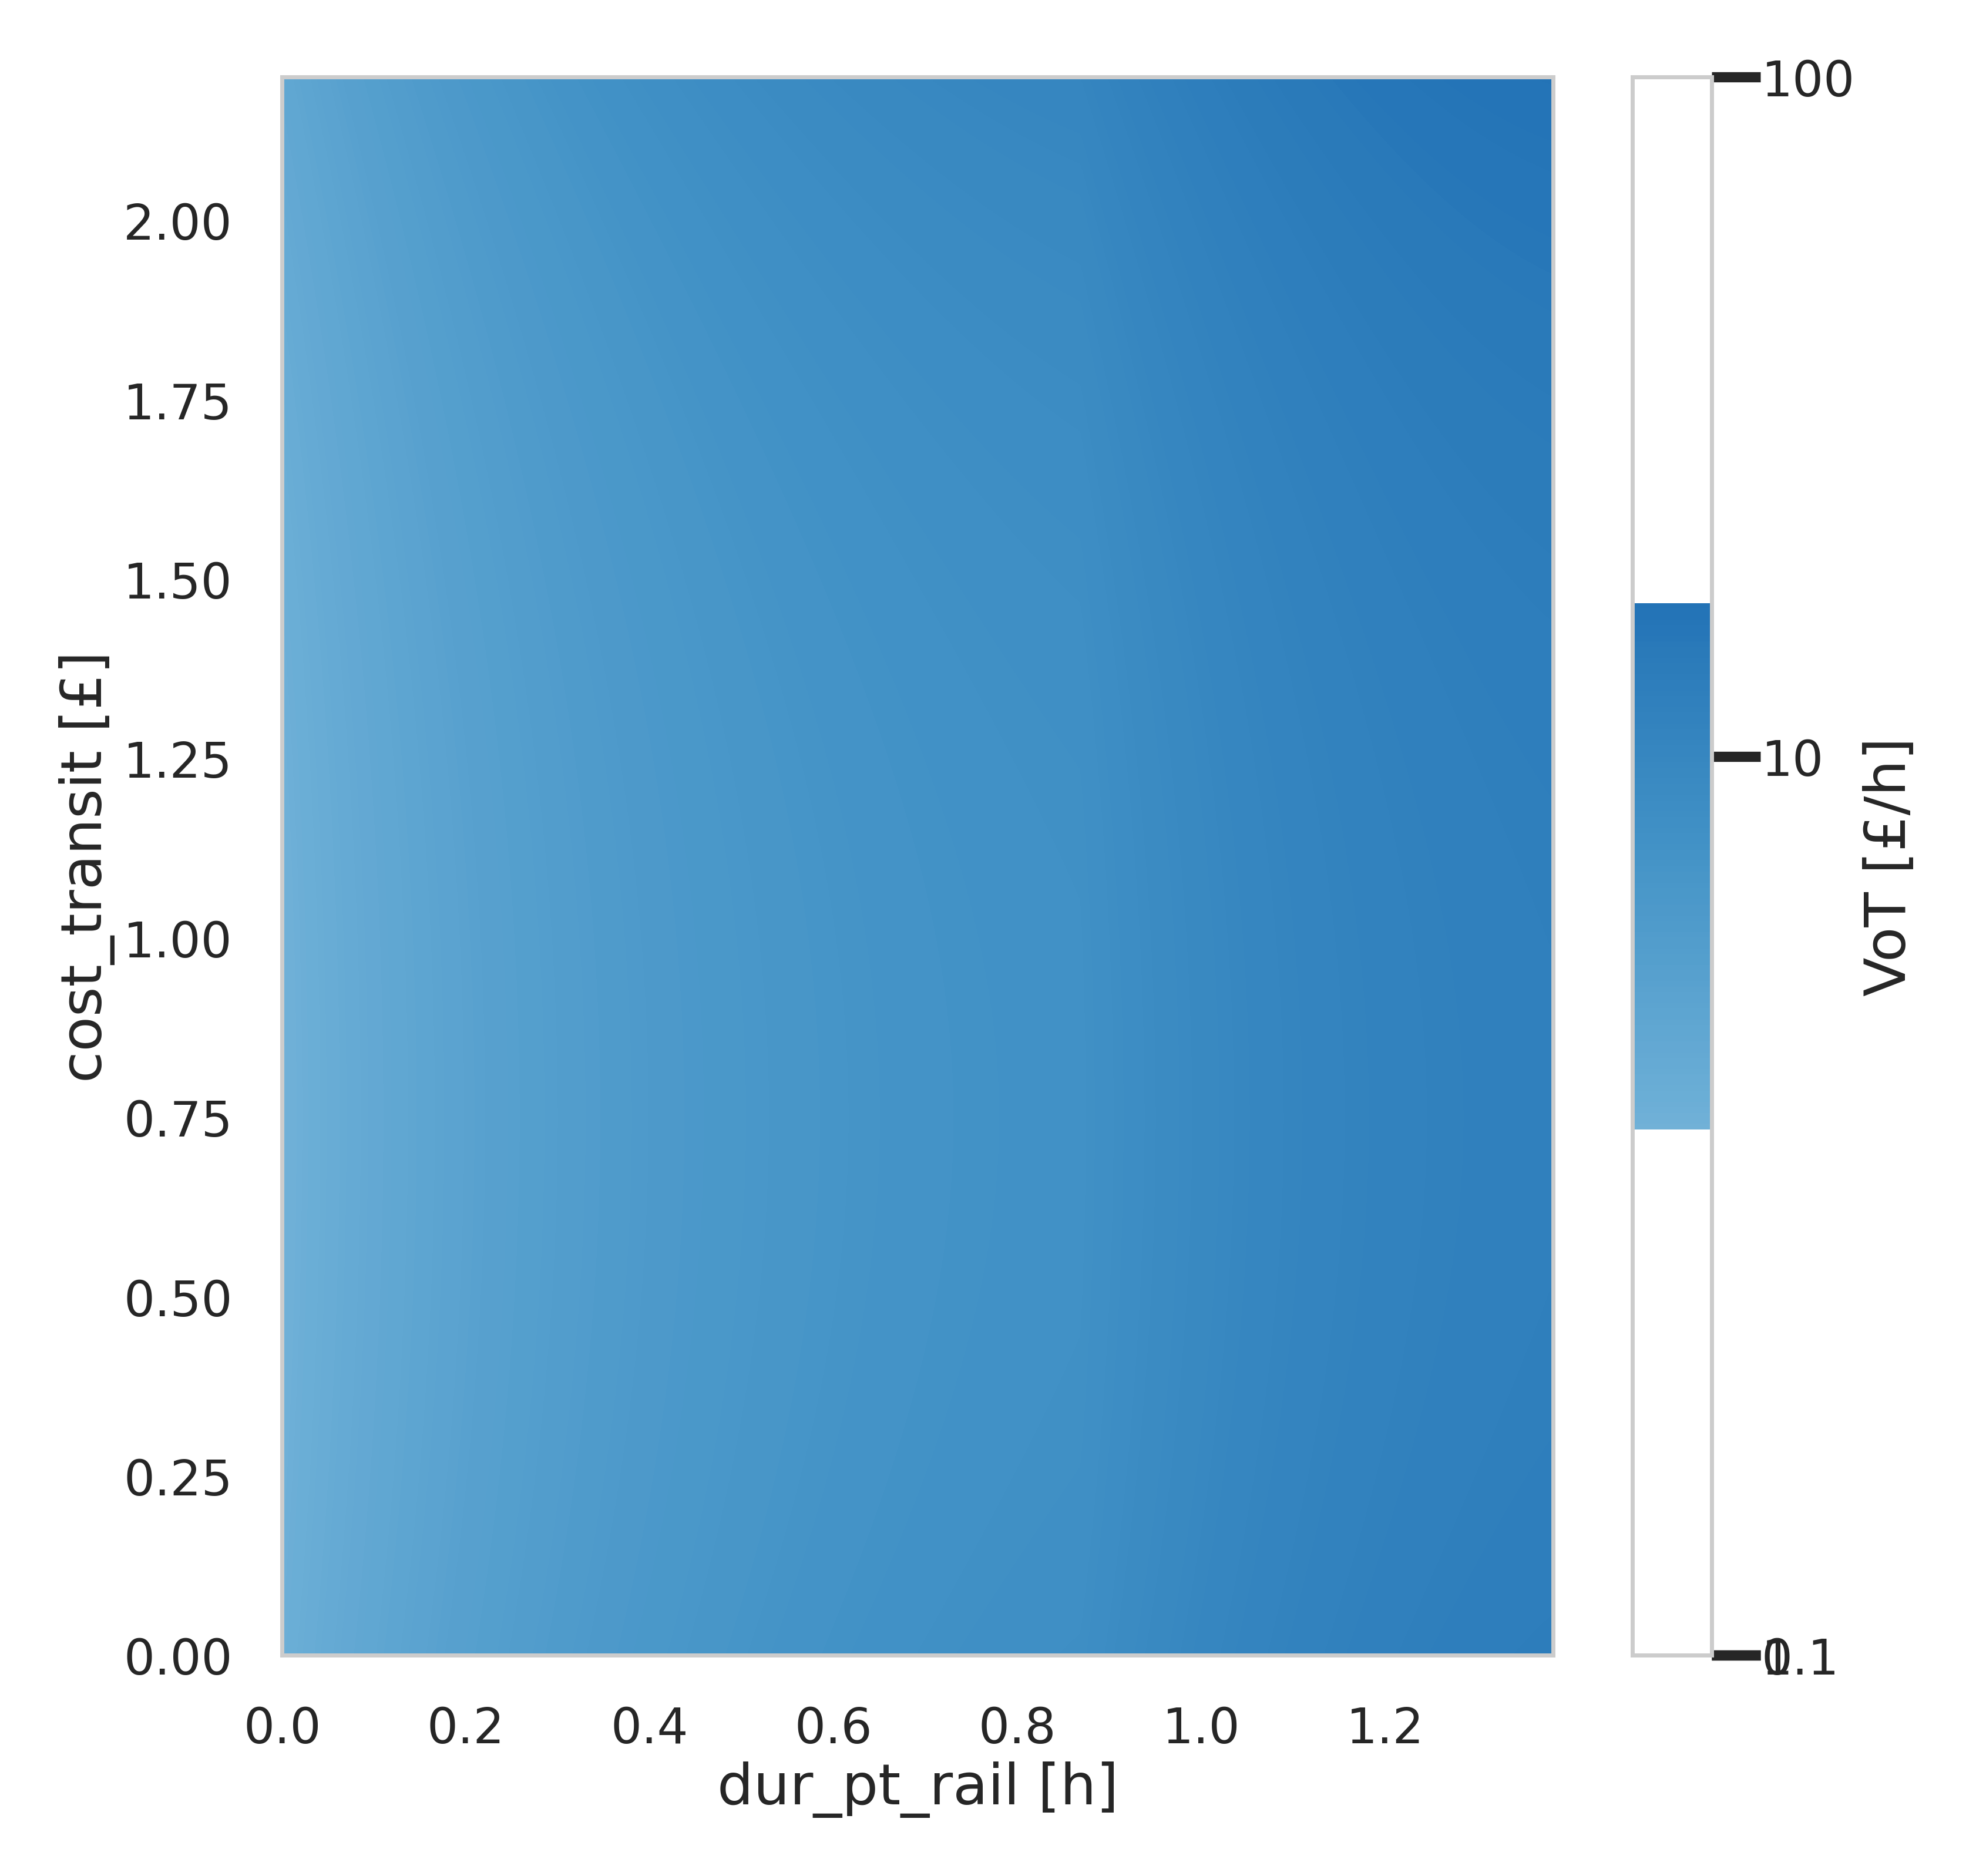

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/utility_plotting.py:1466: UserWarning: linewidths is ignored by contourf
  c_plot = axes.contourf(


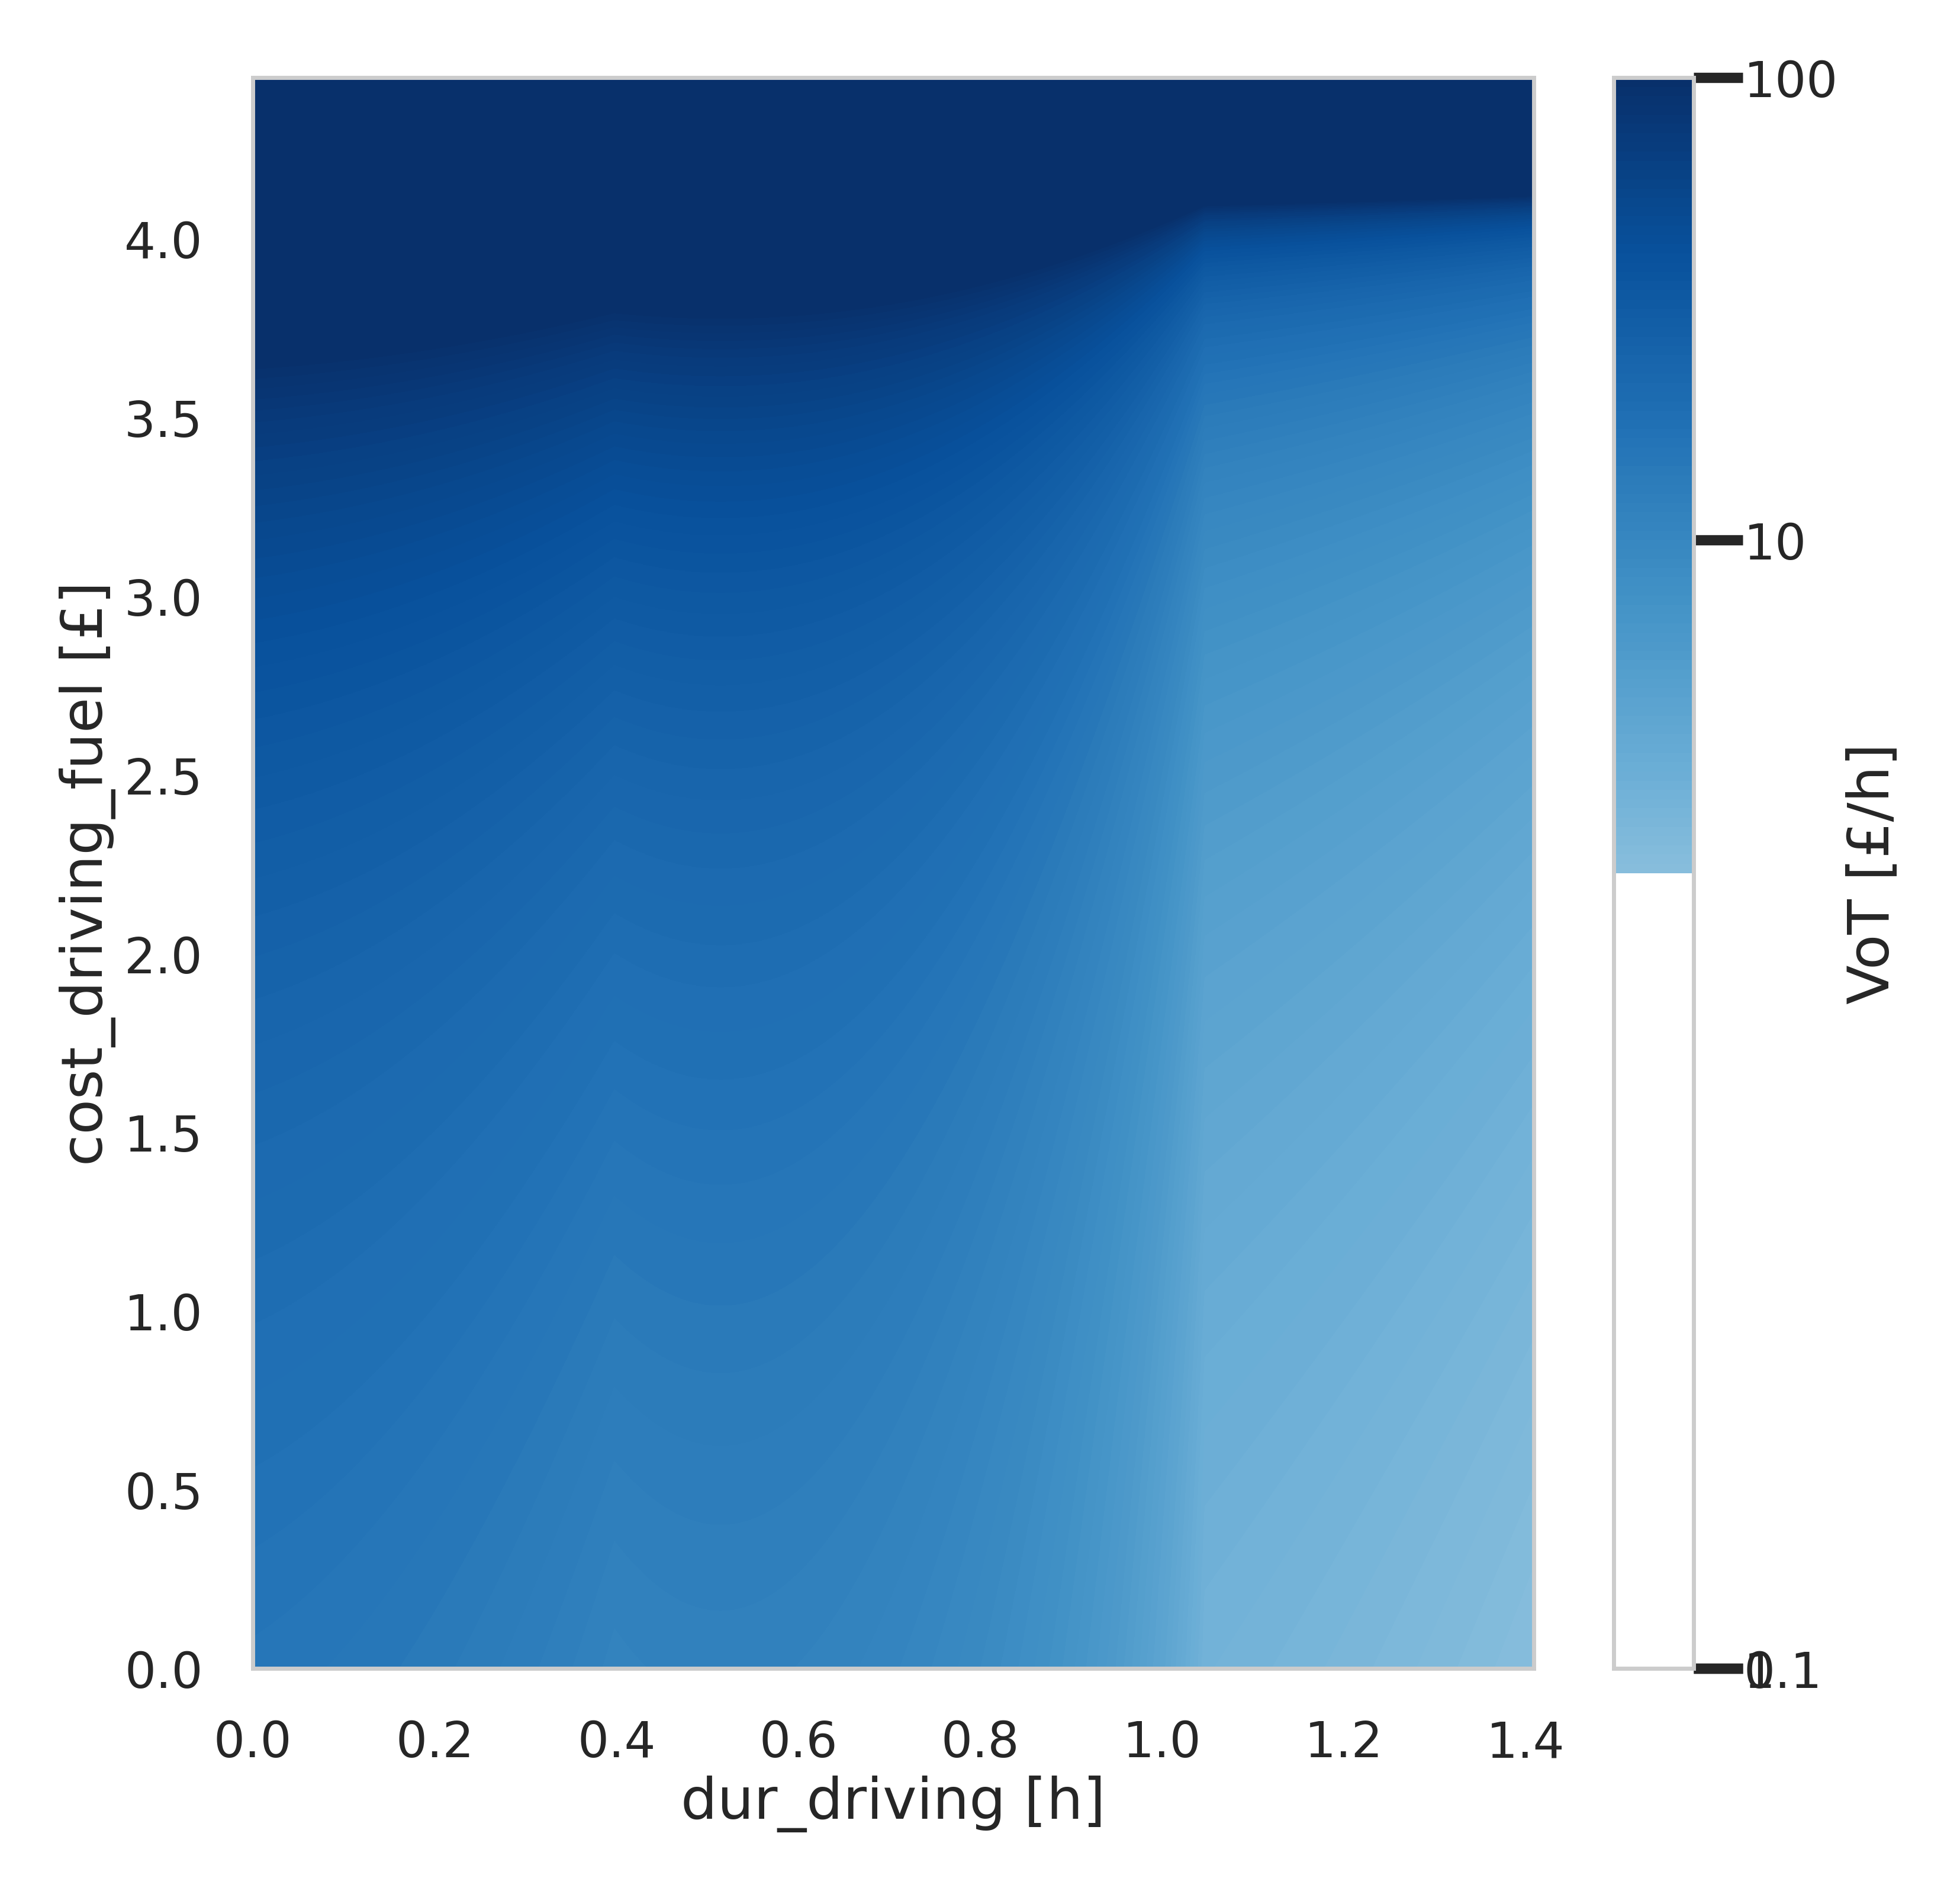

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/utility_plotting.py:1548: RuntimeWarning: divide by zero encountered in divide
  VoT_pop = d_f1(data_train[f1]) / d_f2(data_train[f2])


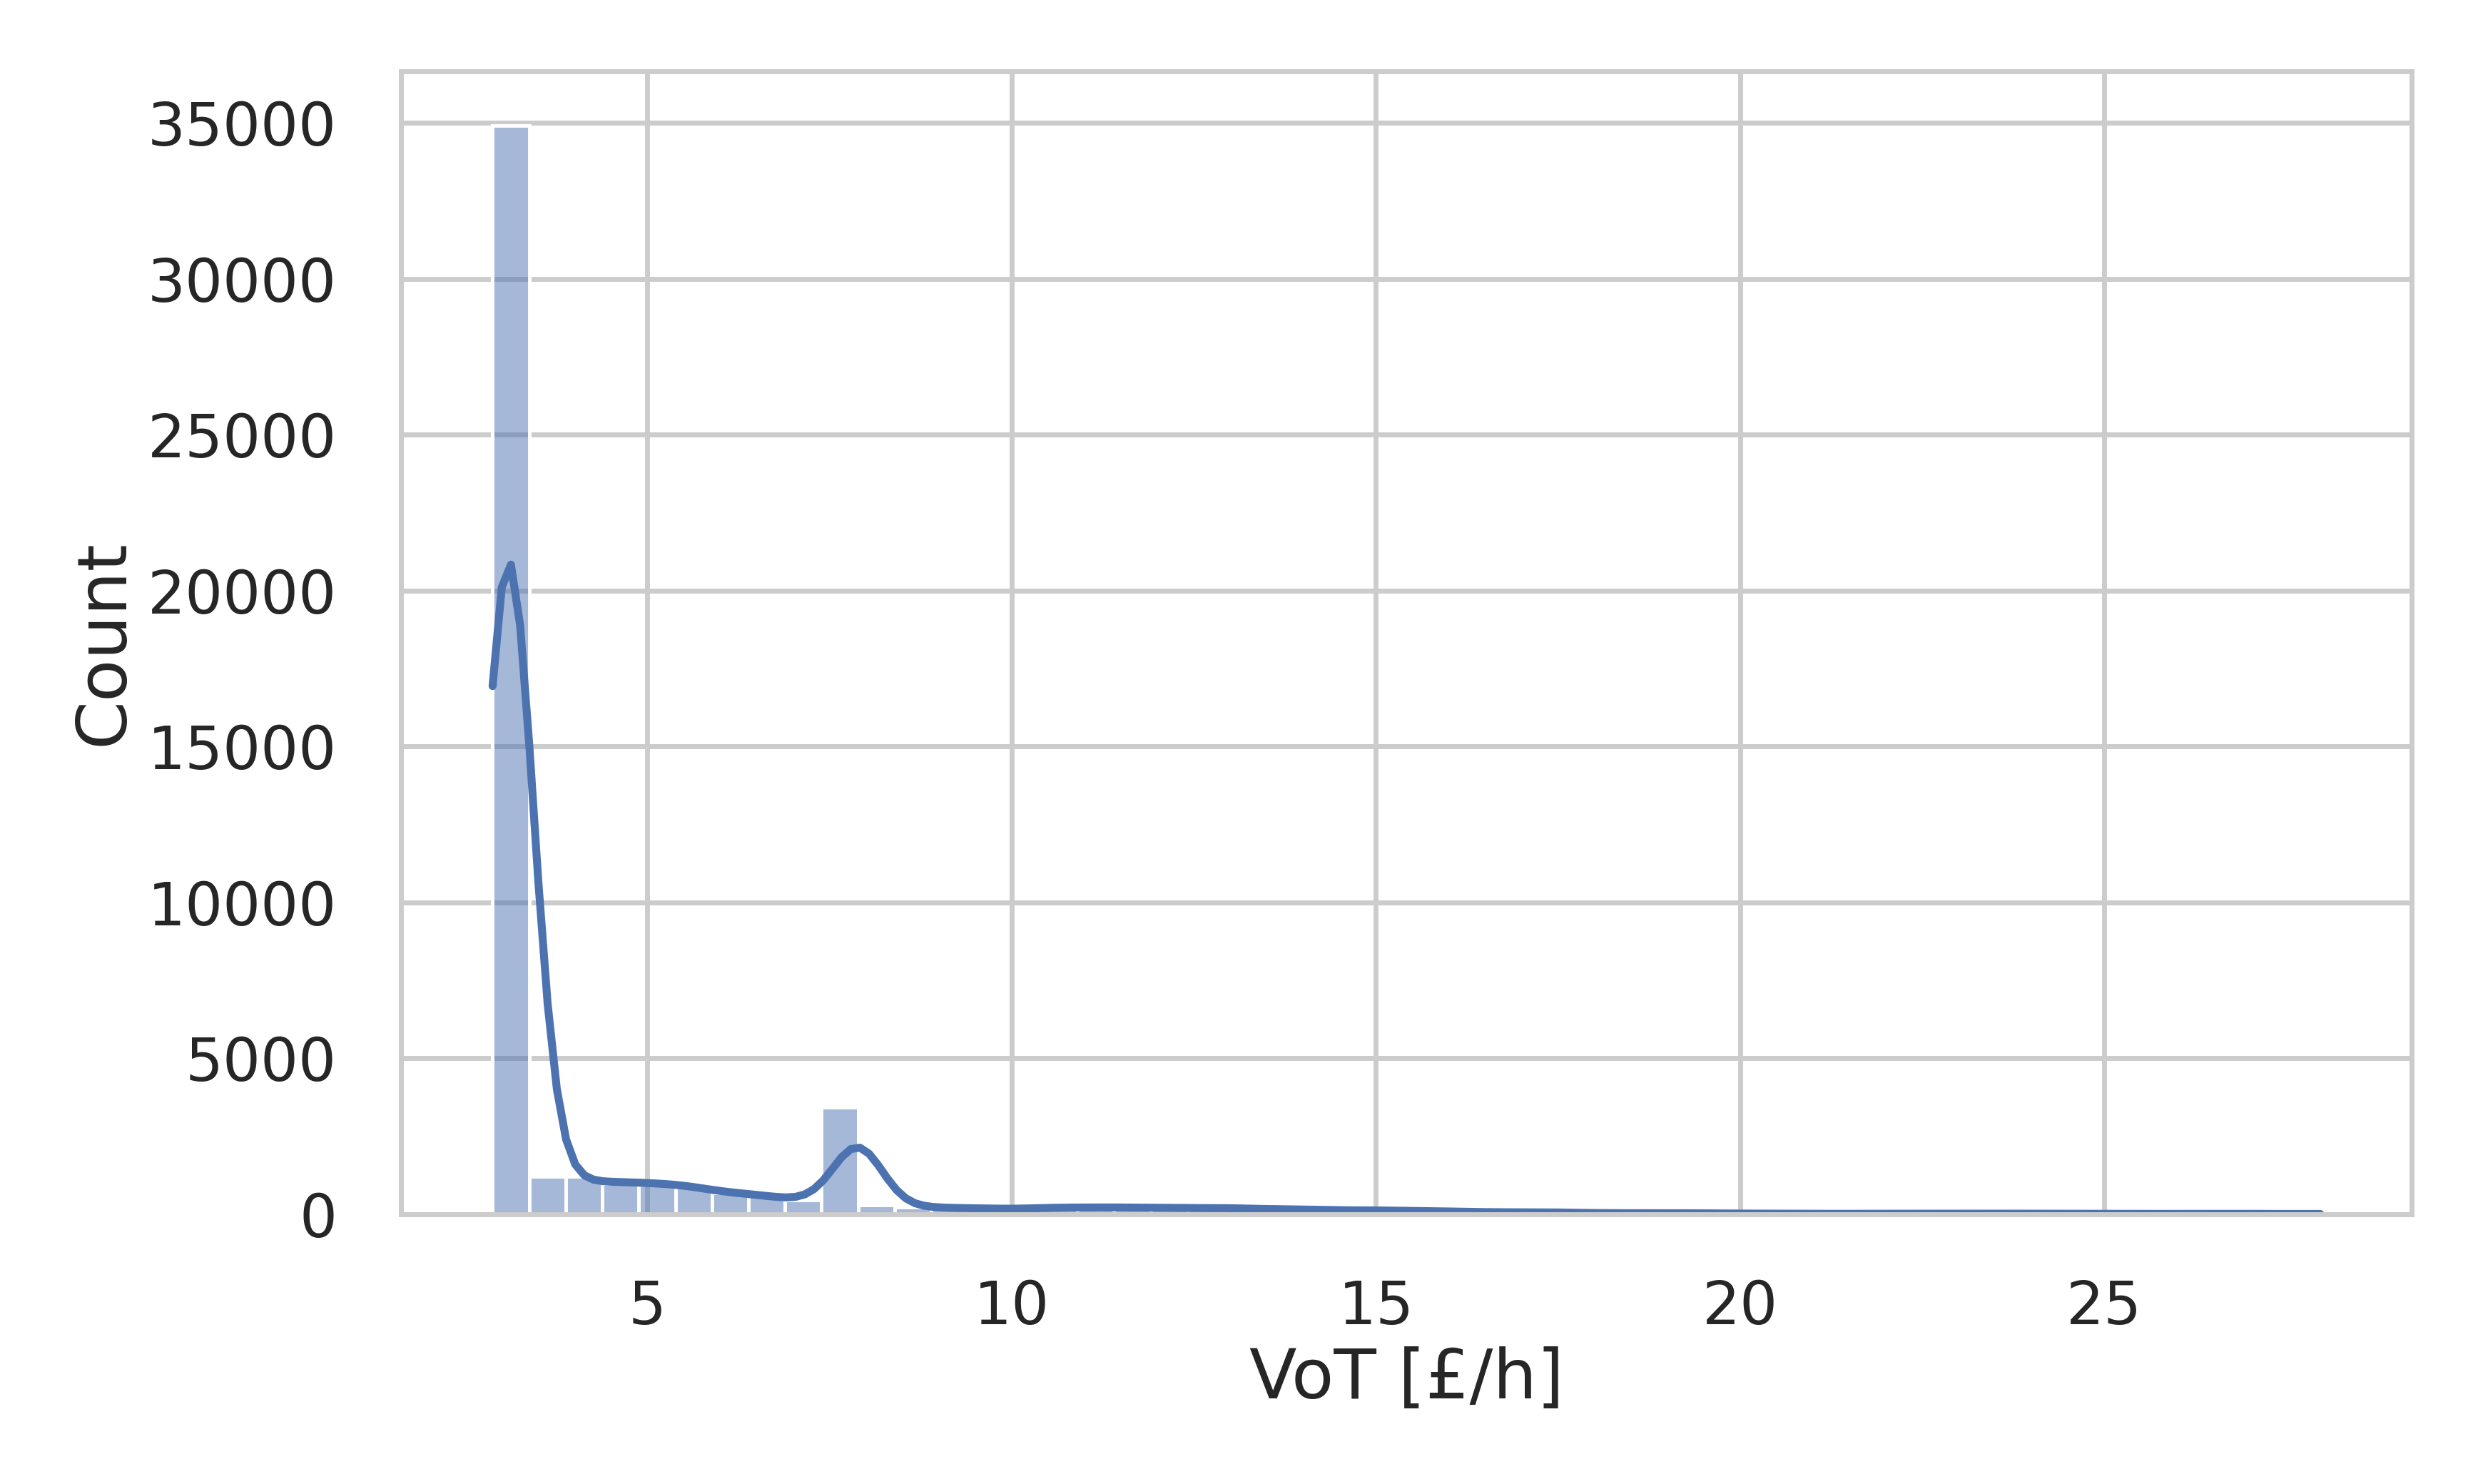

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/utility_plotting.py:1548: RuntimeWarning: divide by zero encountered in divide
  VoT_pop = d_f1(data_train[f1]) / d_f2(data_train[f2])
/home/nicolas-salvade/rumboost-dev/examples/../rumboost/utility_plotting.py:1548: RuntimeWarning: invalid value encountered in divide
  VoT_pop = d_f1(data_train[f1]) / d_f2(data_train[f2])


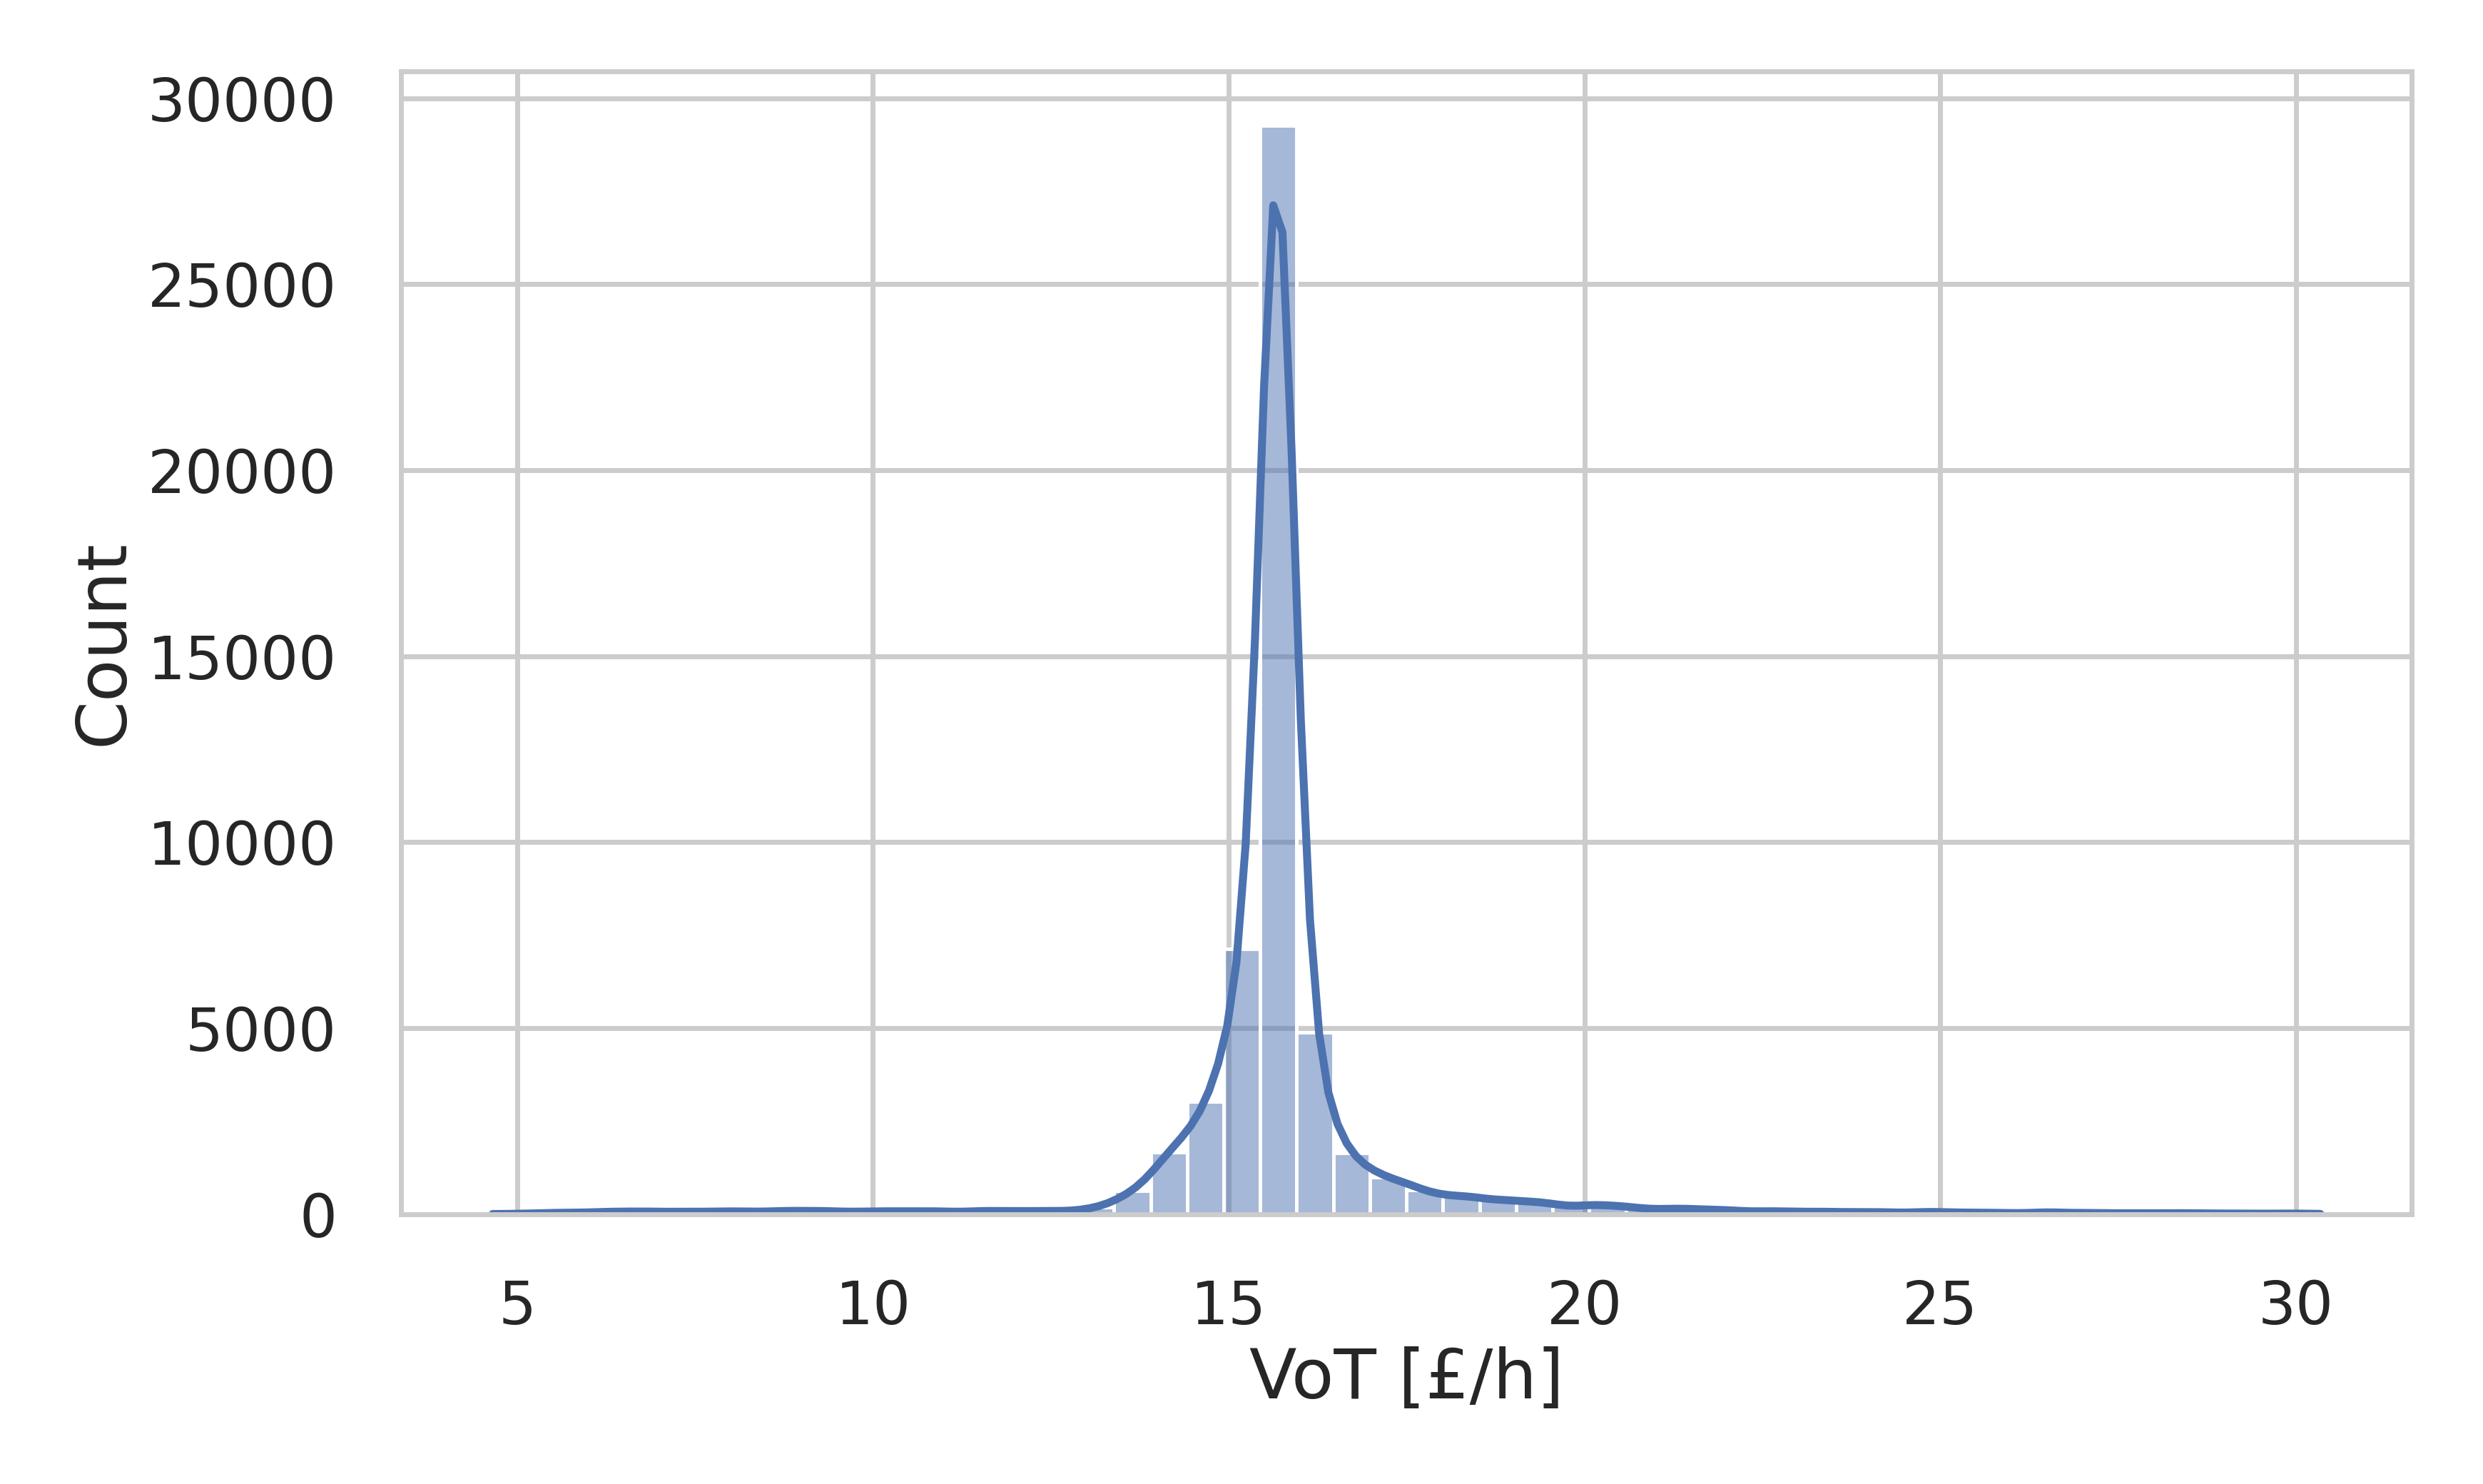

In [34]:
attribute_VoT =  {'2': ('dur_pt_rail', 'cost_transit'), '3':('dur_driving', 'cost_driving_fuel')}
draw_range = {'2':{'dur_pt_rail':(0,1.383), 'cost_transit':(0, 2.2)}, '3':{'dur_driving':(0, 1.409), 'cost_driving_fuel':(0, 4.45)}}

plot_VoT(LPMC_train, util_collection, attribute_VoT, utility_names={'0': 'Walking', '1': 'Cycling', '2':'Rail', '3':'Driving'}, draw_range=draw_range, save_figure=False)

plot_pop_VoT(LPMC_train, util_collection, attribute_VoT, save_figure=False)

# References

Salvadé, N., & Hillel, T. (2024). Rumboost: Gradient Boosted Random Utility Models. *arXiv preprint [arXiv:2401.11954](https://arxiv.org/abs/2401.11954)*

Hillel, T., Elshafie, M.Z.E.B., Jin, Y., 2018. Recreating passenger mode choice-sets for transport simulation: A case study of London, UK. Proceedings of the Institution of Civil Engineers - Smart Infrastructure and Construction 171, 29–42. https://doi.org/10.1680/jsmic.17.00018